# Regression using LLM

Since the performance of the large language model(LLM) is getting better and better these days, there are many trials to use LLM for not only the language, but also many other applications. I will focus on the LLM for the regression tasks. 



# Import libraries

In [2]:
# Using python 3.9.13 version
import pandas as pd
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_regression
import torch
import torch.nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import os
import json
from langchain.chat_models import ChatOpenAI
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from sklearn.metrics import mean_absolute_error, mean_squared_error


c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare the dataset

Friedman 1, 2, and 3 dataset from scikit-learn for non-linear regression, and linear function from scikit-learn (make_regression) for linear regression.

In [2]:
nonlinear_dataset1_X, nonlinear_dataset1_y = make_friedman1(n_samples=2000, n_features=5)
nonlinear_dataset2_X, nonlinear_dataset2_y = make_friedman2(n_samples=2000)
nonlinear_dataset3_X, nonlinear_dataset3_y = make_friedman3(n_samples=2000)

linear_dataset_X, linear_dataset_y = make_regression(n_samples=2000, n_features=10)


# Make dataset into dataframe

In [3]:
# Friedman1
df_nonlinear1 = pd.DataFrame(nonlinear_dataset1_X, columns=[f'x{i}' for i in range(nonlinear_dataset1_X.shape[1])])
df_nonlinear1['target'] = nonlinear_dataset1_y

# Friedman2
df_nonlinear2 = pd.DataFrame(nonlinear_dataset2_X, columns=[f'x{i}' for i in range(nonlinear_dataset2_X.shape[1])])
df_nonlinear2['target'] = nonlinear_dataset2_y

# Friedman3
df_nonlinear3 = pd.DataFrame(nonlinear_dataset3_X, columns=[f'x{i}' for i in range(nonlinear_dataset3_X.shape[1])])
df_nonlinear3['target'] = nonlinear_dataset3_y

# Linear regression
df_linear = pd.DataFrame(linear_dataset_X, columns=[f'x{i}' for i in range(linear_dataset_X.shape[1])])
df_linear['target'] = linear_dataset_y


In [4]:
#print dataframe
df_linear

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,target
0,1.336495,1.846914,2.220763,0.082447,-0.445510,0.302236,0.058253,-1.093822,1.993711,-1.470543,306.487627
1,-0.753212,-1.622064,1.063447,-0.502305,-0.330136,0.957635,0.261634,-1.077003,0.385220,-0.969371,-100.067261
2,0.304997,-0.774157,-0.082149,-0.157013,0.040479,-1.333998,0.842361,0.736853,0.107834,1.263762,-15.105222
3,-1.220810,0.701377,-0.089142,-0.882851,-1.074173,-1.127841,-1.492646,-0.610803,1.175338,0.186610,-245.030423
4,0.275996,-0.408199,-1.353512,-0.540614,-1.305027,0.574643,0.645630,-0.284960,-1.043625,0.500032,-98.587415
...,...,...,...,...,...,...,...,...,...,...,...
1995,0.857412,0.444841,-1.142453,-1.714227,-0.198319,1.904232,0.663862,-0.483417,-2.069694,0.095330,-61.278023
1996,-0.498781,-0.259729,-0.411148,-0.542799,0.939428,0.179675,0.565174,-0.828808,-0.463999,0.857351,-101.869668
1997,-1.410183,0.029992,-0.502915,-1.549476,-0.419930,1.331118,-1.858501,-1.051256,1.636448,-2.487658,-264.030257
1998,0.252271,0.616887,0.140083,-0.534860,0.306897,-1.016323,0.982282,0.543946,-0.275311,0.137366,37.833209


# Split datasets
Split all datasets into train, validation, test dataset in 8:1:1 ratio

In [27]:
def split_dataset(df, train_size=0.8, validation_size=0.1, test_size=0.1):

    train_data, val_data = train_test_split(df, test_size= validation_size + test_size)
    val_data, test_data = train_test_split(val_data, test_size=test_size/(validation_size+test_size))

    return train_data, val_data, test_data


In [28]:
nonlinear1_train_data, nonlinear1_val_data, nonlinear1_test_data = split_dataset(df_nonlinear1)
nonlinear2_train_data, nonlinear2_val_data, nonlinear2_test_data = split_dataset(df_nonlinear2)
nonlinear3_train_data, nonlinear3_val_data, nonlinear3_test_data = split_dataset(df_nonlinear3)
linear_train_data, linear_val_data, linear_test_data = split_dataset(df_linear)

# Combine columns to text

In [49]:
def combine_columns_to_text(df):
    df['text'] = df.apply(lambda row: ', '.join(f"{col}: {row[col]}" for col in df.columns[:-1]), axis=1)
    return df

In [60]:
nonlinear1_train_data = combine_columns_to_text(nonlinear1_train_data)
nonlinear1_val_data = combine_columns_to_text(nonlinear1_val_data)
nonlinear1_test_data = combine_columns_to_text(nonlinear1_test_data)

nonlinear2_train_data = combine_columns_to_text(nonlinear2_train_data)
nonlinear2_val_data = combine_columns_to_text(nonlinear2_val_data)
nonlinear2_test_data = combine_columns_to_text(nonlinear2_test_data)

nonlinear3_train_data = combine_columns_to_text(nonlinear3_train_data)
nonlinear3_val_data = combine_columns_to_text(nonlinear3_val_data)
nonlinear3_test_data = combine_columns_to_text(nonlinear3_test_data)

linear_train_data = combine_columns_to_text(linear_train_data)
linear_val_data = combine_columns_to_text(linear_val_data)
linear_test_data = combine_columns_to_text(linear_test_data)



In [88]:
nonlinear1_train_data[['text', 'target']]

,text,target
0,"x0: 0.38500583940494726, x1: 0.617087263779807...",11.825778
1,"x0: 0.4402894427740687, x1: 0.4261404634432781...",11.946407
2,"x0: 0.5189843043257324, x1: 0.3663350256281255...",14.569427
3,"x0: 0.8183873972085232, x1: 0.8704724293315682...",16.224716
4,"x0: 0.6527228949317997, x1: 0.8129608082035694...",21.397842
...,...,...
1595,"x0: 0.6508379454743366, x1: 0.9899480513453801...",15.840103
1596,"x0: 0.3473472281453469, x1: 0.9376444815354882...",19.053038
1597,"x0: 0.8226760504630862, x1: 0.3651398452807043...",15.406648
1598,"x0: 0.5287027487202827, x1: 0.4603447767847831...",9.444760


# Initialize the Model Class

We are going load pre-trained NT_5 model and it's tokenizer using hugging face library.


In [46]:
class NT_5():
  def __init__(self, model_name='nielsr/nt5-small-rc1'):

    self.tokenizer = T5Tokenizer.from_pretrained(model_name)
    self.model = T5ForSequenceClassification.from_pretrained(model_name, num_labels=1)

  def get_tokenizer_and_model(self):
    return self.model, self.tokenizer

# Initialize the Dataloader Class


In [44]:
class DatasetLoader(Dataset):

  def __init__(self, data, tokenizer):
    self.data = data
    self.tokenizer = tokenizer

  def tokenize_data(self):
    print("Processing data..")
    tokens = []
    labels = []

    text_list = self.data['text'].to_list()
    label_list = self.data['target'].to_list()

    for (text, label) in tqdm(zip(text_list, label_list), total=len(text_list)):
      
      encoded_token_text = self.tokenizer(text, max_length=512, return_tensors='pt', truncation=True, padding=True)
      tokens.append(encoded_token_text['input_ids'].squeeze(0))
      labels.append(label)

    tokens = pad_sequence(tokens, batch_first=True)
    labels = torch.tensor(labels)
    dataset = TensorDataset(tokens, labels)

    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    processed_dataset = self.tokenize_data()

    data_loader = DataLoader(
        processed_dataset,
        shuffle=shuffle,
        batch_size=batch_size
    )
    
    return data_loader

# Training functions



In [63]:
class Trainer():

    def __init__(self, options):
        self.device = options['device']
        self.train_data = options['train_data']
        self.dev_data = options['dev_data']
        self.batch_size = options['batch_size']
        self.epochs = options['epochs']
        self.save_path = options['save_path']
        nt_5 = NT_5()
        self.model, self.tokenizer = nt_5.get_tokenizer_and_model()
        self.model.to(self.device)

    def train(self, data_loader, optimizer):

        # Keep model as train mode
        self.model.train()
        total_loss = 0
        total_mae = 0

        for batch_idx, (texts, labels) in enumerate(tqdm(data_loader)):
            self.model.zero_grad()

            ## Input to the model
            texts = texts.to(self.device)
            labels = labels.to(self.device)

            # compute mae
            outputs = self.model(texts, labels=labels)
            loss = outputs.loss
            preds = outputs.logits
            mae_fc = torch.nn.L1Loss()
            mae = mae_fc(preds.flatten().float(), labels.float())
            
            # Add mae to total value
            total_mae += mae.item()
            total_loss += loss.item()

            # back propogation and update
            loss.backward()
            optimizer.step()

        mae = total_mae/len(data_loader)
        loss = total_loss/len(data_loader)

        return loss, mae
    def eval(self, data_loader):

        # Keep model as evaluation mode
        self.model.eval()
        total_mae = 0
        total_loss = 0

        with torch.no_grad():
            for (texts, labels) in tqdm(data_loader):

                # Pass the texts and labels in the given batch to the model
                texts = texts.to(self.device)
                labels = labels.to(self.device)

                # Take the output and compute the mae
                outputs = self.model(texts, labels=labels)
                loss = outputs.loss
                preds = outputs.logits
                mae_fc = torch.nn.L1Loss()
                mae = mae_fc(preds.flatten().float(), labels.float())

                # Add mae to total value
                total_mae += mae.item()
                total_loss += loss.item()

            mae = total_mae/len(data_loader)
            loss = total_loss/len(data_loader)

            return loss, mae

    def save_model(self):
        self.model.save_pretrained(self.save_path)
        self.tokenizer.save_pretrained(self.save_path)

    def execute(self):
        last_best = float('inf')
        train_dataset = DatasetLoader(self.train_data, self.tokenizer)
        train_data_loader = train_dataset.get_data_loaders(self.batch_size)
        dev_dataset = DatasetLoader(self.dev_data, self.tokenizer)
        dev_data_loader = dev_dataset.get_data_loaders(self.batch_size)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=5e-5, eps=1e-8)

        for epoch_i in range(0, self.epochs):
            train_loss, train_mae = self.train(train_data_loader, optimizer)
            print(f'Epoch {epoch_i + 1}: train_loss: {train_loss:.4f} train_mae: {train_mae:.4f}')
            dev_loss, dev_mae = self.eval(dev_data_loader)
            print(f'Epoch {epoch_i + 1}: dev_loss: {dev_loss:.4f} dev_mae: {dev_mae:.4f}')

            if dev_loss < last_best:
                print("Saving model..")
                self.save_model()
                last_best = dev_loss
                print("Model saved.")


# With NT5

# nonlinear1

In [14]:
options = {}

options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = nonlinear1_train_data
options['dev_data'] = nonlinear1_val_data
options['save_path'] = './model/NT_5_pretrained/nonlinear1'
options['epochs'] = 100

trainer = Trainer(options)
trainer.execute()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at nielsr/nt5-small-rc1 and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing data..


100%|██████████| 1600/1600 [00:00<00:00, 4400.64it/s]


Processing data..


100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


Epoch 1: train_loss: 130.7129 train_mae: 10.1572


100%|██████████| 63/63 [00:02<00:00, 21.58it/s]


Epoch 1: dev_loss: 49.9367 dev_mae: 5.8733
Saving model..
Model saved.


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 2: train_loss: 37.4287 train_mae: 5.0582


100%|██████████| 63/63 [00:02<00:00, 21.27it/s]


Epoch 2: dev_loss: 25.1272 dev_mae: 4.0600
Saving model..
Model saved.


100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


Epoch 3: train_loss: 23.9917 train_mae: 3.9929


100%|██████████| 63/63 [00:02<00:00, 21.04it/s]


Epoch 3: dev_loss: 19.8938 dev_mae: 3.6005
Saving model..
Model saved.


100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 4: train_loss: 20.8161 train_mae: 3.7134


100%|██████████| 63/63 [00:02<00:00, 21.09it/s]


Epoch 4: dev_loss: 23.6774 dev_mae: 3.9424


100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Epoch 5: train_loss: 15.5648 train_mae: 3.1660


100%|██████████| 63/63 [00:02<00:00, 21.11it/s]


Epoch 5: dev_loss: 13.8391 dev_mae: 3.0808
Saving model..
Model saved.


100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 6: train_loss: 12.4016 train_mae: 2.8270


100%|██████████| 63/63 [00:02<00:00, 21.13it/s]


Epoch 6: dev_loss: 12.0185 dev_mae: 2.8642
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 7: train_loss: 10.3276 train_mae: 2.5783


100%|██████████| 63/63 [00:02<00:00, 21.18it/s]


Epoch 7: dev_loss: 8.4798 dev_mae: 2.3669
Saving model..
Model saved.


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 8: train_loss: 7.7080 train_mae: 2.1862


100%|██████████| 63/63 [00:02<00:00, 21.13it/s]


Epoch 8: dev_loss: 7.6436 dev_mae: 2.2219
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 9: train_loss: 6.5142 train_mae: 1.9947


100%|██████████| 63/63 [00:02<00:00, 21.04it/s]


Epoch 9: dev_loss: 8.3170 dev_mae: 2.3979


100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


Epoch 10: train_loss: 5.9924 train_mae: 1.9295


100%|██████████| 63/63 [00:02<00:00, 21.00it/s]


Epoch 10: dev_loss: 7.1536 dev_mae: 2.2109
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 11: train_loss: 5.0658 train_mae: 1.7542


100%|██████████| 63/63 [00:03<00:00, 20.82it/s]


Epoch 11: dev_loss: 6.9747 dev_mae: 2.1979
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 12: train_loss: 4.8618 train_mae: 1.7264


100%|██████████| 63/63 [00:03<00:00, 20.79it/s]


Epoch 12: dev_loss: 5.6247 dev_mae: 1.9340
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 13: train_loss: 4.3247 train_mae: 1.6128


100%|██████████| 63/63 [00:03<00:00, 20.85it/s]


Epoch 13: dev_loss: 5.4239 dev_mae: 1.9380
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 14: train_loss: 4.0777 train_mae: 1.5752


100%|██████████| 63/63 [00:02<00:00, 21.13it/s]


Epoch 14: dev_loss: 3.9229 dev_mae: 1.5585
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.65it/s]


Epoch 15: train_loss: 3.8044 train_mae: 1.5172


100%|██████████| 63/63 [00:03<00:00, 20.90it/s]


Epoch 15: dev_loss: 5.5157 dev_mae: 1.9863


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Epoch 16: train_loss: 3.2667 train_mae: 1.4144


100%|██████████| 63/63 [00:02<00:00, 21.14it/s]


Epoch 16: dev_loss: 5.6801 dev_mae: 2.0224


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 17: train_loss: 2.7182 train_mae: 1.2907


100%|██████████| 63/63 [00:03<00:00, 20.91it/s]


Epoch 17: dev_loss: 4.1222 dev_mae: 1.7058


100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


Epoch 18: train_loss: 2.5867 train_mae: 1.2750


100%|██████████| 63/63 [00:03<00:00, 20.93it/s]


Epoch 18: dev_loss: 2.9268 dev_mae: 1.4126
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 19: train_loss: 2.4066 train_mae: 1.1926


100%|██████████| 63/63 [00:02<00:00, 21.06it/s]


Epoch 19: dev_loss: 2.9994 dev_mae: 1.4486


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 20: train_loss: 1.9902 train_mae: 1.1051


100%|██████████| 63/63 [00:03<00:00, 20.78it/s]


Epoch 20: dev_loss: 3.7509 dev_mae: 1.6493


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Epoch 21: train_loss: 1.8866 train_mae: 1.0763


100%|██████████| 63/63 [00:03<00:00, 20.87it/s]


Epoch 21: dev_loss: 1.9426 dev_mae: 1.1463
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.60it/s]


Epoch 22: train_loss: 1.7988 train_mae: 1.0520


100%|██████████| 63/63 [00:03<00:00, 20.75it/s]


Epoch 22: dev_loss: 1.5609 dev_mae: 1.0181
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 23: train_loss: 1.6608 train_mae: 1.0093


100%|██████████| 63/63 [00:03<00:00, 20.83it/s]


Epoch 23: dev_loss: 3.4953 dev_mae: 1.6143


100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


Epoch 24: train_loss: 1.6519 train_mae: 1.0204


100%|██████████| 63/63 [00:03<00:00, 20.81it/s]


Epoch 24: dev_loss: 3.0465 dev_mae: 1.5070


100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 25: train_loss: 1.5687 train_mae: 0.9823


100%|██████████| 63/63 [00:03<00:00, 20.53it/s]


Epoch 25: dev_loss: 3.3144 dev_mae: 1.6118


100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 26: train_loss: 1.4148 train_mae: 0.9218


100%|██████████| 63/63 [00:03<00:00, 20.48it/s]


Epoch 26: dev_loss: 1.4102 dev_mae: 0.9548
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.58it/s]


Epoch 27: train_loss: 1.3436 train_mae: 0.9133


100%|██████████| 63/63 [00:03<00:00, 20.80it/s]


Epoch 27: dev_loss: 1.9460 dev_mae: 1.1821


100%|██████████| 100/100 [00:15<00:00,  6.59it/s]


Epoch 28: train_loss: 1.1707 train_mae: 0.8530


100%|██████████| 63/63 [00:03<00:00, 20.61it/s]


Epoch 28: dev_loss: 1.6052 dev_mae: 1.0544


100%|██████████| 100/100 [00:15<00:00,  6.61it/s]


Epoch 29: train_loss: 1.3108 train_mae: 0.8806


100%|██████████| 63/63 [00:03<00:00, 20.68it/s]


Epoch 29: dev_loss: 1.7189 dev_mae: 1.1012


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 30: train_loss: 1.1521 train_mae: 0.8374


100%|██████████| 63/63 [00:03<00:00, 20.40it/s]


Epoch 30: dev_loss: 2.6783 dev_mae: 1.4385


100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Epoch 31: train_loss: 1.1703 train_mae: 0.8455


100%|██████████| 63/63 [00:03<00:00, 20.42it/s]


Epoch 31: dev_loss: 2.0885 dev_mae: 1.2105


100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 32: train_loss: 1.0244 train_mae: 0.7894


100%|██████████| 63/63 [00:03<00:00, 20.37it/s]


Epoch 32: dev_loss: 2.2599 dev_mae: 1.3018


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


Epoch 33: train_loss: 1.0134 train_mae: 0.7784


100%|██████████| 63/63 [00:03<00:00, 20.21it/s]


Epoch 33: dev_loss: 1.3661 dev_mae: 0.9526
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


Epoch 34: train_loss: 1.0277 train_mae: 0.7930


100%|██████████| 63/63 [00:03<00:00, 20.24it/s]


Epoch 34: dev_loss: 1.6357 dev_mae: 1.0715


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


Epoch 35: train_loss: 0.9972 train_mae: 0.7832


100%|██████████| 63/63 [00:03<00:00, 20.20it/s]


Epoch 35: dev_loss: 1.8272 dev_mae: 1.1657


100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 36: train_loss: 0.8472 train_mae: 0.7218


100%|██████████| 63/63 [00:03<00:00, 20.24it/s]


Epoch 36: dev_loss: 2.0045 dev_mae: 1.1862


100%|██████████| 100/100 [00:15<00:00,  6.48it/s]


Epoch 37: train_loss: 0.9093 train_mae: 0.7436


100%|██████████| 63/63 [00:03<00:00, 20.10it/s]


Epoch 37: dev_loss: 1.6849 dev_mae: 1.0951


100%|██████████| 100/100 [00:15<00:00,  6.52it/s]


Epoch 38: train_loss: 0.8198 train_mae: 0.7091


100%|██████████| 63/63 [00:03<00:00, 20.22it/s]


Epoch 38: dev_loss: 1.3683 dev_mae: 0.9835


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 39: train_loss: 0.8712 train_mae: 0.7342


100%|██████████| 63/63 [00:03<00:00, 20.04it/s]


Epoch 39: dev_loss: 1.1878 dev_mae: 0.8849
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Epoch 40: train_loss: 0.8135 train_mae: 0.6986


100%|██████████| 63/63 [00:03<00:00, 20.13it/s]


Epoch 40: dev_loss: 1.3673 dev_mae: 0.9904


100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 41: train_loss: 0.8651 train_mae: 0.7192


100%|██████████| 63/63 [00:03<00:00, 20.10it/s]


Epoch 41: dev_loss: 0.9791 dev_mae: 0.8076
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 42: train_loss: 0.8218 train_mae: 0.7106


100%|██████████| 63/63 [00:03<00:00, 19.76it/s]


Epoch 42: dev_loss: 1.6317 dev_mae: 1.0613


100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


Epoch 43: train_loss: 0.7340 train_mae: 0.6647


100%|██████████| 63/63 [00:03<00:00, 19.72it/s]


Epoch 43: dev_loss: 1.8491 dev_mae: 1.1734


100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


Epoch 44: train_loss: 0.6854 train_mae: 0.6543


100%|██████████| 63/63 [00:03<00:00, 19.67it/s]


Epoch 44: dev_loss: 1.2607 dev_mae: 0.9658


100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


Epoch 45: train_loss: 0.6804 train_mae: 0.6531


100%|██████████| 63/63 [00:03<00:00, 19.67it/s]


Epoch 45: dev_loss: 1.0386 dev_mae: 0.8630


100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 46: train_loss: 0.6710 train_mae: 0.6417


100%|██████████| 63/63 [00:03<00:00, 19.79it/s]


Epoch 46: dev_loss: 1.9282 dev_mae: 1.2268


100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


Epoch 47: train_loss: 0.6949 train_mae: 0.6567


100%|██████████| 63/63 [00:03<00:00, 19.88it/s]


Epoch 47: dev_loss: 1.0658 dev_mae: 0.8568


100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 48: train_loss: 0.6743 train_mae: 0.6455


100%|██████████| 63/63 [00:03<00:00, 19.65it/s]


Epoch 48: dev_loss: 0.6962 dev_mae: 0.6744
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.42it/s]


Epoch 49: train_loss: 0.6662 train_mae: 0.6362


100%|██████████| 63/63 [00:03<00:00, 19.69it/s]


Epoch 49: dev_loss: 0.8374 dev_mae: 0.7502


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 50: train_loss: 0.6890 train_mae: 0.6559


100%|██████████| 63/63 [00:03<00:00, 19.59it/s]


Epoch 50: dev_loss: 0.6908 dev_mae: 0.6776
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 51: train_loss: 0.6658 train_mae: 0.6379


100%|██████████| 63/63 [00:03<00:00, 19.37it/s]


Epoch 51: dev_loss: 0.5531 dev_mae: 0.5940
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Epoch 52: train_loss: 0.6304 train_mae: 0.6257


100%|██████████| 63/63 [00:03<00:00, 19.64it/s]


Epoch 52: dev_loss: 1.3257 dev_mae: 0.9657


100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


Epoch 53: train_loss: 0.6240 train_mae: 0.6247


100%|██████████| 63/63 [00:03<00:00, 19.63it/s]


Epoch 53: dev_loss: 1.5960 dev_mae: 1.0812


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 54: train_loss: 0.5852 train_mae: 0.6014


100%|██████████| 63/63 [00:03<00:00, 19.63it/s]


Epoch 54: dev_loss: 1.1265 dev_mae: 0.9319


100%|██████████| 100/100 [00:15<00:00,  6.38it/s]


Epoch 55: train_loss: 0.5832 train_mae: 0.5950


100%|██████████| 63/63 [00:03<00:00, 19.35it/s]


Epoch 55: dev_loss: 0.8559 dev_mae: 0.7530


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Epoch 56: train_loss: 0.5938 train_mae: 0.6046


100%|██████████| 63/63 [00:03<00:00, 19.50it/s]


Epoch 56: dev_loss: 1.0413 dev_mae: 0.8423


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 57: train_loss: 0.5037 train_mae: 0.5611


100%|██████████| 63/63 [00:03<00:00, 19.40it/s]


Epoch 57: dev_loss: 0.6595 dev_mae: 0.6619


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 58: train_loss: 0.5770 train_mae: 0.5931


100%|██████████| 63/63 [00:03<00:00, 19.46it/s]


Epoch 58: dev_loss: 0.6691 dev_mae: 0.6649


100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Epoch 59: train_loss: 0.5935 train_mae: 0.6001


100%|██████████| 63/63 [00:03<00:00, 19.46it/s]


Epoch 59: dev_loss: 1.0136 dev_mae: 0.8553


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 60: train_loss: 0.5285 train_mae: 0.5711


100%|██████████| 63/63 [00:03<00:00, 19.29it/s]


Epoch 60: dev_loss: 1.0449 dev_mae: 0.8670


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 61: train_loss: 0.5204 train_mae: 0.5596


100%|██████████| 63/63 [00:03<00:00, 19.16it/s]


Epoch 61: dev_loss: 1.1761 dev_mae: 0.9037


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Epoch 62: train_loss: 0.5041 train_mae: 0.5561


100%|██████████| 63/63 [00:03<00:00, 19.29it/s]


Epoch 62: dev_loss: 1.1671 dev_mae: 0.9029


100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


Epoch 63: train_loss: 0.5217 train_mae: 0.5713


100%|██████████| 63/63 [00:03<00:00, 19.45it/s]


Epoch 63: dev_loss: 1.2679 dev_mae: 0.9584


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 64: train_loss: 0.4836 train_mae: 0.5426


100%|██████████| 63/63 [00:03<00:00, 19.50it/s]


Epoch 64: dev_loss: 1.2805 dev_mae: 0.9582


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 65: train_loss: 0.4821 train_mae: 0.5473


100%|██████████| 63/63 [00:03<00:00, 19.17it/s]


Epoch 65: dev_loss: 0.9331 dev_mae: 0.8084


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 66: train_loss: 0.4520 train_mae: 0.5331


100%|██████████| 63/63 [00:03<00:00, 19.31it/s]


Epoch 66: dev_loss: 1.1039 dev_mae: 0.8678


100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 67: train_loss: 0.4557 train_mae: 0.5252


100%|██████████| 63/63 [00:03<00:00, 19.10it/s]


Epoch 67: dev_loss: 1.1048 dev_mae: 0.8882


100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 68: train_loss: 0.4421 train_mae: 0.5248


100%|██████████| 63/63 [00:03<00:00, 19.29it/s]


Epoch 68: dev_loss: 1.1356 dev_mae: 0.8832


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 69: train_loss: 0.4662 train_mae: 0.5378


100%|██████████| 63/63 [00:03<00:00, 19.18it/s]


Epoch 69: dev_loss: 0.9248 dev_mae: 0.8277


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 70: train_loss: 0.4539 train_mae: 0.5292


100%|██████████| 63/63 [00:03<00:00, 19.29it/s]


Epoch 70: dev_loss: 0.7471 dev_mae: 0.7317


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 71: train_loss: 0.4522 train_mae: 0.5270


100%|██████████| 63/63 [00:03<00:00, 19.05it/s]


Epoch 71: dev_loss: 1.1733 dev_mae: 0.9188


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


Epoch 72: train_loss: 0.3942 train_mae: 0.4980


100%|██████████| 63/63 [00:03<00:00, 19.32it/s]


Epoch 72: dev_loss: 1.1344 dev_mae: 0.9106


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 73: train_loss: 0.4188 train_mae: 0.5121


100%|██████████| 63/63 [00:03<00:00, 19.23it/s]


Epoch 73: dev_loss: 0.7803 dev_mae: 0.7368


100%|██████████| 100/100 [00:15<00:00,  6.32it/s]


Epoch 74: train_loss: 0.4126 train_mae: 0.5029


100%|██████████| 63/63 [00:03<00:00, 19.20it/s]


Epoch 74: dev_loss: 0.7409 dev_mae: 0.7484


100%|██████████| 100/100 [00:15<00:00,  6.34it/s]


Epoch 75: train_loss: 0.4087 train_mae: 0.4997


100%|██████████| 63/63 [00:03<00:00, 19.41it/s]


Epoch 75: dev_loss: 0.8289 dev_mae: 0.7800


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 76: train_loss: 0.3826 train_mae: 0.4947


100%|██████████| 63/63 [00:03<00:00, 19.12it/s]


Epoch 76: dev_loss: 1.2472 dev_mae: 0.9643


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 77: train_loss: 0.4080 train_mae: 0.5067


100%|██████████| 63/63 [00:03<00:00, 19.31it/s]


Epoch 77: dev_loss: 0.6915 dev_mae: 0.6921


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 78: train_loss: 0.3911 train_mae: 0.4858


100%|██████████| 63/63 [00:03<00:00, 19.29it/s]


Epoch 78: dev_loss: 0.8044 dev_mae: 0.7670


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 79: train_loss: 0.3887 train_mae: 0.4897


100%|██████████| 63/63 [00:03<00:00, 19.32it/s]


Epoch 79: dev_loss: 0.7565 dev_mae: 0.7356


100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 80: train_loss: 0.3708 train_mae: 0.4843


100%|██████████| 63/63 [00:03<00:00, 19.20it/s]


Epoch 80: dev_loss: 0.7666 dev_mae: 0.7186


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 81: train_loss: 0.3666 train_mae: 0.4779


100%|██████████| 63/63 [00:03<00:00, 19.17it/s]


Epoch 81: dev_loss: 0.5039 dev_mae: 0.5871
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 82: train_loss: 0.3503 train_mae: 0.4618


100%|██████████| 63/63 [00:03<00:00, 19.16it/s]


Epoch 82: dev_loss: 0.5763 dev_mae: 0.6258


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 83: train_loss: 0.3554 train_mae: 0.4717


100%|██████████| 63/63 [00:03<00:00, 18.97it/s]


Epoch 83: dev_loss: 0.6689 dev_mae: 0.6780


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 84: train_loss: 0.3877 train_mae: 0.4837


100%|██████████| 63/63 [00:03<00:00, 19.07it/s]


Epoch 84: dev_loss: 0.7652 dev_mae: 0.7166


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 85: train_loss: 0.3676 train_mae: 0.4759


100%|██████████| 63/63 [00:03<00:00, 19.08it/s]


Epoch 85: dev_loss: 1.1108 dev_mae: 0.8936


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 86: train_loss: 0.3663 train_mae: 0.4788


100%|██████████| 63/63 [00:03<00:00, 19.06it/s]


Epoch 86: dev_loss: 0.3447 dev_mae: 0.4585
Saving model..
Model saved.


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Epoch 87: train_loss: 0.3452 train_mae: 0.4680


100%|██████████| 63/63 [00:03<00:00, 19.18it/s]


Epoch 87: dev_loss: 0.8824 dev_mae: 0.7813


100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


Epoch 88: train_loss: 0.3532 train_mae: 0.4626


100%|██████████| 63/63 [00:03<00:00, 19.06it/s]


Epoch 88: dev_loss: 0.6432 dev_mae: 0.6633


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 89: train_loss: 0.3225 train_mae: 0.4480


100%|██████████| 63/63 [00:03<00:00, 19.20it/s]


Epoch 89: dev_loss: 0.6374 dev_mae: 0.6624


100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 90: train_loss: 0.3333 train_mae: 0.4509


100%|██████████| 63/63 [00:03<00:00, 19.03it/s]


Epoch 90: dev_loss: 0.5133 dev_mae: 0.5753


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 91: train_loss: 0.3605 train_mae: 0.4752


100%|██████████| 63/63 [00:03<00:00, 19.18it/s]


Epoch 91: dev_loss: 0.4468 dev_mae: 0.5361


100%|██████████| 100/100 [00:15<00:00,  6.25it/s]


Epoch 92: train_loss: 0.3634 train_mae: 0.4771


100%|██████████| 63/63 [00:03<00:00, 19.04it/s]


Epoch 92: dev_loss: 0.5794 dev_mae: 0.6268


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 93: train_loss: 0.3242 train_mae: 0.4509


100%|██████████| 63/63 [00:03<00:00, 19.03it/s]


Epoch 93: dev_loss: 0.6178 dev_mae: 0.6468


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


Epoch 94: train_loss: 0.3164 train_mae: 0.4437


100%|██████████| 63/63 [00:03<00:00, 19.13it/s]


Epoch 94: dev_loss: 0.4109 dev_mae: 0.4923


100%|██████████| 100/100 [00:15<00:00,  6.28it/s]


Epoch 95: train_loss: 0.3093 train_mae: 0.4421


100%|██████████| 63/63 [00:03<00:00, 19.23it/s]


Epoch 95: dev_loss: 0.5737 dev_mae: 0.6079


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 96: train_loss: 0.3157 train_mae: 0.4409


100%|██████████| 63/63 [00:03<00:00, 19.21it/s]


Epoch 96: dev_loss: 0.4510 dev_mae: 0.5435


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 97: train_loss: 0.2862 train_mae: 0.4221


100%|██████████| 63/63 [00:03<00:00, 19.22it/s]


Epoch 97: dev_loss: 0.6419 dev_mae: 0.6795


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Epoch 98: train_loss: 0.3221 train_mae: 0.4494


100%|██████████| 63/63 [00:03<00:00, 19.09it/s]


Epoch 98: dev_loss: 0.5983 dev_mae: 0.6503


100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Epoch 99: train_loss: 0.3088 train_mae: 0.4404


100%|██████████| 63/63 [00:03<00:00, 19.10it/s]


Epoch 99: dev_loss: 0.4978 dev_mae: 0.5736


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


Epoch 100: train_loss: 0.2950 train_mae: 0.4317


100%|██████████| 63/63 [00:03<00:00, 19.14it/s]

Epoch 100: dev_loss: 0.8590 dev_mae: 0.7853


# nonlinear2

In [79]:
options = {}

options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = nonlinear2_train_data
options['dev_data'] = nonlinear2_val_data
options['save_path'] = './model/NT_5_pretrained/nonlinear2'
options['epochs'] = 1000

trainer = Trainer(options)
trainer.execute()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at nielsr/nt5-small-rc1 and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing data..


100%|██████████| 1600/1600 [00:00<00:00, 5028.71it/s]


Processing data..


100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


Epoch 1: train_loss: 382762.5597 train_mae: 477.2181


100%|██████████| 13/13 [00:00<00:00, 25.36it/s]


Epoch 1: dev_loss: 306917.1635 dev_mae: 416.9827
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 2: train_loss: 374523.0391 train_mae: 468.5788


100%|██████████| 13/13 [00:00<00:00, 28.13it/s]


Epoch 2: dev_loss: 304109.6334 dev_mae: 410.3569
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.62it/s]


Epoch 3: train_loss: 368546.7828 train_mae: 462.1827


100%|██████████| 13/13 [00:00<00:00, 27.73it/s]


Epoch 3: dev_loss: 298303.0865 dev_mae: 404.8952
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 4: train_loss: 364427.7137 train_mae: 457.7958


100%|██████████| 13/13 [00:00<00:00, 27.05it/s]


Epoch 4: dev_loss: 295046.4964 dev_mae: 401.1060
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 5: train_loss: 361170.5705 train_mae: 454.3061


100%|██████████| 13/13 [00:00<00:00, 27.60it/s]


Epoch 5: dev_loss: 293176.6947 dev_mae: 398.9070
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 6: train_loss: 358315.0492 train_mae: 451.2073


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 6: dev_loss: 292156.8119 dev_mae: 397.8064
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 7: train_loss: 355678.2546 train_mae: 448.3128


100%|██████████| 13/13 [00:00<00:00, 24.83it/s]


Epoch 7: dev_loss: 292845.4537 dev_mae: 393.8418


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 8: train_loss: 353171.1777 train_mae: 445.5971


100%|██████████| 13/13 [00:00<00:00, 26.09it/s]


Epoch 8: dev_loss: 292171.5000 dev_mae: 394.6665


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 9: train_loss: 350757.0910 train_mae: 442.9594


100%|██████████| 13/13 [00:00<00:00, 25.83it/s]


Epoch 9: dev_loss: 277495.6767 dev_mae: 383.9254
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 10: train_loss: 348401.9861 train_mae: 440.4446


100%|██████████| 13/13 [00:00<00:00, 26.42it/s]


Epoch 10: dev_loss: 291278.1178 dev_mae: 392.9518


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 11: train_loss: 346103.9884 train_mae: 437.9477


100%|██████████| 13/13 [00:00<00:00, 26.14it/s]


Epoch 11: dev_loss: 293297.7230 dev_mae: 392.0840


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 12: train_loss: 343847.1290 train_mae: 435.5022


100%|██████████| 13/13 [00:00<00:00, 26.16it/s]


Epoch 12: dev_loss: 275111.3654 dev_mae: 377.0541
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 13: train_loss: 341624.0707 train_mae: 433.1160


100%|██████████| 13/13 [00:00<00:00, 26.51it/s]


Epoch 13: dev_loss: 274836.1196 dev_mae: 374.1757
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 14: train_loss: 339435.3478 train_mae: 430.7681


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 14: dev_loss: 274660.8594 dev_mae: 374.8570
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 15: train_loss: 337273.1996 train_mae: 428.4606


100%|██████████| 13/13 [00:00<00:00, 26.44it/s]


Epoch 15: dev_loss: 264199.8927 dev_mae: 366.9120
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 16: train_loss: 335142.9480 train_mae: 426.1984


100%|██████████| 13/13 [00:00<00:00, 26.30it/s]


Epoch 16: dev_loss: 272094.7704 dev_mae: 375.1314


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Epoch 17: train_loss: 333034.4189 train_mae: 423.9534


100%|██████████| 13/13 [00:00<00:00, 26.18it/s]


Epoch 17: dev_loss: 262511.3462 dev_mae: 363.9213
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 18: train_loss: 330948.7556 train_mae: 421.7457


100%|██████████| 13/13 [00:00<00:00, 26.97it/s]


Epoch 18: dev_loss: 271598.7951 dev_mae: 367.8003


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 19: train_loss: 328886.9561 train_mae: 419.5458


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 19: dev_loss: 269851.5066 dev_mae: 370.8498


100%|██████████| 100/100 [00:12<00:00,  7.69it/s]


Epoch 20: train_loss: 326845.9609 train_mae: 417.4136


100%|██████████| 13/13 [00:00<00:00, 23.81it/s]


Epoch 20: dev_loss: 259589.9117 dev_mae: 359.3130
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


Epoch 21: train_loss: 324823.5342 train_mae: 415.3044


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 21: dev_loss: 254648.0883 dev_mae: 354.3503
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 22: train_loss: 322822.7302 train_mae: 413.2205


100%|██████████| 13/13 [00:00<00:00, 27.03it/s]


Epoch 22: dev_loss: 266522.6992 dev_mae: 365.8505


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Epoch 23: train_loss: 320835.0525 train_mae: 411.2058


100%|██████████| 13/13 [00:00<00:00, 26.58it/s]


Epoch 23: dev_loss: 253991.3918 dev_mae: 354.0604
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Epoch 24: train_loss: 318872.6580 train_mae: 409.1364


100%|██████████| 13/13 [00:00<00:00, 27.31it/s]


Epoch 24: dev_loss: 249571.1010 dev_mae: 349.0731
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Epoch 25: train_loss: 316919.7995 train_mae: 407.1683


100%|██████████| 13/13 [00:00<00:00, 27.08it/s]


Epoch 25: dev_loss: 262296.7524 dev_mae: 355.6775


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Epoch 26: train_loss: 314987.6285 train_mae: 405.2397


100%|██████████| 13/13 [00:00<00:00, 27.14it/s]


Epoch 26: dev_loss: 250230.6262 dev_mae: 347.1565


100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


Epoch 27: train_loss: 313070.1381 train_mae: 403.3064


100%|██████████| 13/13 [00:00<00:00, 27.43it/s]


Epoch 27: dev_loss: 247833.1743 dev_mae: 345.8843
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 28: train_loss: 311168.4287 train_mae: 401.4303


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 28: dev_loss: 251886.9627 dev_mae: 352.2099


100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


Epoch 29: train_loss: 309281.4629 train_mae: 399.5542


100%|██████████| 13/13 [00:00<00:00, 27.14it/s]


Epoch 29: dev_loss: 251646.1070 dev_mae: 347.3485


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Epoch 30: train_loss: 307412.8147 train_mae: 397.7074


100%|██████████| 13/13 [00:00<00:00, 27.21it/s]


Epoch 30: dev_loss: 245544.9351 dev_mae: 343.7196
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


Epoch 31: train_loss: 305558.7438 train_mae: 395.9175


100%|██████████| 13/13 [00:00<00:00, 27.11it/s]


Epoch 31: dev_loss: 244073.8996 dev_mae: 341.7843
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epoch 32: train_loss: 303715.5342 train_mae: 394.1508


100%|██████████| 13/13 [00:00<00:00, 27.22it/s]


Epoch 32: dev_loss: 235691.8224 dev_mae: 332.5209
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 33: train_loss: 301889.9196 train_mae: 392.4372


100%|██████████| 13/13 [00:00<00:00, 25.28it/s]


Epoch 33: dev_loss: 237624.8942 dev_mae: 331.0798


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Epoch 34: train_loss: 300077.0327 train_mae: 390.7417


100%|██████████| 13/13 [00:00<00:00, 26.70it/s]


Epoch 34: dev_loss: 239285.2897 dev_mae: 334.8005


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Epoch 35: train_loss: 298276.4734 train_mae: 389.1279


100%|██████████| 13/13 [00:00<00:00, 25.85it/s]


Epoch 35: dev_loss: 240753.2248 dev_mae: 337.1595


100%|██████████| 100/100 [00:11<00:00,  8.58it/s]


Epoch 36: train_loss: 296492.2284 train_mae: 387.5424


100%|██████████| 13/13 [00:00<00:00, 26.37it/s]


Epoch 36: dev_loss: 231127.1382 dev_mae: 326.9323
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 37: train_loss: 294720.9293 train_mae: 385.9937


100%|██████████| 13/13 [00:00<00:00, 26.92it/s]


Epoch 37: dev_loss: 228497.0454 dev_mae: 325.2615
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 38: train_loss: 292961.1879 train_mae: 384.4546


100%|██████████| 13/13 [00:00<00:00, 27.29it/s]


Epoch 38: dev_loss: 229579.7308 dev_mae: 327.4095


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 39: train_loss: 291219.9959 train_mae: 382.9331


100%|██████████| 13/13 [00:00<00:00, 26.67it/s]


Epoch 39: dev_loss: 239708.7175 dev_mae: 334.9842


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 40: train_loss: 289489.8984 train_mae: 381.4401


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 40: dev_loss: 227336.9651 dev_mae: 320.5444
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 41: train_loss: 287769.0709 train_mae: 379.9882


100%|██████████| 13/13 [00:00<00:00, 26.47it/s]


Epoch 41: dev_loss: 223190.3507 dev_mae: 319.2268
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 42: train_loss: 286070.7260 train_mae: 378.5535


100%|██████████| 13/13 [00:00<00:00, 25.35it/s]


Epoch 42: dev_loss: 230207.7885 dev_mae: 324.8663


100%|██████████| 100/100 [00:11<00:00,  8.53it/s]


Epoch 43: train_loss: 284380.0663 train_mae: 377.1113


100%|██████████| 13/13 [00:00<00:00, 26.19it/s]


Epoch 43: dev_loss: 233509.1719 dev_mae: 329.0992


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 44: train_loss: 282705.7888 train_mae: 375.7355


100%|██████████| 13/13 [00:00<00:00, 25.25it/s]


Epoch 44: dev_loss: 229476.6316 dev_mae: 321.5281


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 45: train_loss: 281046.0414 train_mae: 374.3622


100%|██████████| 13/13 [00:00<00:00, 25.73it/s]


Epoch 45: dev_loss: 217980.5565 dev_mae: 313.7777
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 46: train_loss: 279392.5385 train_mae: 373.0153


100%|██████████| 13/13 [00:00<00:00, 27.48it/s]


Epoch 46: dev_loss: 218129.3720 dev_mae: 314.8592


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Epoch 47: train_loss: 277755.6658 train_mae: 371.7224


100%|██████████| 13/13 [00:00<00:00, 26.68it/s]


Epoch 47: dev_loss: 221352.8167 dev_mae: 317.9391


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 48: train_loss: 276128.4400 train_mae: 370.4505


100%|██████████| 13/13 [00:00<00:00, 25.81it/s]


Epoch 48: dev_loss: 220125.9645 dev_mae: 314.7176


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Epoch 49: train_loss: 274518.8641 train_mae: 369.1295


100%|██████████| 13/13 [00:00<00:00, 25.13it/s]


Epoch 49: dev_loss: 217950.0222 dev_mae: 312.4674
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


Epoch 50: train_loss: 272914.3719 train_mae: 367.8784


100%|██████████| 13/13 [00:00<00:00, 26.33it/s]


Epoch 50: dev_loss: 212333.4754 dev_mae: 308.3394
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 51: train_loss: 271327.5859 train_mae: 366.6456


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 51: dev_loss: 218417.3095 dev_mae: 313.1165


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 52: train_loss: 269750.2769 train_mae: 365.4047


100%|██████████| 13/13 [00:00<00:00, 25.37it/s]


Epoch 52: dev_loss: 212394.0847 dev_mae: 308.7702


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 53: train_loss: 268184.3506 train_mae: 364.2091


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 53: dev_loss: 212854.8624 dev_mae: 308.5716


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 54: train_loss: 266633.5654 train_mae: 363.0120


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 54: dev_loss: 214117.7554 dev_mae: 309.5191


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 55: train_loss: 265095.0026 train_mae: 361.8215


100%|██████████| 13/13 [00:00<00:00, 27.28it/s]


Epoch 55: dev_loss: 213700.3672 dev_mae: 313.5485


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 56: train_loss: 263564.4900 train_mae: 360.6432


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 56: dev_loss: 203939.5992 dev_mae: 301.5057
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 57: train_loss: 262054.3074 train_mae: 359.4808


100%|██████████| 13/13 [00:00<00:00, 26.28it/s]


Epoch 57: dev_loss: 207194.2272 dev_mae: 304.4813


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 58: train_loss: 260548.2952 train_mae: 358.3281


100%|██████████| 13/13 [00:00<00:00, 27.25it/s]


Epoch 58: dev_loss: 200407.7779 dev_mae: 298.4395
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 59: train_loss: 259059.2283 train_mae: 357.2108


100%|██████████| 13/13 [00:00<00:00, 26.75it/s]


Epoch 59: dev_loss: 216559.7500 dev_mae: 314.8893


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Epoch 60: train_loss: 257580.6118 train_mae: 356.1195


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 60: dev_loss: 209500.4854 dev_mae: 307.7431


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 61: train_loss: 256111.5247 train_mae: 354.9894


100%|██████████| 13/13 [00:00<00:00, 24.19it/s]


Epoch 61: dev_loss: 202811.2266 dev_mae: 302.5235


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 62: train_loss: 254655.5547 train_mae: 353.9223


100%|██████████| 13/13 [00:00<00:00, 26.20it/s]


Epoch 62: dev_loss: 196793.7617 dev_mae: 297.2984
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 63: train_loss: 253210.9344 train_mae: 352.8806


100%|██████████| 13/13 [00:00<00:00, 25.93it/s]


Epoch 63: dev_loss: 213541.5162 dev_mae: 311.4459


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 64: train_loss: 251778.4728 train_mae: 351.8601


100%|██████████| 13/13 [00:00<00:00, 25.91it/s]


Epoch 64: dev_loss: 196920.0000 dev_mae: 298.4590


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 65: train_loss: 250362.2161 train_mae: 350.8008


100%|██████████| 13/13 [00:00<00:00, 26.15it/s]


Epoch 65: dev_loss: 192797.9029 dev_mae: 292.8987
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 66: train_loss: 248952.7222 train_mae: 349.7954


100%|██████████| 13/13 [00:00<00:00, 25.00it/s]


Epoch 66: dev_loss: 195516.7782 dev_mae: 295.8497


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 67: train_loss: 247559.9638 train_mae: 348.8410


100%|██████████| 13/13 [00:00<00:00, 25.58it/s]


Epoch 67: dev_loss: 199451.0451 dev_mae: 298.5849


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 68: train_loss: 246175.3138 train_mae: 347.8772


100%|██████████| 13/13 [00:00<00:00, 26.14it/s]


Epoch 68: dev_loss: 195177.0018 dev_mae: 295.1803


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 69: train_loss: 244801.7743 train_mae: 346.9222


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 69: dev_loss: 190624.1190 dev_mae: 293.9902
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 70: train_loss: 243442.4193 train_mae: 345.9700


100%|██████████| 13/13 [00:00<00:00, 24.97it/s]


Epoch 70: dev_loss: 187236.4880 dev_mae: 287.5492
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 71: train_loss: 242093.6809 train_mae: 345.0645


100%|██████████| 13/13 [00:00<00:00, 25.21it/s]


Epoch 71: dev_loss: 187526.3386 dev_mae: 289.8211


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 72: train_loss: 240758.4718 train_mae: 344.1503


100%|██████████| 13/13 [00:00<00:00, 25.13it/s]


Epoch 72: dev_loss: 184102.8392 dev_mae: 286.0597
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 73: train_loss: 239431.9011 train_mae: 343.2482


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 73: dev_loss: 186161.8540 dev_mae: 289.9129


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 74: train_loss: 238121.4736 train_mae: 342.3954


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 74: dev_loss: 184948.3759 dev_mae: 289.2428


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 75: train_loss: 236820.8160 train_mae: 341.5298


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 75: dev_loss: 206962.6731 dev_mae: 307.7809


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 76: train_loss: 235530.6115 train_mae: 340.6671


100%|██████████| 13/13 [00:00<00:00, 25.17it/s]


Epoch 76: dev_loss: 189617.2085 dev_mae: 291.2116


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 77: train_loss: 234253.3791 train_mae: 339.8394


100%|██████████| 13/13 [00:00<00:00, 25.49it/s]


Epoch 77: dev_loss: 187958.1611 dev_mae: 292.2698


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 78: train_loss: 232986.3379 train_mae: 339.0246


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 78: dev_loss: 181685.8305 dev_mae: 286.6689
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 79: train_loss: 231734.0047 train_mae: 338.1852


100%|██████████| 13/13 [00:00<00:00, 25.10it/s]


Epoch 79: dev_loss: 178903.9585 dev_mae: 284.1002
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 80: train_loss: 230491.8996 train_mae: 337.3921


100%|██████████| 13/13 [00:00<00:00, 25.91it/s]


Epoch 80: dev_loss: 176689.5263 dev_mae: 280.7408
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 81: train_loss: 229265.3433 train_mae: 336.5910


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 81: dev_loss: 178991.4554 dev_mae: 285.6146


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 82: train_loss: 228050.2387 train_mae: 335.8304


100%|██████████| 13/13 [00:00<00:00, 25.63it/s]


Epoch 82: dev_loss: 184117.2392 dev_mae: 287.2370


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 83: train_loss: 226843.2407 train_mae: 335.0429


100%|██████████| 13/13 [00:00<00:00, 26.59it/s]


Epoch 83: dev_loss: 187897.9093 dev_mae: 293.8619


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 84: train_loss: 225651.7691 train_mae: 334.2804


100%|██████████| 13/13 [00:00<00:00, 24.86it/s]


Epoch 84: dev_loss: 176812.7431 dev_mae: 283.9168


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 85: train_loss: 224469.1720 train_mae: 333.5494


100%|██████████| 13/13 [00:00<00:00, 25.99it/s]


Epoch 85: dev_loss: 174975.1806 dev_mae: 280.6988
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 86: train_loss: 223301.4291 train_mae: 332.7799


100%|██████████| 13/13 [00:00<00:00, 26.25it/s]


Epoch 86: dev_loss: 178056.7563 dev_mae: 285.2090


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 87: train_loss: 222142.0329 train_mae: 332.0663


100%|██████████| 13/13 [00:00<00:00, 25.11it/s]


Epoch 87: dev_loss: 183894.2626 dev_mae: 291.1671


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 88: train_loss: 220995.8921 train_mae: 331.3249


100%|██████████| 13/13 [00:00<00:00, 26.58it/s]


Epoch 88: dev_loss: 171533.2275 dev_mae: 279.9490
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Epoch 89: train_loss: 219862.1039 train_mae: 330.5998


100%|██████████| 13/13 [00:00<00:00, 27.19it/s]


Epoch 89: dev_loss: 170962.5760 dev_mae: 280.4419
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 90: train_loss: 218739.3599 train_mae: 329.9022


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 90: dev_loss: 168024.9958 dev_mae: 275.2638
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 91: train_loss: 217625.7183 train_mae: 329.2189


100%|██████████| 13/13 [00:00<00:00, 26.94it/s]


Epoch 91: dev_loss: 186560.9742 dev_mae: 291.5957


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 92: train_loss: 216528.3898 train_mae: 328.5257


100%|██████████| 13/13 [00:00<00:00, 27.28it/s]


Epoch 92: dev_loss: 174425.4345 dev_mae: 283.6609


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Epoch 93: train_loss: 215438.4163 train_mae: 327.8514


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 93: dev_loss: 165119.8774 dev_mae: 274.7806
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 94: train_loss: 214359.6257 train_mae: 327.2023


100%|██████████| 13/13 [00:00<00:00, 27.18it/s]


Epoch 94: dev_loss: 170305.7254 dev_mae: 281.5659


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 95: train_loss: 213292.4808 train_mae: 326.5700


100%|██████████| 13/13 [00:00<00:00, 27.31it/s]


Epoch 95: dev_loss: 164121.0108 dev_mae: 275.4887
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 96: train_loss: 212240.0347 train_mae: 325.9434


100%|██████████| 13/13 [00:00<00:00, 27.20it/s]


Epoch 96: dev_loss: 163079.2263 dev_mae: 274.6673
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 97: train_loss: 211192.7680 train_mae: 325.3203


100%|██████████| 13/13 [00:00<00:00, 26.03it/s]


Epoch 97: dev_loss: 164156.5316 dev_mae: 277.6364


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 98: train_loss: 210163.9197 train_mae: 324.6987


100%|██████████| 13/13 [00:00<00:00, 26.96it/s]


Epoch 98: dev_loss: 162510.2746 dev_mae: 275.3819
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 99: train_loss: 209143.2204 train_mae: 324.1464


100%|██████████| 13/13 [00:00<00:00, 26.52it/s]


Epoch 99: dev_loss: 165704.6647 dev_mae: 278.2556


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 100: train_loss: 208130.2524 train_mae: 323.5329


100%|██████████| 13/13 [00:00<00:00, 26.72it/s]


Epoch 100: dev_loss: 165579.7428 dev_mae: 278.1283


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 101: train_loss: 207136.6145 train_mae: 322.9755


100%|██████████| 13/13 [00:00<00:00, 26.75it/s]


Epoch 101: dev_loss: 161711.9931 dev_mae: 276.6676
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 102: train_loss: 206149.1832 train_mae: 322.3943


100%|██████████| 13/13 [00:00<00:00, 26.33it/s]


Epoch 102: dev_loss: 164748.6562 dev_mae: 279.3625


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 103: train_loss: 205172.6333 train_mae: 321.8766


100%|██████████| 13/13 [00:00<00:00, 25.86it/s]


Epoch 103: dev_loss: 168902.8305 dev_mae: 282.5836


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 104: train_loss: 204210.4948 train_mae: 321.3349


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 104: dev_loss: 165557.1478 dev_mae: 282.0486


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 105: train_loss: 203257.5708 train_mae: 320.7929


100%|██████████| 13/13 [00:00<00:00, 26.19it/s]


Epoch 105: dev_loss: 167063.8314 dev_mae: 280.1751


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 106: train_loss: 202317.2354 train_mae: 320.2854


100%|██████████| 13/13 [00:00<00:00, 26.84it/s]


Epoch 106: dev_loss: 161969.7458 dev_mae: 277.7513


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 107: train_loss: 201390.1555 train_mae: 319.7793


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 107: dev_loss: 158102.8978 dev_mae: 274.3250
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Epoch 108: train_loss: 200475.5297 train_mae: 319.3253


100%|██████████| 13/13 [00:00<00:00, 26.11it/s]


Epoch 108: dev_loss: 161981.7518 dev_mae: 279.5930


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 109: train_loss: 199572.0950 train_mae: 318.8692


100%|██████████| 13/13 [00:00<00:00, 25.20it/s]


Epoch 109: dev_loss: 156635.3457 dev_mae: 275.0531
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 110: train_loss: 198681.9732 train_mae: 318.4301


100%|██████████| 13/13 [00:00<00:00, 26.37it/s]


Epoch 110: dev_loss: 155903.8161 dev_mae: 273.8076
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 111: train_loss: 197800.4889 train_mae: 318.0042


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 111: dev_loss: 159806.5066 dev_mae: 280.4742


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 112: train_loss: 196933.0991 train_mae: 317.6109


100%|██████████| 13/13 [00:00<00:00, 25.73it/s]


Epoch 112: dev_loss: 160285.7590 dev_mae: 278.6090


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


Epoch 113: train_loss: 196073.2281 train_mae: 317.2176


100%|██████████| 13/13 [00:00<00:00, 27.06it/s]


Epoch 113: dev_loss: 162518.2912 dev_mae: 279.3352


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 114: train_loss: 195223.6311 train_mae: 316.8252


100%|██████████| 13/13 [00:00<00:00, 27.17it/s]


Epoch 114: dev_loss: 151214.9360 dev_mae: 270.2736
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.53it/s]


Epoch 115: train_loss: 194384.9422 train_mae: 316.4644


100%|██████████| 13/13 [00:00<00:00, 27.12it/s]


Epoch 115: dev_loss: 161482.8341 dev_mae: 281.4050


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Epoch 116: train_loss: 193556.7220 train_mae: 316.1342


100%|██████████| 13/13 [00:00<00:00, 27.49it/s]


Epoch 116: dev_loss: 152534.9766 dev_mae: 273.9003


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 117: train_loss: 192741.7773 train_mae: 315.8006


100%|██████████| 13/13 [00:00<00:00, 27.59it/s]


Epoch 117: dev_loss: 148765.6199 dev_mae: 270.1976
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Epoch 118: train_loss: 191935.0920 train_mae: 315.4560


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 118: dev_loss: 157100.2897 dev_mae: 277.5023


100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


Epoch 119: train_loss: 191142.9424 train_mae: 315.1702


100%|██████████| 13/13 [00:00<00:00, 27.54it/s]


Epoch 119: dev_loss: 149181.4844 dev_mae: 272.2634


100%|██████████| 100/100 [00:11<00:00,  8.59it/s]


Epoch 120: train_loss: 190354.9518 train_mae: 314.8492


100%|██████████| 13/13 [00:00<00:00, 25.72it/s]


Epoch 120: dev_loss: 149295.9982 dev_mae: 275.1395


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 121: train_loss: 189585.9047 train_mae: 314.5723


100%|██████████| 13/13 [00:00<00:00, 26.34it/s]


Epoch 121: dev_loss: 160411.8077 dev_mae: 283.1150


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 122: train_loss: 188818.3899 train_mae: 314.2783


100%|██████████| 13/13 [00:00<00:00, 27.26it/s]


Epoch 122: dev_loss: 147942.8299 dev_mae: 273.8977
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Epoch 123: train_loss: 188067.8279 train_mae: 313.9885


100%|██████████| 13/13 [00:00<00:00, 26.80it/s]


Epoch 123: dev_loss: 154202.3134 dev_mae: 279.2968


100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


Epoch 124: train_loss: 187325.8308 train_mae: 313.7449


100%|██████████| 13/13 [00:00<00:00, 27.25it/s]


Epoch 124: dev_loss: 156750.9324 dev_mae: 282.3852


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Epoch 125: train_loss: 186594.6625 train_mae: 313.4986


100%|██████████| 13/13 [00:00<00:00, 28.45it/s]


Epoch 125: dev_loss: 144843.8788 dev_mae: 271.4636
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


Epoch 126: train_loss: 185873.5907 train_mae: 313.2465


100%|██████████| 13/13 [00:00<00:00, 27.31it/s]


Epoch 126: dev_loss: 146481.1097 dev_mae: 272.7469


100%|██████████| 100/100 [00:11<00:00,  8.64it/s]


Epoch 127: train_loss: 185163.6780 train_mae: 313.0145


100%|██████████| 13/13 [00:00<00:00, 26.97it/s]


Epoch 127: dev_loss: 144510.5995 dev_mae: 272.3462
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


Epoch 128: train_loss: 184463.9740 train_mae: 312.8138


100%|██████████| 13/13 [00:00<00:00, 26.80it/s]


Epoch 128: dev_loss: 144218.9309 dev_mae: 272.1081
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Epoch 129: train_loss: 183771.5450 train_mae: 312.5626


100%|██████████| 13/13 [00:00<00:00, 27.10it/s]


Epoch 129: dev_loss: 154800.0156 dev_mae: 280.6335


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epoch 130: train_loss: 183096.3917 train_mae: 312.3885


100%|██████████| 13/13 [00:00<00:00, 25.78it/s]


Epoch 130: dev_loss: 148487.4207 dev_mae: 278.0361


100%|██████████| 100/100 [00:11<00:00,  8.58it/s]


Epoch 131: train_loss: 182425.2781 train_mae: 312.1767


100%|██████████| 13/13 [00:00<00:00, 26.69it/s]


Epoch 131: dev_loss: 151219.5526 dev_mae: 278.5522


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 132: train_loss: 181766.4516 train_mae: 311.9860


100%|██████████| 13/13 [00:00<00:00, 26.17it/s]


Epoch 132: dev_loss: 147735.0877 dev_mae: 278.1341


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 133: train_loss: 181120.5019 train_mae: 311.8580


100%|██████████| 13/13 [00:00<00:00, 27.59it/s]


Epoch 133: dev_loss: 150614.5337 dev_mae: 280.8293


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 134: train_loss: 180479.9695 train_mae: 311.7003


100%|██████████| 13/13 [00:00<00:00, 25.89it/s]


Epoch 134: dev_loss: 145244.7133 dev_mae: 277.7422


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 135: train_loss: 179855.5913 train_mae: 311.5771


100%|██████████| 13/13 [00:00<00:00, 26.58it/s]


Epoch 135: dev_loss: 147843.8516 dev_mae: 280.1127


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 136: train_loss: 179240.3746 train_mae: 311.4308


100%|██████████| 13/13 [00:00<00:00, 25.96it/s]


Epoch 136: dev_loss: 144495.4129 dev_mae: 276.8587


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 137: train_loss: 178631.8480 train_mae: 311.3125


100%|██████████| 13/13 [00:00<00:00, 27.07it/s]


Epoch 137: dev_loss: 142454.0634 dev_mae: 275.6331
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 138: train_loss: 178034.2862 train_mae: 311.1795


100%|██████████| 13/13 [00:00<00:00, 26.95it/s]


Epoch 138: dev_loss: 142851.6136 dev_mae: 276.6452


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Epoch 139: train_loss: 177448.0599 train_mae: 311.0948


100%|██████████| 13/13 [00:00<00:00, 23.05it/s]


Epoch 139: dev_loss: 147805.9423 dev_mae: 282.6744


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Epoch 140: train_loss: 176866.2746 train_mae: 310.9758


100%|██████████| 13/13 [00:00<00:00, 24.79it/s]


Epoch 140: dev_loss: 142722.2344 dev_mae: 276.1143


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 141: train_loss: 176301.1050 train_mae: 310.9019


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 141: dev_loss: 147172.4850 dev_mae: 284.0991


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 142: train_loss: 175746.1429 train_mae: 310.8335


100%|██████████| 13/13 [00:00<00:00, 26.01it/s]


Epoch 142: dev_loss: 138188.7224 dev_mae: 273.0968
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 143: train_loss: 175197.8206 train_mae: 310.7520


100%|██████████| 13/13 [00:00<00:00, 25.71it/s]


Epoch 143: dev_loss: 139293.5397 dev_mae: 276.6098


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 144: train_loss: 174661.0903 train_mae: 310.6903


100%|██████████| 13/13 [00:00<00:00, 25.27it/s]


Epoch 144: dev_loss: 140525.4994 dev_mae: 276.9731


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 145: train_loss: 174133.9972 train_mae: 310.6259


100%|██████████| 13/13 [00:00<00:00, 25.76it/s]


Epoch 145: dev_loss: 139909.9827 dev_mae: 277.7747


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 146: train_loss: 173616.6674 train_mae: 310.5898


100%|██████████| 13/13 [00:00<00:00, 26.36it/s]


Epoch 146: dev_loss: 141064.5697 dev_mae: 279.7010


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 147: train_loss: 173104.9526 train_mae: 310.5331


100%|██████████| 13/13 [00:00<00:00, 26.83it/s]


Epoch 147: dev_loss: 142461.2124 dev_mae: 280.2119


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 148: train_loss: 172605.9991 train_mae: 310.5273


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 148: dev_loss: 139950.8122 dev_mae: 279.4602


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 149: train_loss: 172114.8110 train_mae: 310.4889


100%|██████████| 13/13 [00:00<00:00, 26.33it/s]


Epoch 149: dev_loss: 146466.0568 dev_mae: 285.3301


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 150: train_loss: 171633.0980 train_mae: 310.4810


100%|██████████| 13/13 [00:00<00:00, 26.14it/s]


Epoch 150: dev_loss: 136260.0475 dev_mae: 276.3120
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 151: train_loss: 171157.9239 train_mae: 310.4834


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 151: dev_loss: 154019.9952 dev_mae: 293.0320


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 152: train_loss: 170696.2890 train_mae: 310.4931


100%|██████████| 13/13 [00:00<00:00, 25.59it/s]


Epoch 152: dev_loss: 139347.6815 dev_mae: 281.9264


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 153: train_loss: 170242.5719 train_mae: 310.4643


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 153: dev_loss: 137389.1403 dev_mae: 279.5787


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 154: train_loss: 169796.8404 train_mae: 310.4759


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 154: dev_loss: 140874.8035 dev_mae: 281.1436


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 155: train_loss: 169361.7606 train_mae: 310.5000


100%|██████████| 13/13 [00:00<00:00, 25.36it/s]


Epoch 155: dev_loss: 138673.9066 dev_mae: 280.6104


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 156: train_loss: 168934.3823 train_mae: 310.5229


100%|██████████| 13/13 [00:00<00:00, 25.55it/s]


Epoch 156: dev_loss: 137148.4579 dev_mae: 277.4986


100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


Epoch 157: train_loss: 168517.0521 train_mae: 310.5783


100%|██████████| 13/13 [00:00<00:00, 25.93it/s]


Epoch 157: dev_loss: 141152.0619 dev_mae: 280.9958


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 158: train_loss: 168108.7258 train_mae: 310.6063


100%|██████████| 13/13 [00:00<00:00, 24.12it/s]


Epoch 158: dev_loss: 136931.4844 dev_mae: 279.9261


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 159: train_loss: 167707.1322 train_mae: 310.6440


100%|██████████| 13/13 [00:00<00:00, 24.90it/s]


Epoch 159: dev_loss: 141689.9369 dev_mae: 285.1025


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Epoch 160: train_loss: 167316.6352 train_mae: 310.7184


100%|██████████| 13/13 [00:00<00:00, 25.00it/s]


Epoch 160: dev_loss: 134103.2578 dev_mae: 278.4479
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 161: train_loss: 166933.1336 train_mae: 310.7383


100%|██████████| 13/13 [00:00<00:00, 25.59it/s]


Epoch 161: dev_loss: 139596.4715 dev_mae: 285.9527


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 162: train_loss: 166560.5650 train_mae: 310.8278


100%|██████████| 13/13 [00:00<00:00, 25.28it/s]


Epoch 162: dev_loss: 133878.6196 dev_mae: 279.4961
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 163: train_loss: 166193.7218 train_mae: 310.8633


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 163: dev_loss: 140082.7175 dev_mae: 286.0607


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Epoch 164: train_loss: 165838.2986 train_mae: 310.9455


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 164: dev_loss: 137572.2560 dev_mae: 283.1267


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 165: train_loss: 165489.5436 train_mae: 311.0014


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 165: dev_loss: 134657.5637 dev_mae: 282.6919


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 166: train_loss: 165148.5173 train_mae: 311.1059


100%|██████████| 13/13 [00:00<00:00, 25.46it/s]


Epoch 166: dev_loss: 136125.2479 dev_mae: 284.4241


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 167: train_loss: 164820.1773 train_mae: 311.2075


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 167: dev_loss: 135315.3795 dev_mae: 282.1924


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 168: train_loss: 164492.0899 train_mae: 311.2815


100%|██████████| 13/13 [00:00<00:00, 24.60it/s]


Epoch 168: dev_loss: 141606.7260 dev_mae: 288.2525


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 169: train_loss: 164176.6992 train_mae: 311.3953


100%|██████████| 13/13 [00:00<00:00, 25.37it/s]


Epoch 169: dev_loss: 132600.8257 dev_mae: 280.1451
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 170: train_loss: 163868.1813 train_mae: 311.4664


100%|██████████| 13/13 [00:00<00:00, 25.63it/s]


Epoch 170: dev_loss: 134574.8425 dev_mae: 283.4088


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 171: train_loss: 163565.5820 train_mae: 311.5728


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 171: dev_loss: 137382.9678 dev_mae: 286.6245


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 172: train_loss: 163273.9193 train_mae: 311.6775


100%|██████████| 13/13 [00:00<00:00, 25.96it/s]


Epoch 172: dev_loss: 133158.9075 dev_mae: 283.6293


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 173: train_loss: 162986.5440 train_mae: 311.7666


100%|██████████| 13/13 [00:00<00:00, 24.86it/s]


Epoch 173: dev_loss: 136453.7136 dev_mae: 286.0896


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 174: train_loss: 162708.1278 train_mae: 311.8530


100%|██████████| 13/13 [00:00<00:00, 26.24it/s]


Epoch 174: dev_loss: 132566.1734 dev_mae: 283.4850
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 175: train_loss: 162436.1235 train_mae: 311.9506


100%|██████████| 13/13 [00:00<00:00, 24.86it/s]


Epoch 175: dev_loss: 135656.2566 dev_mae: 287.6432


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 176: train_loss: 162173.5110 train_mae: 312.0848


100%|██████████| 13/13 [00:00<00:00, 25.77it/s]


Epoch 176: dev_loss: 135485.3774 dev_mae: 287.6958


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 177: train_loss: 161916.5096 train_mae: 312.1911


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 177: dev_loss: 137736.7674 dev_mae: 290.0577


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 178: train_loss: 161670.5922 train_mae: 312.3218


100%|██████████| 13/13 [00:00<00:00, 26.16it/s]


Epoch 178: dev_loss: 133206.6496 dev_mae: 284.4446


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 179: train_loss: 161429.5363 train_mae: 312.4476


100%|██████████| 13/13 [00:00<00:00, 25.49it/s]


Epoch 179: dev_loss: 132349.7353 dev_mae: 285.4482
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 180: train_loss: 161195.6293 train_mae: 312.5766


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 180: dev_loss: 133405.8888 dev_mae: 288.0628


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 181: train_loss: 160967.3349 train_mae: 312.6749


100%|██████████| 13/13 [00:00<00:00, 26.43it/s]


Epoch 181: dev_loss: 141353.6088 dev_mae: 295.6947


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 182: train_loss: 160745.5007 train_mae: 312.8146


100%|██████████| 13/13 [00:00<00:00, 25.65it/s]


Epoch 182: dev_loss: 131723.3875 dev_mae: 284.8954
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 183: train_loss: 160530.0890 train_mae: 312.9676


100%|██████████| 13/13 [00:00<00:00, 25.85it/s]


Epoch 183: dev_loss: 137730.1052 dev_mae: 292.3438


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 184: train_loss: 160319.9890 train_mae: 313.0921


100%|██████████| 13/13 [00:00<00:00, 26.37it/s]


Epoch 184: dev_loss: 133993.1575 dev_mae: 289.3588


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 185: train_loss: 160114.8732 train_mae: 313.2262


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 185: dev_loss: 130605.7195 dev_mae: 283.8499
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 186: train_loss: 159920.5779 train_mae: 313.4031


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 186: dev_loss: 134131.9267 dev_mae: 290.3409


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 187: train_loss: 159728.5896 train_mae: 313.5733


100%|██████████| 13/13 [00:00<00:00, 25.00it/s]


Epoch 187: dev_loss: 137292.8203 dev_mae: 293.6425


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 188: train_loss: 159541.7162 train_mae: 313.6732


100%|██████████| 13/13 [00:00<00:00, 26.13it/s]


Epoch 188: dev_loss: 131064.4123 dev_mae: 286.4426


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 189: train_loss: 159362.3620 train_mae: 313.8492


100%|██████████| 13/13 [00:00<00:00, 25.27it/s]


Epoch 189: dev_loss: 133822.4880 dev_mae: 290.6618


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 190: train_loss: 159187.0963 train_mae: 314.0322


100%|██████████| 13/13 [00:00<00:00, 24.54it/s]


Epoch 190: dev_loss: 137376.9700 dev_mae: 294.6609


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 191: train_loss: 159019.1611 train_mae: 314.1666


100%|██████████| 13/13 [00:00<00:00, 25.27it/s]


Epoch 191: dev_loss: 133783.6983 dev_mae: 290.8873


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 192: train_loss: 158859.6418 train_mae: 314.3359


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 192: dev_loss: 134153.8368 dev_mae: 293.2610


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 193: train_loss: 158698.9057 train_mae: 314.5219


100%|██████████| 13/13 [00:00<00:00, 25.17it/s]


Epoch 193: dev_loss: 134310.6884 dev_mae: 290.7822


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 194: train_loss: 158547.9833 train_mae: 314.6973


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 194: dev_loss: 136249.6788 dev_mae: 294.5763


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 195: train_loss: 158401.8107 train_mae: 314.8796


100%|██████████| 13/13 [00:00<00:00, 24.40it/s]


Epoch 195: dev_loss: 132773.6587 dev_mae: 291.7512


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 196: train_loss: 158260.0694 train_mae: 315.0356


100%|██████████| 13/13 [00:00<00:00, 26.39it/s]


Epoch 196: dev_loss: 135944.9627 dev_mae: 294.0322


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 197: train_loss: 158123.4127 train_mae: 315.1851


100%|██████████| 13/13 [00:00<00:00, 23.87it/s]


Epoch 197: dev_loss: 131245.7632 dev_mae: 289.7649


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 198: train_loss: 157990.2456 train_mae: 315.3696


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 198: dev_loss: 131991.6421 dev_mae: 291.7198


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 199: train_loss: 157863.8813 train_mae: 315.5459


100%|██████████| 13/13 [00:00<00:00, 25.94it/s]


Epoch 199: dev_loss: 134106.3008 dev_mae: 293.8249


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 200: train_loss: 157740.3371 train_mae: 315.7130


100%|██████████| 13/13 [00:00<00:00, 24.92it/s]


Epoch 200: dev_loss: 132655.3383 dev_mae: 292.1282


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 201: train_loss: 157625.3115 train_mae: 315.8956


100%|██████████| 13/13 [00:00<00:00, 24.21it/s]


Epoch 201: dev_loss: 131461.6593 dev_mae: 291.0277


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 202: train_loss: 157513.2031 train_mae: 316.0641


100%|██████████| 13/13 [00:00<00:00, 26.04it/s]


Epoch 202: dev_loss: 131733.0856 dev_mae: 292.1429


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 203: train_loss: 157405.9114 train_mae: 316.2230


100%|██████████| 13/13 [00:00<00:00, 24.82it/s]


Epoch 203: dev_loss: 130967.4775 dev_mae: 290.9731


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 204: train_loss: 157303.7624 train_mae: 316.3375


100%|██████████| 13/13 [00:00<00:00, 26.85it/s]


Epoch 204: dev_loss: 134752.5673 dev_mae: 295.1701


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


Epoch 205: train_loss: 157205.6655 train_mae: 316.5511


100%|██████████| 13/13 [00:00<00:00, 25.81it/s]


Epoch 205: dev_loss: 136677.7758 dev_mae: 298.5222


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 206: train_loss: 157108.5135 train_mae: 316.6741


100%|██████████| 13/13 [00:00<00:00, 25.20it/s]


Epoch 206: dev_loss: 133984.5349 dev_mae: 296.2904


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 207: train_loss: 157017.9399 train_mae: 316.8570


100%|██████████| 13/13 [00:00<00:00, 26.88it/s]


Epoch 207: dev_loss: 140635.2945 dev_mae: 300.9944


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 208: train_loss: 156931.0843 train_mae: 317.0395


100%|██████████| 13/13 [00:00<00:00, 25.21it/s]


Epoch 208: dev_loss: 131606.7073 dev_mae: 293.0247


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 209: train_loss: 156846.0250 train_mae: 317.1630


100%|██████████| 13/13 [00:00<00:00, 25.60it/s]


Epoch 209: dev_loss: 140555.3936 dev_mae: 301.9429


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 210: train_loss: 156764.5282 train_mae: 317.2968


100%|██████████| 13/13 [00:00<00:00, 25.93it/s]


Epoch 210: dev_loss: 132459.9952 dev_mae: 293.3138


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 211: train_loss: 156686.6001 train_mae: 317.4672


100%|██████████| 13/13 [00:00<00:00, 25.87it/s]


Epoch 211: dev_loss: 132342.0493 dev_mae: 295.2223


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 212: train_loss: 156611.8701 train_mae: 317.6030


100%|██████████| 13/13 [00:00<00:00, 25.99it/s]


Epoch 212: dev_loss: 133623.8317 dev_mae: 297.6220


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 213: train_loss: 156542.2929 train_mae: 317.7957


100%|██████████| 13/13 [00:00<00:00, 25.59it/s]


Epoch 213: dev_loss: 132488.2200 dev_mae: 296.4385


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 214: train_loss: 156472.1744 train_mae: 317.9084


100%|██████████| 13/13 [00:00<00:00, 25.80it/s]


Epoch 214: dev_loss: 134271.1689 dev_mae: 298.0042


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 215: train_loss: 156408.3127 train_mae: 318.0744


100%|██████████| 13/13 [00:00<00:00, 25.89it/s]


Epoch 215: dev_loss: 131055.8834 dev_mae: 292.7793


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 216: train_loss: 156343.1322 train_mae: 318.1620


100%|██████████| 13/13 [00:00<00:00, 26.61it/s]


Epoch 216: dev_loss: 131228.5646 dev_mae: 294.0061


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 217: train_loss: 156282.1748 train_mae: 318.3052


100%|██████████| 13/13 [00:00<00:00, 26.61it/s]


Epoch 217: dev_loss: 134589.4207 dev_mae: 299.2929


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 218: train_loss: 156223.2432 train_mae: 318.4547


100%|██████████| 13/13 [00:00<00:00, 25.08it/s]


Epoch 218: dev_loss: 138998.8564 dev_mae: 300.9256


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 219: train_loss: 156168.7787 train_mae: 318.6144


100%|██████████| 13/13 [00:00<00:00, 26.22it/s]


Epoch 219: dev_loss: 140251.6004 dev_mae: 304.1300


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 220: train_loss: 156114.3043 train_mae: 318.6798


100%|██████████| 13/13 [00:00<00:00, 25.57it/s]


Epoch 220: dev_loss: 139928.4456 dev_mae: 306.0618


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 221: train_loss: 156062.4557 train_mae: 318.8288


100%|██████████| 13/13 [00:00<00:00, 25.62it/s]


Epoch 221: dev_loss: 132352.0607 dev_mae: 297.3343


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 222: train_loss: 156014.3037 train_mae: 318.9791


100%|██████████| 13/13 [00:00<00:00, 25.05it/s]


Epoch 222: dev_loss: 134866.2674 dev_mae: 301.2373


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 223: train_loss: 155966.4008 train_mae: 319.0837


100%|██████████| 13/13 [00:00<00:00, 26.06it/s]


Epoch 223: dev_loss: 132159.3110 dev_mae: 296.7205


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 224: train_loss: 155921.3636 train_mae: 319.1959


100%|██████████| 13/13 [00:00<00:00, 25.37it/s]


Epoch 224: dev_loss: 135774.8906 dev_mae: 301.6183


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 225: train_loss: 155877.6717 train_mae: 319.3109


100%|██████████| 13/13 [00:00<00:00, 26.08it/s]


Epoch 225: dev_loss: 135292.3170 dev_mae: 300.7351


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 226: train_loss: 155840.8436 train_mae: 319.4979


100%|██████████| 13/13 [00:00<00:00, 26.74it/s]


Epoch 226: dev_loss: 133484.1908 dev_mae: 299.3762


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 227: train_loss: 155800.8480 train_mae: 319.5882


100%|██████████| 13/13 [00:00<00:00, 26.63it/s]


Epoch 227: dev_loss: 133142.4700 dev_mae: 298.6714


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 228: train_loss: 155762.3227 train_mae: 319.7040


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 228: dev_loss: 132419.9117 dev_mae: 298.1913


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 229: train_loss: 155724.9170 train_mae: 319.7924


100%|██████████| 13/13 [00:00<00:00, 26.25it/s]


Epoch 229: dev_loss: 132233.9345 dev_mae: 298.0161


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 230: train_loss: 155692.1490 train_mae: 319.8980


100%|██████████| 13/13 [00:00<00:00, 25.18it/s]


Epoch 230: dev_loss: 135677.6965 dev_mae: 303.4265


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 231: train_loss: 155659.4313 train_mae: 319.9811


100%|██████████| 13/13 [00:00<00:00, 25.17it/s]


Epoch 231: dev_loss: 144012.9399 dev_mae: 310.9851


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 232: train_loss: 155627.5748 train_mae: 320.1064


100%|██████████| 13/13 [00:00<00:00, 26.14it/s]


Epoch 232: dev_loss: 134651.5258 dev_mae: 302.0026


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 233: train_loss: 155598.1259 train_mae: 320.2302


100%|██████████| 13/13 [00:00<00:00, 26.39it/s]


Epoch 233: dev_loss: 132417.8543 dev_mae: 299.1717


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 234: train_loss: 155569.6526 train_mae: 320.3426


100%|██████████| 13/13 [00:00<00:00, 27.19it/s]


Epoch 234: dev_loss: 135772.7749 dev_mae: 302.4377


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Epoch 235: train_loss: 155543.0492 train_mae: 320.4102


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 235: dev_loss: 136908.9778 dev_mae: 304.9843


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 236: train_loss: 155517.1651 train_mae: 320.5356


100%|██████████| 13/13 [00:00<00:00, 26.32it/s]


Epoch 236: dev_loss: 131954.6562 dev_mae: 298.5160


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 237: train_loss: 155492.4641 train_mae: 320.6451


100%|██████████| 13/13 [00:00<00:00, 26.11it/s]


Epoch 237: dev_loss: 134023.3486 dev_mae: 302.8302


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 238: train_loss: 155467.5635 train_mae: 320.7009


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 238: dev_loss: 134449.0096 dev_mae: 301.2858


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Epoch 239: train_loss: 155445.7587 train_mae: 320.8093


100%|██████████| 13/13 [00:00<00:00, 26.97it/s]


Epoch 239: dev_loss: 133655.9174 dev_mae: 301.9398


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 240: train_loss: 155424.8650 train_mae: 320.9235


100%|██████████| 13/13 [00:00<00:00, 24.68it/s]


Epoch 240: dev_loss: 136233.8504 dev_mae: 304.8969


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 241: train_loss: 155404.2775 train_mae: 320.9867


100%|██████████| 13/13 [00:00<00:00, 24.80it/s]


Epoch 241: dev_loss: 135456.2984 dev_mae: 304.4820


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]


Epoch 242: train_loss: 155386.9577 train_mae: 321.1132


100%|██████████| 13/13 [00:00<00:00, 25.08it/s]


Epoch 242: dev_loss: 134174.1460 dev_mae: 302.1613


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 243: train_loss: 155366.2746 train_mae: 321.1690


100%|██████████| 13/13 [00:00<00:00, 25.82it/s]


Epoch 243: dev_loss: 136067.3867 dev_mae: 304.7845


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 244: train_loss: 155348.7712 train_mae: 321.2565


100%|██████████| 13/13 [00:00<00:00, 26.76it/s]


Epoch 244: dev_loss: 135059.4297 dev_mae: 304.3198


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 245: train_loss: 155332.6922 train_mae: 321.3271


100%|██████████| 13/13 [00:00<00:00, 24.22it/s]


Epoch 245: dev_loss: 134923.9069 dev_mae: 303.5521


100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


Epoch 246: train_loss: 155315.9627 train_mae: 321.4338


100%|██████████| 13/13 [00:00<00:00, 24.95it/s]


Epoch 246: dev_loss: 145750.0030 dev_mae: 313.6892


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 247: train_loss: 155303.1738 train_mae: 321.4938


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 247: dev_loss: 133713.7740 dev_mae: 302.1693


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 248: train_loss: 155287.3755 train_mae: 321.5932


100%|██████████| 13/13 [00:00<00:00, 25.53it/s]


Epoch 248: dev_loss: 134714.9219 dev_mae: 304.2800


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 249: train_loss: 155273.8773 train_mae: 321.6603


100%|██████████| 13/13 [00:00<00:00, 26.14it/s]


Epoch 249: dev_loss: 134752.7993 dev_mae: 304.7463


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Epoch 250: train_loss: 155262.5534 train_mae: 321.7728


100%|██████████| 13/13 [00:00<00:00, 26.59it/s]


Epoch 250: dev_loss: 132325.1391 dev_mae: 299.8391


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 251: train_loss: 155249.2059 train_mae: 321.8270


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 251: dev_loss: 132788.4138 dev_mae: 301.0270


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 252: train_loss: 155236.5480 train_mae: 321.9095


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 252: dev_loss: 135559.8702 dev_mae: 304.7884


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 253: train_loss: 155225.7174 train_mae: 321.9604


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 253: dev_loss: 133232.9393 dev_mae: 301.6599


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 254: train_loss: 155215.0084 train_mae: 322.0453


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 254: dev_loss: 136288.4288 dev_mae: 304.7942


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 255: train_loss: 155207.2187 train_mae: 322.1004


100%|██████████| 13/13 [00:00<00:00, 26.91it/s]


Epoch 255: dev_loss: 132577.1514 dev_mae: 299.4446


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 256: train_loss: 155195.6034 train_mae: 322.1476


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 256: dev_loss: 134411.0487 dev_mae: 302.3437


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 257: train_loss: 155187.5036 train_mae: 322.2477


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 257: dev_loss: 135670.2031 dev_mae: 305.6447


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 258: train_loss: 155176.6474 train_mae: 322.3139


100%|██████████| 13/13 [00:00<00:00, 25.80it/s]


Epoch 258: dev_loss: 135484.2903 dev_mae: 305.7457


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 259: train_loss: 155169.0076 train_mae: 322.3398


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 259: dev_loss: 138115.2073 dev_mae: 308.4749


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 260: train_loss: 155161.0896 train_mae: 322.4249


100%|██████████| 13/13 [00:00<00:00, 25.75it/s]


Epoch 260: dev_loss: 137519.8245 dev_mae: 307.1199


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 261: train_loss: 155153.5905 train_mae: 322.4837


100%|██████████| 13/13 [00:00<00:00, 25.65it/s]


Epoch 261: dev_loss: 144002.7566 dev_mae: 312.1993


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 262: train_loss: 155146.5007 train_mae: 322.5290


100%|██████████| 13/13 [00:00<00:00, 25.71it/s]


Epoch 262: dev_loss: 136555.8347 dev_mae: 306.5260


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 263: train_loss: 155139.6076 train_mae: 322.6016


100%|██████████| 13/13 [00:00<00:00, 25.32it/s]


Epoch 263: dev_loss: 133728.8389 dev_mae: 303.4439


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 264: train_loss: 155134.9779 train_mae: 322.6422


100%|██████████| 13/13 [00:00<00:00, 24.90it/s]


Epoch 264: dev_loss: 135824.0547 dev_mae: 306.5204


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 265: train_loss: 155128.0090 train_mae: 322.7105


100%|██████████| 13/13 [00:00<00:00, 25.53it/s]


Epoch 265: dev_loss: 135918.6508 dev_mae: 305.8513


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 266: train_loss: 155123.3857 train_mae: 322.7471


100%|██████████| 13/13 [00:00<00:00, 25.72it/s]


Epoch 266: dev_loss: 137460.2731 dev_mae: 307.7901


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 267: train_loss: 155121.0753 train_mae: 322.7941


100%|██████████| 13/13 [00:00<00:00, 25.49it/s]


Epoch 267: dev_loss: 139903.5901 dev_mae: 307.3922


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 268: train_loss: 155109.6943 train_mae: 322.8595


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 268: dev_loss: 138480.6701 dev_mae: 308.1192


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 269: train_loss: 153264.7024 train_mae: 318.0241


100%|██████████| 13/13 [00:00<00:00, 25.14it/s]


Epoch 269: dev_loss: 106278.5466 dev_mae: 237.4674
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 270: train_loss: 119276.5149 train_mae: 238.7538


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 270: dev_loss: 89433.6683 dev_mae: 188.1363
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 271: train_loss: 114032.8321 train_mae: 223.4356


100%|██████████| 13/13 [00:00<00:00, 25.94it/s]


Epoch 271: dev_loss: 84781.9440 dev_mae: 181.2075
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 272: train_loss: 109799.0603 train_mae: 213.6872


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 272: dev_loss: 84001.9578 dev_mae: 172.2832
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 273: train_loss: 106585.1179 train_mae: 203.3168


100%|██████████| 13/13 [00:00<00:00, 26.50it/s]


Epoch 273: dev_loss: 76987.8670 dev_mae: 155.5492
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 274: train_loss: 103285.6372 train_mae: 192.9691


100%|██████████| 13/13 [00:00<00:00, 24.80it/s]


Epoch 274: dev_loss: 77700.2004 dev_mae: 148.7754


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 275: train_loss: 101567.4474 train_mae: 188.2799


100%|██████████| 13/13 [00:00<00:00, 25.36it/s]


Epoch 275: dev_loss: 77969.9948 dev_mae: 150.9223


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 276: train_loss: 101021.0789 train_mae: 188.4979


100%|██████████| 13/13 [00:00<00:00, 26.08it/s]


Epoch 276: dev_loss: 74318.5178 dev_mae: 140.4303
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 277: train_loss: 99217.4477 train_mae: 182.9045


100%|██████████| 13/13 [00:00<00:00, 26.08it/s]


Epoch 277: dev_loss: 72217.7176 dev_mae: 135.4263
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 278: train_loss: 98483.2797 train_mae: 182.2384


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 278: dev_loss: 76639.1488 dev_mae: 148.4929


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 279: train_loss: 97184.7002 train_mae: 178.8439


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 279: dev_loss: 71400.5556 dev_mae: 140.1560
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 280: train_loss: 96242.7961 train_mae: 176.8548


100%|██████████| 13/13 [00:00<00:00, 25.16it/s]


Epoch 280: dev_loss: 70613.9326 dev_mae: 135.1307
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 281: train_loss: 95361.1613 train_mae: 176.2588


100%|██████████| 13/13 [00:00<00:00, 26.35it/s]


Epoch 281: dev_loss: 72498.7676 dev_mae: 136.3882


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 282: train_loss: 94393.7695 train_mae: 173.5353


100%|██████████| 13/13 [00:00<00:00, 25.46it/s]


Epoch 282: dev_loss: 74361.7514 dev_mae: 142.9250


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 283: train_loss: 93580.4149 train_mae: 172.1751


100%|██████████| 13/13 [00:00<00:00, 25.54it/s]


Epoch 283: dev_loss: 68808.0855 dev_mae: 131.9766
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 284: train_loss: 92950.5119 train_mae: 172.0206


100%|██████████| 13/13 [00:00<00:00, 25.98it/s]


Epoch 284: dev_loss: 67821.4884 dev_mae: 127.4524
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 285: train_loss: 92006.7723 train_mae: 169.6064


100%|██████████| 13/13 [00:00<00:00, 24.62it/s]


Epoch 285: dev_loss: 68274.3392 dev_mae: 130.8225


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 286: train_loss: 91228.2996 train_mae: 168.1505


100%|██████████| 13/13 [00:00<00:00, 25.25it/s]


Epoch 286: dev_loss: 71876.6806 dev_mae: 134.5516


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 287: train_loss: 90557.1787 train_mae: 167.4290


100%|██████████| 13/13 [00:00<00:00, 24.90it/s]


Epoch 287: dev_loss: 66624.9092 dev_mae: 128.0189
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 288: train_loss: 89722.1524 train_mae: 165.2576


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 288: dev_loss: 69978.8333 dev_mae: 131.1819


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 289: train_loss: 88992.1779 train_mae: 164.4260


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 289: dev_loss: 65214.8869 dev_mae: 125.4583
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 290: train_loss: 88373.4077 train_mae: 164.3591


100%|██████████| 13/13 [00:00<00:00, 24.97it/s]


Epoch 290: dev_loss: 66336.1970 dev_mae: 126.1463


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 291: train_loss: 87653.9507 train_mae: 162.7681


100%|██████████| 13/13 [00:00<00:00, 25.12it/s]


Epoch 291: dev_loss: 64406.5315 dev_mae: 126.9033
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 292: train_loss: 86834.9823 train_mae: 160.8879


100%|██████████| 13/13 [00:00<00:00, 25.91it/s]


Epoch 292: dev_loss: 66266.1176 dev_mae: 129.5557


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 293: train_loss: 86162.2142 train_mae: 160.1377


100%|██████████| 13/13 [00:00<00:00, 24.78it/s]


Epoch 293: dev_loss: 72100.2246 dev_mae: 131.6135


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 294: train_loss: 85599.4117 train_mae: 159.7808


100%|██████████| 13/13 [00:00<00:00, 25.23it/s]


Epoch 294: dev_loss: 64498.0286 dev_mae: 125.1143


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 295: train_loss: 84912.2702 train_mae: 158.9073


100%|██████████| 13/13 [00:00<00:00, 26.42it/s]


Epoch 295: dev_loss: 62103.9611 dev_mae: 119.6091
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 296: train_loss: 84238.8387 train_mae: 157.5765


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 296: dev_loss: 63689.7109 dev_mae: 120.8186


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 297: train_loss: 83473.7786 train_mae: 155.5014


100%|██████████| 13/13 [00:00<00:00, 25.05it/s]


Epoch 297: dev_loss: 61288.8858 dev_mae: 119.2111
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 298: train_loss: 82830.0817 train_mae: 154.8216


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 298: dev_loss: 60621.9389 dev_mae: 117.0899
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 299: train_loss: 82226.2865 train_mae: 154.0012


100%|██████████| 13/13 [00:00<00:00, 26.31it/s]


Epoch 299: dev_loss: 60612.9342 dev_mae: 118.7762
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 300: train_loss: 81545.4541 train_mae: 152.8650


100%|██████████| 13/13 [00:00<00:00, 26.32it/s]


Epoch 300: dev_loss: 59653.9390 dev_mae: 115.2324
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 301: train_loss: 81064.6463 train_mae: 152.5499


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 301: dev_loss: 60024.8735 dev_mae: 118.2947


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 302: train_loss: 80334.9532 train_mae: 150.7713


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 302: dev_loss: 62021.4325 dev_mae: 118.8164


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 303: train_loss: 79693.6078 train_mae: 150.0222


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 303: dev_loss: 65360.3793 dev_mae: 122.3794


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 304: train_loss: 79106.4118 train_mae: 149.4086


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 304: dev_loss: 65271.2539 dev_mae: 121.8301


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 305: train_loss: 78523.5918 train_mae: 148.6825


100%|██████████| 13/13 [00:00<00:00, 25.27it/s]


Epoch 305: dev_loss: 63684.0627 dev_mae: 122.4871


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 306: train_loss: 77847.8111 train_mae: 147.1971


100%|██████████| 13/13 [00:00<00:00, 24.94it/s]


Epoch 306: dev_loss: 58564.6770 dev_mae: 117.4599
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 307: train_loss: 77276.9446 train_mae: 146.2163


100%|██████████| 13/13 [00:00<00:00, 26.51it/s]


Epoch 307: dev_loss: 56399.1475 dev_mae: 108.6203
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 308: train_loss: 76704.4721 train_mae: 145.5001


100%|██████████| 13/13 [00:00<00:00, 25.58it/s]


Epoch 308: dev_loss: 56165.1642 dev_mae: 109.8458
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 309: train_loss: 76352.3663 train_mae: 146.1158


100%|██████████| 13/13 [00:00<00:00, 24.89it/s]


Epoch 309: dev_loss: 57138.4166 dev_mae: 114.1503


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 310: train_loss: 75611.9813 train_mae: 145.2093


100%|██████████| 13/13 [00:00<00:00, 25.71it/s]


Epoch 310: dev_loss: 56556.6449 dev_mae: 114.1742


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 311: train_loss: 74971.2652 train_mae: 143.3030


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 311: dev_loss: 55625.7052 dev_mae: 112.0674
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 312: train_loss: 74343.6622 train_mae: 141.9430


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 312: dev_loss: 56944.9417 dev_mae: 114.0682


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 313: train_loss: 73798.3053 train_mae: 141.3563


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 313: dev_loss: 56480.4928 dev_mae: 108.8792


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 314: train_loss: 73182.1391 train_mae: 139.7818


100%|██████████| 13/13 [00:00<00:00, 25.86it/s]


Epoch 314: dev_loss: 59381.8761 dev_mae: 115.3981


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 315: train_loss: 72649.1455 train_mae: 139.2735


100%|██████████| 13/13 [00:00<00:00, 25.26it/s]


Epoch 315: dev_loss: 53141.2572 dev_mae: 106.2333
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 316: train_loss: 72123.1330 train_mae: 139.1014


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 316: dev_loss: 53858.5179 dev_mae: 105.0656


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 317: train_loss: 71502.6296 train_mae: 136.8866


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 317: dev_loss: 56852.1694 dev_mae: 110.9033


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 318: train_loss: 70996.2659 train_mae: 137.1945


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 318: dev_loss: 54168.8843 dev_mae: 107.9441


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 319: train_loss: 70420.6804 train_mae: 135.7561


100%|██████████| 13/13 [00:00<00:00, 25.41it/s]


Epoch 319: dev_loss: 51521.1736 dev_mae: 103.7936
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 320: train_loss: 69853.3809 train_mae: 134.3374


100%|██████████| 13/13 [00:00<00:00, 24.55it/s]


Epoch 320: dev_loss: 53490.3272 dev_mae: 108.9857


100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


Epoch 321: train_loss: 69349.4326 train_mae: 134.0031


100%|██████████| 13/13 [00:00<00:00, 26.69it/s]


Epoch 321: dev_loss: 55665.6659 dev_mae: 109.2784


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 322: train_loss: 68812.3199 train_mae: 133.0411


100%|██████████| 13/13 [00:00<00:00, 26.39it/s]


Epoch 322: dev_loss: 59771.5201 dev_mae: 113.4082


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 323: train_loss: 68311.8011 train_mae: 132.5513


100%|██████████| 13/13 [00:00<00:00, 25.80it/s]


Epoch 323: dev_loss: 52652.8843 dev_mae: 108.1092


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 324: train_loss: 67743.2931 train_mae: 131.2245


100%|██████████| 13/13 [00:00<00:00, 26.13it/s]


Epoch 324: dev_loss: 52015.7436 dev_mae: 105.4188


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 325: train_loss: 67661.2392 train_mae: 132.7089


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 325: dev_loss: 53736.8321 dev_mae: 107.6467


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 326: train_loss: 66751.7290 train_mae: 130.3315


100%|██████████| 13/13 [00:00<00:00, 25.88it/s]


Epoch 326: dev_loss: 48804.2870 dev_mae: 99.3965
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 327: train_loss: 66199.7905 train_mae: 129.1341


100%|██████████| 13/13 [00:00<00:00, 25.39it/s]


Epoch 327: dev_loss: 48399.9214 dev_mae: 99.6069
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 328: train_loss: 65692.2510 train_mae: 128.5715


100%|██████████| 13/13 [00:00<00:00, 24.77it/s]


Epoch 328: dev_loss: 52673.7204 dev_mae: 100.5928


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 329: train_loss: 65191.2851 train_mae: 127.7106


100%|██████████| 13/13 [00:00<00:00, 27.27it/s]


Epoch 329: dev_loss: 48220.9087 dev_mae: 100.9705
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 330: train_loss: 64645.8514 train_mae: 126.4160


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 330: dev_loss: 48098.3475 dev_mae: 99.8841
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 331: train_loss: 64204.6561 train_mae: 126.3523


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 331: dev_loss: 47399.0758 dev_mae: 96.4670
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 332: train_loss: 63675.6422 train_mae: 125.1398


100%|██████████| 13/13 [00:00<00:00, 26.61it/s]


Epoch 332: dev_loss: 50139.1872 dev_mae: 101.9944


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 333: train_loss: 63225.4033 train_mae: 124.8864


100%|██████████| 13/13 [00:00<00:00, 25.41it/s]


Epoch 333: dev_loss: 46837.2834 dev_mae: 95.6879
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 334: train_loss: 62860.7824 train_mae: 124.7376


100%|██████████| 13/13 [00:00<00:00, 25.31it/s]


Epoch 334: dev_loss: 47498.4311 dev_mae: 99.2054


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 335: train_loss: 62219.4590 train_mae: 123.1420


100%|██████████| 13/13 [00:00<00:00, 24.90it/s]


Epoch 335: dev_loss: 49500.9905 dev_mae: 98.8440


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 336: train_loss: 61840.5187 train_mae: 122.9126


100%|██████████| 13/13 [00:00<00:00, 26.77it/s]


Epoch 336: dev_loss: 45249.8263 dev_mae: 94.6643
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 337: train_loss: 61291.6007 train_mae: 122.4231


100%|██████████| 13/13 [00:00<00:00, 26.93it/s]


Epoch 337: dev_loss: 47813.7817 dev_mae: 98.7312


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 338: train_loss: 60821.0862 train_mae: 121.7842


100%|██████████| 13/13 [00:00<00:00, 26.65it/s]


Epoch 338: dev_loss: 45377.4375 dev_mae: 94.1489


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 339: train_loss: 60312.3963 train_mae: 120.4941


100%|██████████| 13/13 [00:00<00:00, 25.93it/s]


Epoch 339: dev_loss: 46933.8401 dev_mae: 94.7625


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 340: train_loss: 59833.6767 train_mae: 119.7265


100%|██████████| 13/13 [00:00<00:00, 25.41it/s]


Epoch 340: dev_loss: 43751.5223 dev_mae: 93.0090
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  7.99it/s]


Epoch 341: train_loss: 59373.8977 train_mae: 118.6410


100%|██████████| 13/13 [00:00<00:00, 26.67it/s]


Epoch 341: dev_loss: 47630.6282 dev_mae: 96.6032


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 342: train_loss: 58890.7965 train_mae: 117.9574


100%|██████████| 13/13 [00:00<00:00, 26.42it/s]


Epoch 342: dev_loss: 45410.4216 dev_mae: 93.5294


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 343: train_loss: 58666.2311 train_mae: 118.0932


100%|██████████| 13/13 [00:00<00:00, 25.12it/s]


Epoch 343: dev_loss: 45818.8654 dev_mae: 101.2691


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 344: train_loss: 58804.2619 train_mae: 121.3717


100%|██████████| 13/13 [00:00<00:00, 26.37it/s]


Epoch 344: dev_loss: 43517.9302 dev_mae: 95.4201
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 345: train_loss: 57669.6861 train_mae: 117.3314


100%|██████████| 13/13 [00:00<00:00, 25.96it/s]


Epoch 345: dev_loss: 47023.5487 dev_mae: 95.7298


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 346: train_loss: 57128.9813 train_mae: 116.0912


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 346: dev_loss: 41753.9745 dev_mae: 90.0998
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 347: train_loss: 56653.8081 train_mae: 115.1906


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 347: dev_loss: 41461.8970 dev_mae: 89.0376
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 348: train_loss: 56243.2878 train_mae: 115.0339


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 348: dev_loss: 42695.0008 dev_mae: 91.6465


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 349: train_loss: 55739.1713 train_mae: 113.2667


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 349: dev_loss: 41096.9003 dev_mae: 88.2531
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 350: train_loss: 55338.8591 train_mae: 113.3514


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 350: dev_loss: 40763.9794 dev_mae: 85.6214
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 351: train_loss: 54881.7776 train_mae: 112.4649


100%|██████████| 13/13 [00:00<00:00, 25.54it/s]


Epoch 351: dev_loss: 41798.6320 dev_mae: 88.8730


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 352: train_loss: 54445.0202 train_mae: 111.6206


100%|██████████| 13/13 [00:00<00:00, 25.92it/s]


Epoch 352: dev_loss: 41669.8132 dev_mae: 89.1660


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 353: train_loss: 53999.6234 train_mae: 110.6660


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 353: dev_loss: 41574.7893 dev_mae: 89.7438


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 354: train_loss: 53566.5930 train_mae: 109.8280


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 354: dev_loss: 39922.9840 dev_mae: 84.7871
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 355: train_loss: 53167.1617 train_mae: 109.8760


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 355: dev_loss: 43014.4634 dev_mae: 88.7393


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 356: train_loss: 52741.6457 train_mae: 109.2037


100%|██████████| 13/13 [00:00<00:00, 25.62it/s]


Epoch 356: dev_loss: 39873.1066 dev_mae: 87.5696
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 357: train_loss: 52319.5476 train_mae: 108.4370


100%|██████████| 13/13 [00:00<00:00, 25.83it/s]


Epoch 357: dev_loss: 39395.8579 dev_mae: 84.1555
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 358: train_loss: 51975.8198 train_mae: 108.5754


100%|██████████| 13/13 [00:00<00:00, 26.32it/s]


Epoch 358: dev_loss: 39485.9907 dev_mae: 84.1808


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 359: train_loss: 51494.1043 train_mae: 107.2210


100%|██████████| 13/13 [00:00<00:00, 26.30it/s]


Epoch 359: dev_loss: 38669.6997 dev_mae: 85.9900
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 360: train_loss: 51092.2126 train_mae: 106.9715


100%|██████████| 13/13 [00:00<00:00, 25.73it/s]


Epoch 360: dev_loss: 38620.9995 dev_mae: 82.4858
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 361: train_loss: 50656.0755 train_mae: 105.6901


100%|██████████| 13/13 [00:00<00:00, 25.81it/s]


Epoch 361: dev_loss: 41019.2820 dev_mae: 84.2875


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 362: train_loss: 50243.8373 train_mae: 105.1285


100%|██████████| 13/13 [00:00<00:00, 26.15it/s]


Epoch 362: dev_loss: 36583.5094 dev_mae: 79.1792
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 363: train_loss: 49863.3161 train_mae: 104.6908


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 363: dev_loss: 38345.8595 dev_mae: 86.2536


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 364: train_loss: 49441.0920 train_mae: 103.8583


100%|██████████| 13/13 [00:00<00:00, 25.65it/s]


Epoch 364: dev_loss: 38649.1828 dev_mae: 82.7728


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 365: train_loss: 49071.9478 train_mae: 103.8002


100%|██████████| 13/13 [00:00<00:00, 25.57it/s]


Epoch 365: dev_loss: 36347.3027 dev_mae: 80.8616
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 366: train_loss: 48666.6742 train_mae: 103.0413


100%|██████████| 13/13 [00:00<00:00, 26.97it/s]


Epoch 366: dev_loss: 35347.1538 dev_mae: 75.3501
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 367: train_loss: 48260.9868 train_mae: 102.0549


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 367: dev_loss: 35156.5404 dev_mae: 77.7473
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 368: train_loss: 47889.9117 train_mae: 101.8049


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 368: dev_loss: 35638.8372 dev_mae: 78.6202


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 369: train_loss: 47502.1358 train_mae: 101.3767


100%|██████████| 13/13 [00:00<00:00, 26.01it/s]


Epoch 369: dev_loss: 34644.5293 dev_mae: 75.3245
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 370: train_loss: 47133.1691 train_mae: 101.0640


100%|██████████| 13/13 [00:00<00:00, 26.38it/s]


Epoch 370: dev_loss: 34299.3516 dev_mae: 75.2250
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 371: train_loss: 46712.0034 train_mae: 99.8485


100%|██████████| 13/13 [00:00<00:00, 26.23it/s]


Epoch 371: dev_loss: 40068.9535 dev_mae: 86.1021


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 372: train_loss: 46364.1763 train_mae: 99.5127


100%|██████████| 13/13 [00:00<00:00, 25.52it/s]


Epoch 372: dev_loss: 33717.1182 dev_mae: 74.2606
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 373: train_loss: 45957.9955 train_mae: 98.4437


100%|██████████| 13/13 [00:00<00:00, 25.54it/s]


Epoch 373: dev_loss: 35187.3662 dev_mae: 76.4957


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 374: train_loss: 45600.8861 train_mae: 98.1757


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 374: dev_loss: 33644.3723 dev_mae: 80.0474
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 375: train_loss: 45200.5899 train_mae: 97.1693


100%|██████████| 13/13 [00:00<00:00, 25.98it/s]


Epoch 375: dev_loss: 32834.3407 dev_mae: 71.4377
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 376: train_loss: 44858.0511 train_mae: 97.0840


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 376: dev_loss: 34364.0242 dev_mae: 76.0321


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 377: train_loss: 44480.7415 train_mae: 96.3720


100%|██████████| 13/13 [00:00<00:00, 25.93it/s]


Epoch 377: dev_loss: 33688.1113 dev_mae: 75.4539


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 378: train_loss: 44134.4972 train_mae: 96.1570


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 378: dev_loss: 32595.3461 dev_mae: 74.3783
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 379: train_loss: 43771.7410 train_mae: 95.5464


100%|██████████| 13/13 [00:00<00:00, 26.75it/s]


Epoch 379: dev_loss: 35813.3537 dev_mae: 76.8197


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 380: train_loss: 43414.6968 train_mae: 94.7368


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 380: dev_loss: 34805.1892 dev_mae: 73.5536


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 381: train_loss: 43055.6606 train_mae: 94.1054


100%|██████████| 13/13 [00:00<00:00, 27.14it/s]


Epoch 381: dev_loss: 32706.2643 dev_mae: 73.3751


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 382: train_loss: 42712.1262 train_mae: 94.0972


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 382: dev_loss: 31002.2504 dev_mae: 69.2679
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 383: train_loss: 42327.7256 train_mae: 92.5420


100%|██████████| 13/13 [00:00<00:00, 26.18it/s]


Epoch 383: dev_loss: 30796.0418 dev_mae: 70.9170
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 384: train_loss: 41986.6040 train_mae: 92.2145


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 384: dev_loss: 31542.1616 dev_mae: 73.6505


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 385: train_loss: 41652.6428 train_mae: 91.8721


100%|██████████| 13/13 [00:00<00:00, 26.22it/s]


Epoch 385: dev_loss: 33414.9268 dev_mae: 74.3293


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 386: train_loss: 41299.3224 train_mae: 91.1771


100%|██████████| 13/13 [00:00<00:00, 24.65it/s]


Epoch 386: dev_loss: 34693.1706 dev_mae: 76.1056


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 387: train_loss: 40962.4020 train_mae: 90.7415


100%|██████████| 13/13 [00:00<00:00, 24.98it/s]


Epoch 387: dev_loss: 33480.8736 dev_mae: 72.3876


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 388: train_loss: 40629.5411 train_mae: 90.2301


100%|██████████| 13/13 [00:00<00:00, 24.82it/s]


Epoch 388: dev_loss: 29519.0843 dev_mae: 68.1535
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 389: train_loss: 40283.3922 train_mae: 89.5612


100%|██████████| 13/13 [00:00<00:00, 25.70it/s]


Epoch 389: dev_loss: 29241.3152 dev_mae: 66.4741
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 390: train_loss: 39965.7256 train_mae: 89.2113


100%|██████████| 13/13 [00:00<00:00, 24.96it/s]


Epoch 390: dev_loss: 30554.7834 dev_mae: 68.7660


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 391: train_loss: 39652.7194 train_mae: 89.2305


100%|██████████| 13/13 [00:00<00:00, 26.39it/s]


Epoch 391: dev_loss: 32592.5988 dev_mae: 72.4543


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 392: train_loss: 39306.4462 train_mae: 88.2645


100%|██████████| 13/13 [00:00<00:00, 24.86it/s]


Epoch 392: dev_loss: 28760.2868 dev_mae: 67.5346
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 393: train_loss: 38980.3040 train_mae: 87.7351


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 393: dev_loss: 28569.8454 dev_mae: 65.8209
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 394: train_loss: 38661.7125 train_mae: 87.2035


100%|██████████| 13/13 [00:00<00:00, 24.67it/s]


Epoch 394: dev_loss: 28679.6889 dev_mae: 69.2870


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 395: train_loss: 38320.8896 train_mae: 86.3192


100%|██████████| 13/13 [00:00<00:00, 26.17it/s]


Epoch 395: dev_loss: 27810.6215 dev_mae: 64.8028
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 396: train_loss: 37987.1916 train_mae: 85.5225


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 396: dev_loss: 31212.0540 dev_mae: 70.5219


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 397: train_loss: 37683.3744 train_mae: 85.3680


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 397: dev_loss: 28712.0357 dev_mae: 67.1181


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 398: train_loss: 37392.7817 train_mae: 85.1645


100%|██████████| 13/13 [00:00<00:00, 27.42it/s]


Epoch 398: dev_loss: 27164.7502 dev_mae: 65.1526
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 399: train_loss: 37067.5620 train_mae: 84.4124


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 399: dev_loss: 26859.3636 dev_mae: 62.5557
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 400: train_loss: 36756.2381 train_mae: 83.9957


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 400: dev_loss: 27258.9998 dev_mae: 65.2985


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 401: train_loss: 36453.8265 train_mae: 83.5762


100%|██████████| 13/13 [00:00<00:00, 26.19it/s]


Epoch 401: dev_loss: 26931.8984 dev_mae: 62.5828


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 402: train_loss: 36131.0423 train_mae: 82.6769


100%|██████████| 13/13 [00:00<00:00, 25.70it/s]


Epoch 402: dev_loss: 28080.5403 dev_mae: 63.0907


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 403: train_loss: 35842.2980 train_mae: 82.4469


100%|██████████| 13/13 [00:00<00:00, 25.93it/s]


Epoch 403: dev_loss: 25962.8242 dev_mae: 62.1096
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 404: train_loss: 35526.7837 train_mae: 81.7070


100%|██████████| 13/13 [00:00<00:00, 26.45it/s]


Epoch 404: dev_loss: 26239.3102 dev_mae: 64.2856


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 405: train_loss: 35222.8101 train_mae: 81.1241


100%|██████████| 13/13 [00:00<00:00, 26.71it/s]


Epoch 405: dev_loss: 26485.2464 dev_mae: 62.1773


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 406: train_loss: 34954.0970 train_mae: 81.2417


100%|██████████| 13/13 [00:00<00:00, 26.02it/s]


Epoch 406: dev_loss: 26443.3033 dev_mae: 63.3237


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 407: train_loss: 34629.9718 train_mae: 80.2209


100%|██████████| 13/13 [00:00<00:00, 26.16it/s]


Epoch 407: dev_loss: 25109.2646 dev_mae: 60.3625
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 408: train_loss: 34358.9783 train_mae: 80.0673


100%|██████████| 13/13 [00:00<00:00, 26.83it/s]


Epoch 408: dev_loss: 25279.7154 dev_mae: 60.4028


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 409: train_loss: 34055.5353 train_mae: 79.3584


100%|██████████| 13/13 [00:00<00:00, 26.06it/s]


Epoch 409: dev_loss: 28069.3077 dev_mae: 65.0896


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 410: train_loss: 33753.3470 train_mae: 78.5358


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 410: dev_loss: 24912.1042 dev_mae: 62.8803
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 411: train_loss: 33472.3345 train_mae: 78.2667


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 411: dev_loss: 24248.0884 dev_mae: 60.4697
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 412: train_loss: 33189.8122 train_mae: 77.8718


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 412: dev_loss: 24651.3968 dev_mae: 61.5558


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 413: train_loss: 32900.9367 train_mae: 77.2655


100%|██████████| 13/13 [00:00<00:00, 26.65it/s]


Epoch 413: dev_loss: 24718.9947 dev_mae: 60.5267


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 414: train_loss: 32627.6628 train_mae: 76.9973


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 414: dev_loss: 26628.9890 dev_mae: 64.6469


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 415: train_loss: 32354.4889 train_mae: 76.7195


100%|██████████| 13/13 [00:00<00:00, 26.75it/s]


Epoch 415: dev_loss: 27884.6187 dev_mae: 63.4103


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 416: train_loss: 32080.1698 train_mae: 76.3559


100%|██████████| 13/13 [00:00<00:00, 26.42it/s]


Epoch 416: dev_loss: 23281.3949 dev_mae: 58.9884
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 417: train_loss: 31812.4950 train_mae: 75.9356


100%|██████████| 13/13 [00:00<00:00, 26.31it/s]


Epoch 417: dev_loss: 26036.6278 dev_mae: 60.5612


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 418: train_loss: 31541.0267 train_mae: 75.6076


100%|██████████| 13/13 [00:00<00:00, 24.81it/s]


Epoch 418: dev_loss: 22737.5414 dev_mae: 54.9884
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 419: train_loss: 31260.0734 train_mae: 74.9594


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 419: dev_loss: 22611.0712 dev_mae: 57.2321
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 420: train_loss: 30995.9733 train_mae: 74.5474


100%|██████████| 13/13 [00:00<00:00, 26.41it/s]


Epoch 420: dev_loss: 25093.4295 dev_mae: 58.6041


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 421: train_loss: 30726.2397 train_mae: 74.0180


100%|██████████| 13/13 [00:00<00:00, 26.69it/s]


Epoch 421: dev_loss: 22149.9705 dev_mae: 54.7777
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 422: train_loss: 30463.0365 train_mae: 73.5587


100%|██████████| 13/13 [00:00<00:00, 26.35it/s]


Epoch 422: dev_loss: 22374.6616 dev_mae: 55.9912


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 423: train_loss: 30193.1421 train_mae: 73.0608


100%|██████████| 13/13 [00:00<00:00, 26.33it/s]


Epoch 423: dev_loss: 22154.5501 dev_mae: 55.3600


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 424: train_loss: 29933.9136 train_mae: 72.6130


100%|██████████| 13/13 [00:00<00:00, 26.46it/s]


Epoch 424: dev_loss: 22130.7188 dev_mae: 56.4306
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 425: train_loss: 29667.9721 train_mae: 72.0455


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 425: dev_loss: 21368.6348 dev_mae: 53.3495
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 426: train_loss: 29425.5461 train_mae: 71.8120


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 426: dev_loss: 24201.1991 dev_mae: 57.3024


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 427: train_loss: 29161.3116 train_mae: 71.2847


100%|██████████| 13/13 [00:00<00:00, 26.42it/s]


Epoch 427: dev_loss: 21007.4218 dev_mae: 53.8436
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 428: train_loss: 28902.9537 train_mae: 70.8669


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 428: dev_loss: 21212.0273 dev_mae: 55.2456


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 429: train_loss: 28662.3679 train_mae: 70.5920


100%|██████████| 13/13 [00:00<00:00, 24.76it/s]


Epoch 429: dev_loss: 20648.6423 dev_mae: 53.8648
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 430: train_loss: 28398.4301 train_mae: 69.9490


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 430: dev_loss: 20455.6771 dev_mae: 53.2683
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 431: train_loss: 28154.0906 train_mae: 69.5375


100%|██████████| 13/13 [00:00<00:00, 26.74it/s]


Epoch 431: dev_loss: 21002.3049 dev_mae: 56.3244


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 432: train_loss: 27914.5697 train_mae: 69.3389


100%|██████████| 13/13 [00:00<00:00, 27.30it/s]


Epoch 432: dev_loss: 23148.2739 dev_mae: 57.7476


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 433: train_loss: 27679.7790 train_mae: 69.1975


100%|██████████| 13/13 [00:00<00:00, 25.27it/s]


Epoch 433: dev_loss: 20244.8274 dev_mae: 52.9679
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 434: train_loss: 27414.2774 train_mae: 68.2564


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 434: dev_loss: 23347.0505 dev_mae: 56.9261


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 435: train_loss: 27168.1225 train_mae: 67.7384


100%|██████████| 13/13 [00:00<00:00, 26.59it/s]


Epoch 435: dev_loss: 21460.3865 dev_mae: 55.7325


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 436: train_loss: 26936.1147 train_mae: 67.5246


100%|██████████| 13/13 [00:00<00:00, 25.96it/s]


Epoch 436: dev_loss: 19678.0056 dev_mae: 51.6474
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 437: train_loss: 26687.9229 train_mae: 66.9293


100%|██████████| 13/13 [00:00<00:00, 25.61it/s]


Epoch 437: dev_loss: 19225.3092 dev_mae: 52.1717
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 438: train_loss: 26468.5000 train_mae: 66.9168


100%|██████████| 13/13 [00:00<00:00, 24.70it/s]


Epoch 438: dev_loss: 18985.2874 dev_mae: 50.2384
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 439: train_loss: 26224.0965 train_mae: 66.2541


100%|██████████| 13/13 [00:00<00:00, 24.64it/s]


Epoch 439: dev_loss: 21453.0780 dev_mae: 53.6085


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 440: train_loss: 25989.9204 train_mae: 65.9087


100%|██████████| 13/13 [00:00<00:00, 26.89it/s]


Epoch 440: dev_loss: 18933.9247 dev_mae: 50.0552
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 441: train_loss: 25770.9562 train_mae: 65.7306


100%|██████████| 13/13 [00:00<00:00, 25.89it/s]


Epoch 441: dev_loss: 18515.1097 dev_mae: 51.1063
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 442: train_loss: 25530.9424 train_mae: 65.0646


100%|██████████| 13/13 [00:00<00:00, 27.19it/s]


Epoch 442: dev_loss: 18334.7412 dev_mae: 50.9447
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 443: train_loss: 25289.7411 train_mae: 64.3379


100%|██████████| 13/13 [00:00<00:00, 26.32it/s]


Epoch 443: dev_loss: 19078.3684 dev_mae: 50.0833


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 444: train_loss: 25079.0563 train_mae: 64.4174


100%|██████████| 13/13 [00:00<00:00, 26.39it/s]


Epoch 444: dev_loss: 18598.7465 dev_mae: 48.2623


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 445: train_loss: 24980.9874 train_mae: 64.9587


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 445: dev_loss: 17798.0818 dev_mae: 48.0295
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 446: train_loss: 24622.2322 train_mae: 63.3525


100%|██████████| 13/13 [00:00<00:00, 26.32it/s]


Epoch 446: dev_loss: 18267.7287 dev_mae: 48.8339


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 447: train_loss: 24412.9785 train_mae: 63.1363


100%|██████████| 13/13 [00:00<00:00, 25.88it/s]


Epoch 447: dev_loss: 17442.7864 dev_mae: 46.9048
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 448: train_loss: 24190.3801 train_mae: 62.7088


100%|██████████| 13/13 [00:00<00:00, 26.07it/s]


Epoch 448: dev_loss: 17297.7577 dev_mae: 47.2734
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 449: train_loss: 23981.8896 train_mae: 62.5043


100%|██████████| 13/13 [00:00<00:00, 25.50it/s]


Epoch 449: dev_loss: 17826.7672 dev_mae: 49.7361


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 450: train_loss: 23767.7842 train_mae: 62.1953


100%|██████████| 13/13 [00:00<00:00, 24.53it/s]


Epoch 450: dev_loss: 16996.5097 dev_mae: 47.4480
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 451: train_loss: 23551.1255 train_mae: 61.5901


100%|██████████| 13/13 [00:00<00:00, 26.64it/s]


Epoch 451: dev_loss: 16813.2509 dev_mae: 46.5710
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Epoch 452: train_loss: 23344.2742 train_mae: 61.4038


100%|██████████| 13/13 [00:00<00:00, 24.85it/s]


Epoch 452: dev_loss: 16650.7977 dev_mae: 45.6448
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 453: train_loss: 23112.0268 train_mae: 60.4057


100%|██████████| 13/13 [00:00<00:00, 24.84it/s]


Epoch 453: dev_loss: 16507.7318 dev_mae: 46.1326
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 454: train_loss: 22936.5622 train_mae: 60.9236


100%|██████████| 13/13 [00:00<00:00, 25.42it/s]


Epoch 454: dev_loss: 16967.8160 dev_mae: 46.6957


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 455: train_loss: 22708.8402 train_mae: 59.8748


100%|██████████| 13/13 [00:00<00:00, 26.18it/s]


Epoch 455: dev_loss: 18007.5193 dev_mae: 49.7699


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 456: train_loss: 22529.6998 train_mae: 59.8279


100%|██████████| 13/13 [00:00<00:00, 25.43it/s]


Epoch 456: dev_loss: 16038.2570 dev_mae: 45.2538
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 457: train_loss: 22328.6672 train_mae: 59.7021


100%|██████████| 13/13 [00:00<00:00, 25.68it/s]


Epoch 457: dev_loss: 18029.6569 dev_mae: 46.6277


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 458: train_loss: 22115.1407 train_mae: 58.8803


100%|██████████| 13/13 [00:00<00:00, 25.92it/s]


Epoch 458: dev_loss: 15983.2410 dev_mae: 46.0149
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 459: train_loss: 21912.2277 train_mae: 58.5716


100%|██████████| 13/13 [00:00<00:00, 24.67it/s]


Epoch 459: dev_loss: 15573.3051 dev_mae: 43.1343
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 460: train_loss: 21728.6134 train_mae: 58.6756


100%|██████████| 13/13 [00:00<00:00, 23.77it/s]


Epoch 460: dev_loss: 15440.2975 dev_mae: 43.5049
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 461: train_loss: 21515.1131 train_mae: 57.8966


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 461: dev_loss: 15553.3839 dev_mae: 44.4799


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 462: train_loss: 21318.3480 train_mae: 57.4489


100%|██████████| 13/13 [00:00<00:00, 24.48it/s]


Epoch 462: dev_loss: 16015.7867 dev_mae: 44.6449


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 463: train_loss: 21130.7371 train_mae: 57.3679


100%|██████████| 13/13 [00:00<00:00, 23.72it/s]


Epoch 463: dev_loss: 15679.9378 dev_mae: 44.6429


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 464: train_loss: 20949.1369 train_mae: 57.2578


100%|██████████| 13/13 [00:00<00:00, 25.99it/s]


Epoch 464: dev_loss: 15712.9007 dev_mae: 45.4676


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 465: train_loss: 20763.1856 train_mae: 56.9334


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 465: dev_loss: 15550.3060 dev_mae: 44.7621


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 466: train_loss: 20567.8277 train_mae: 56.6924


100%|██████████| 13/13 [00:00<00:00, 24.39it/s]


Epoch 466: dev_loss: 14764.3709 dev_mae: 43.5727
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 467: train_loss: 20370.2347 train_mae: 55.9392


100%|██████████| 13/13 [00:00<00:00, 25.10it/s]


Epoch 467: dev_loss: 14441.4883 dev_mae: 42.4907
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 468: train_loss: 20195.7316 train_mae: 56.0377


100%|██████████| 13/13 [00:00<00:00, 23.99it/s]


Epoch 468: dev_loss: 14282.3878 dev_mae: 40.6254
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 469: train_loss: 19994.3887 train_mae: 55.2073


100%|██████████| 13/13 [00:00<00:00, 25.94it/s]


Epoch 469: dev_loss: 14157.7871 dev_mae: 42.4108
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 470: train_loss: 19814.8071 train_mae: 55.0362


100%|██████████| 13/13 [00:00<00:00, 25.28it/s]


Epoch 470: dev_loss: 14148.4353 dev_mae: 41.0035
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 471: train_loss: 19637.7281 train_mae: 54.8422


100%|██████████| 13/13 [00:00<00:00, 25.16it/s]


Epoch 471: dev_loss: 13871.0599 dev_mae: 40.1348
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 472: train_loss: 19465.1101 train_mae: 54.7542


100%|██████████| 13/13 [00:00<00:00, 25.31it/s]


Epoch 472: dev_loss: 13728.1650 dev_mae: 39.8842
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 473: train_loss: 19276.5198 train_mae: 54.3337


100%|██████████| 13/13 [00:00<00:00, 25.94it/s]


Epoch 473: dev_loss: 14065.9048 dev_mae: 41.8715


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 474: train_loss: 19089.3683 train_mae: 53.6076


100%|██████████| 13/13 [00:00<00:00, 25.56it/s]


Epoch 474: dev_loss: 13732.2577 dev_mae: 40.8425


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 475: train_loss: 18947.8711 train_mae: 53.8965


100%|██████████| 13/13 [00:00<00:00, 25.05it/s]


Epoch 475: dev_loss: 13532.1791 dev_mae: 42.7764
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Epoch 476: train_loss: 18748.8338 train_mae: 53.4594


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 476: dev_loss: 13195.1814 dev_mae: 39.0456
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 477: train_loss: 18567.5162 train_mae: 52.8478


100%|██████████| 13/13 [00:00<00:00, 25.77it/s]


Epoch 477: dev_loss: 13077.1572 dev_mae: 38.9167
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 478: train_loss: 18377.8343 train_mae: 52.1521


100%|██████████| 13/13 [00:00<00:00, 24.98it/s]


Epoch 478: dev_loss: 13137.6169 dev_mae: 39.9092


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Epoch 479: train_loss: 18216.3608 train_mae: 52.1187


100%|██████████| 13/13 [00:00<00:00, 24.99it/s]


Epoch 479: dev_loss: 14652.2599 dev_mae: 41.1290


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Epoch 480: train_loss: 18058.8114 train_mae: 52.2273


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 480: dev_loss: 12732.5228 dev_mae: 40.8209
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 481: train_loss: 17873.0296 train_mae: 51.4727


100%|██████████| 13/13 [00:00<00:00, 25.38it/s]


Epoch 481: dev_loss: 12567.0094 dev_mae: 38.3211
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 482: train_loss: 17712.2721 train_mae: 51.4810


100%|██████████| 13/13 [00:00<00:00, 25.50it/s]


Epoch 482: dev_loss: 13167.1214 dev_mae: 40.1712


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 483: train_loss: 17541.5703 train_mae: 50.8480


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 483: dev_loss: 12431.4348 dev_mae: 38.9045
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 484: train_loss: 17389.8093 train_mae: 51.0496


100%|██████████| 13/13 [00:00<00:00, 25.59it/s]


Epoch 484: dev_loss: 12178.6152 dev_mae: 36.7284
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 485: train_loss: 17201.3455 train_mae: 50.2376


100%|██████████| 13/13 [00:00<00:00, 24.95it/s]


Epoch 485: dev_loss: 12071.4659 dev_mae: 37.6572
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 486: train_loss: 17041.4814 train_mae: 49.9708


100%|██████████| 13/13 [00:00<00:00, 23.90it/s]


Epoch 486: dev_loss: 11961.9649 dev_mae: 37.5477
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 487: train_loss: 16884.2854 train_mae: 49.6790


100%|██████████| 13/13 [00:00<00:00, 25.22it/s]


Epoch 487: dev_loss: 11943.2464 dev_mae: 37.3938
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 488: train_loss: 16713.1547 train_mae: 49.0890


100%|██████████| 13/13 [00:00<00:00, 25.26it/s]


Epoch 488: dev_loss: 11804.3205 dev_mae: 36.8698
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 489: train_loss: 16565.4277 train_mae: 49.2264


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 489: dev_loss: 12612.9116 dev_mae: 38.5457


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 490: train_loss: 16396.3104 train_mae: 48.6585


100%|██████████| 13/13 [00:00<00:00, 25.96it/s]


Epoch 490: dev_loss: 11491.2881 dev_mae: 37.1550
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 491: train_loss: 16247.0398 train_mae: 48.4214


100%|██████████| 13/13 [00:00<00:00, 25.81it/s]


Epoch 491: dev_loss: 11549.6473 dev_mae: 36.6953


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 492: train_loss: 16092.7309 train_mae: 48.1166


100%|██████████| 13/13 [00:00<00:00, 25.16it/s]


Epoch 492: dev_loss: 11344.7749 dev_mae: 35.5253
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 493: train_loss: 15954.5204 train_mae: 48.2539


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 493: dev_loss: 11139.2296 dev_mae: 36.1612
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 494: train_loss: 15790.9308 train_mae: 47.8625


100%|██████████| 13/13 [00:00<00:00, 25.27it/s]


Epoch 494: dev_loss: 11986.6298 dev_mae: 36.9710


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 495: train_loss: 15630.8088 train_mae: 47.1776


100%|██████████| 13/13 [00:00<00:00, 24.66it/s]


Epoch 495: dev_loss: 10893.2137 dev_mae: 34.6326
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 496: train_loss: 15477.6238 train_mae: 46.8705


100%|██████████| 13/13 [00:00<00:00, 25.22it/s]


Epoch 496: dev_loss: 10813.6655 dev_mae: 36.3276
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 497: train_loss: 15348.6467 train_mae: 46.9620


100%|██████████| 13/13 [00:00<00:00, 25.93it/s]


Epoch 497: dev_loss: 10938.5218 dev_mae: 35.8143


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 498: train_loss: 15179.9272 train_mae: 46.2271


100%|██████████| 13/13 [00:00<00:00, 25.94it/s]


Epoch 498: dev_loss: 11371.3220 dev_mae: 37.4883


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 499: train_loss: 15044.4173 train_mae: 46.1847


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 499: dev_loss: 10461.2225 dev_mae: 33.6325
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 500: train_loss: 14895.5150 train_mae: 45.7928


100%|██████████| 13/13 [00:00<00:00, 26.51it/s]


Epoch 500: dev_loss: 10403.9444 dev_mae: 35.0358
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 501: train_loss: 14757.5944 train_mae: 45.4857


100%|██████████| 13/13 [00:00<00:00, 25.35it/s]


Epoch 501: dev_loss: 10269.5156 dev_mae: 34.0971
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 502: train_loss: 14617.6335 train_mae: 45.4913


100%|██████████| 13/13 [00:00<00:00, 25.59it/s]


Epoch 502: dev_loss: 10156.2580 dev_mae: 33.5706
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 503: train_loss: 14470.1633 train_mae: 45.0705


100%|██████████| 13/13 [00:00<00:00, 26.20it/s]


Epoch 503: dev_loss: 11374.2750 dev_mae: 36.7259


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch 504: train_loss: 14323.6850 train_mae: 44.5243


100%|██████████| 13/13 [00:00<00:00, 25.42it/s]


Epoch 504: dev_loss: 9944.6098 dev_mae: 33.0349
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 505: train_loss: 14191.4787 train_mae: 44.3860


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 505: dev_loss: 10273.4784 dev_mae: 35.2611


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 506: train_loss: 14051.7521 train_mae: 44.0415


100%|██████████| 13/13 [00:00<00:00, 25.65it/s]


Epoch 506: dev_loss: 9912.3869 dev_mae: 34.1490
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 507: train_loss: 13929.6808 train_mae: 44.1374


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 507: dev_loss: 9785.5438 dev_mae: 32.7461
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 508: train_loss: 13784.0679 train_mae: 43.6758


100%|██████████| 13/13 [00:00<00:00, 25.00it/s]


Epoch 508: dev_loss: 9574.4909 dev_mae: 34.4796
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 509: train_loss: 13643.5237 train_mae: 43.1529


100%|██████████| 13/13 [00:00<00:00, 25.30it/s]


Epoch 509: dev_loss: 10314.0942 dev_mae: 34.8384


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 510: train_loss: 13521.6350 train_mae: 43.2386


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 510: dev_loss: 9393.0162 dev_mae: 30.9995
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 511: train_loss: 13391.4439 train_mae: 43.0164


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 511: dev_loss: 9340.4870 dev_mae: 32.4521
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 512: train_loss: 13270.0696 train_mae: 42.9371


100%|██████████| 13/13 [00:00<00:00, 26.11it/s]


Epoch 512: dev_loss: 10169.5065 dev_mae: 36.2630


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 513: train_loss: 13139.9594 train_mae: 42.7499


100%|██████████| 13/13 [00:00<00:00, 25.65it/s]


Epoch 513: dev_loss: 10075.5411 dev_mae: 34.5733


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 514: train_loss: 13008.6746 train_mae: 42.5192


100%|██████████| 13/13 [00:00<00:00, 24.89it/s]


Epoch 514: dev_loss: 9034.6873 dev_mae: 33.0533
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 515: train_loss: 12865.0110 train_mae: 41.6756


100%|██████████| 13/13 [00:00<00:00, 24.48it/s]


Epoch 515: dev_loss: 8921.6664 dev_mae: 32.1013
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


Epoch 516: train_loss: 12754.8133 train_mae: 41.9277


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 516: dev_loss: 8819.7267 dev_mae: 30.3528
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


Epoch 517: train_loss: 12618.3995 train_mae: 41.3816


100%|██████████| 13/13 [00:00<00:00, 23.67it/s]


Epoch 517: dev_loss: 8691.6277 dev_mae: 30.6782
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 518: train_loss: 12498.8939 train_mae: 41.3193


100%|██████████| 13/13 [00:00<00:00, 25.63it/s]


Epoch 518: dev_loss: 8600.4240 dev_mae: 31.1130
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 519: train_loss: 12373.5518 train_mae: 40.8512


100%|██████████| 13/13 [00:00<00:00, 25.85it/s]


Epoch 519: dev_loss: 8568.1303 dev_mae: 30.6951
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 520: train_loss: 12247.4034 train_mae: 40.6073


100%|██████████| 13/13 [00:00<00:00, 25.46it/s]


Epoch 520: dev_loss: 8873.5888 dev_mae: 31.0881


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Epoch 521: train_loss: 12129.6288 train_mae: 40.4773


100%|██████████| 13/13 [00:00<00:00, 26.39it/s]


Epoch 521: dev_loss: 8313.9001 dev_mae: 29.2701
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


Epoch 522: train_loss: 12000.0552 train_mae: 39.8334


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 522: dev_loss: 8244.1296 dev_mae: 30.0857
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch 523: train_loss: 11899.2632 train_mae: 40.2089


100%|██████████| 13/13 [00:00<00:00, 25.60it/s]


Epoch 523: dev_loss: 8281.1734 dev_mae: 31.7654


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Epoch 524: train_loss: 11770.1300 train_mae: 39.5336


100%|██████████| 13/13 [00:00<00:00, 24.07it/s]


Epoch 524: dev_loss: 8080.4833 dev_mae: 29.3367
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 525: train_loss: 11646.1407 train_mae: 39.3145


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 525: dev_loss: 8032.3326 dev_mae: 30.0625
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 526: train_loss: 11546.7181 train_mae: 39.4533


100%|██████████| 13/13 [00:00<00:00, 24.96it/s]


Epoch 526: dev_loss: 7878.0693 dev_mae: 28.2808
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 527: train_loss: 11416.5770 train_mae: 38.6048


100%|██████████| 13/13 [00:00<00:00, 25.86it/s]


Epoch 527: dev_loss: 7804.6004 dev_mae: 28.6574
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Epoch 528: train_loss: 11298.2340 train_mae: 38.2996


100%|██████████| 13/13 [00:00<00:00, 25.73it/s]


Epoch 528: dev_loss: 7715.8131 dev_mae: 27.5312
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch 529: train_loss: 11189.9133 train_mae: 38.1536


100%|██████████| 13/13 [00:00<00:00, 24.01it/s]


Epoch 529: dev_loss: 9294.4405 dev_mae: 31.7195


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 530: train_loss: 11085.9170 train_mae: 38.3385


100%|██████████| 13/13 [00:00<00:00, 25.98it/s]


Epoch 530: dev_loss: 7567.8814 dev_mae: 28.1781
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch 531: train_loss: 10969.8454 train_mae: 37.8313


100%|██████████| 13/13 [00:00<00:00, 24.20it/s]


Epoch 531: dev_loss: 9168.9544 dev_mae: 32.1434


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 532: train_loss: 10873.5059 train_mae: 38.0113


100%|██████████| 13/13 [00:00<00:00, 24.59it/s]


Epoch 532: dev_loss: 7389.2296 dev_mae: 26.8040
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 533: train_loss: 10746.2819 train_mae: 37.3497


100%|██████████| 13/13 [00:00<00:00, 25.49it/s]


Epoch 533: dev_loss: 7339.7910 dev_mae: 28.1540
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 534: train_loss: 10644.7114 train_mae: 37.3247


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 534: dev_loss: 7261.9527 dev_mae: 28.2036
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 535: train_loss: 10543.5912 train_mae: 37.1708


100%|██████████| 13/13 [00:00<00:00, 24.81it/s]


Epoch 535: dev_loss: 7190.3562 dev_mae: 27.1217
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 536: train_loss: 10429.5876 train_mae: 36.8158


100%|██████████| 13/13 [00:00<00:00, 26.11it/s]


Epoch 536: dev_loss: 7101.6256 dev_mae: 27.5462
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 537: train_loss: 10327.7982 train_mae: 36.5772


100%|██████████| 13/13 [00:00<00:00, 25.00it/s]


Epoch 537: dev_loss: 8610.1814 dev_mae: 30.0169


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 538: train_loss: 10210.5876 train_mae: 36.0440


100%|██████████| 13/13 [00:00<00:00, 23.62it/s]


Epoch 538: dev_loss: 6952.5467 dev_mae: 26.2000
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 539: train_loss: 10119.9879 train_mae: 36.2292


100%|██████████| 13/13 [00:00<00:00, 24.63it/s]


Epoch 539: dev_loss: 7110.7566 dev_mae: 27.1229


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 540: train_loss: 10011.0768 train_mae: 35.7868


100%|██████████| 13/13 [00:00<00:00, 25.57it/s]


Epoch 540: dev_loss: 6776.5437 dev_mae: 25.2655
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 541: train_loss: 9915.9205 train_mae: 35.6297


100%|██████████| 13/13 [00:00<00:00, 24.94it/s]


Epoch 541: dev_loss: 6711.2013 dev_mae: 25.7478
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 542: train_loss: 9814.5153 train_mae: 35.3975


100%|██████████| 13/13 [00:00<00:00, 24.66it/s]


Epoch 542: dev_loss: 7859.6871 dev_mae: 28.8869


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Epoch 543: train_loss: 9720.7114 train_mae: 35.5572


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 543: dev_loss: 6569.0371 dev_mae: 24.8201
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


Epoch 544: train_loss: 9622.6662 train_mae: 35.2072


100%|██████████| 13/13 [00:00<00:00, 24.46it/s]


Epoch 544: dev_loss: 7133.0578 dev_mae: 27.8412


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 545: train_loss: 9528.2528 train_mae: 34.9029


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 545: dev_loss: 6443.3392 dev_mae: 25.8811
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Epoch 546: train_loss: 9418.6995 train_mae: 34.4845


100%|██████████| 13/13 [00:00<00:00, 23.98it/s]


Epoch 546: dev_loss: 6387.8775 dev_mae: 25.4618
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Epoch 547: train_loss: 9320.3204 train_mae: 34.1897


100%|██████████| 13/13 [00:00<00:00, 25.02it/s]


Epoch 547: dev_loss: 8092.3557 dev_mae: 29.6015


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 548: train_loss: 9229.9516 train_mae: 34.1509


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 548: dev_loss: 6232.5758 dev_mae: 24.9608
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 549: train_loss: 9141.3378 train_mae: 34.1649


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 549: dev_loss: 7548.4912 dev_mae: 27.6579


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 550: train_loss: 9039.0467 train_mae: 33.6678


100%|██████████| 13/13 [00:00<00:00, 25.62it/s]


Epoch 550: dev_loss: 6677.1305 dev_mae: 25.9569


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Epoch 551: train_loss: 8958.6260 train_mae: 33.7528


100%|██████████| 13/13 [00:00<00:00, 24.93it/s]


Epoch 551: dev_loss: 6019.4129 dev_mae: 23.3583
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Epoch 552: train_loss: 8869.8928 train_mae: 33.6112


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 552: dev_loss: 6045.9136 dev_mae: 25.0517


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 553: train_loss: 8770.7160 train_mae: 33.2178


100%|██████████| 13/13 [00:00<00:00, 25.00it/s]


Epoch 553: dev_loss: 5887.1932 dev_mae: 23.0798
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 554: train_loss: 8684.3642 train_mae: 33.2252


100%|██████████| 13/13 [00:00<00:00, 24.76it/s]


Epoch 554: dev_loss: 5859.4674 dev_mae: 23.4403
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Epoch 555: train_loss: 8595.4681 train_mae: 32.7400


100%|██████████| 13/13 [00:00<00:00, 24.87it/s]


Epoch 555: dev_loss: 5937.1010 dev_mae: 22.5306


100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


Epoch 556: train_loss: 8507.6325 train_mae: 32.6014


100%|██████████| 13/13 [00:00<00:00, 24.46it/s]


Epoch 556: dev_loss: 5700.6488 dev_mae: 22.4420
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 557: train_loss: 8413.2526 train_mae: 32.4351


100%|██████████| 13/13 [00:00<00:00, 25.30it/s]


Epoch 557: dev_loss: 5656.9372 dev_mae: 23.2679
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Epoch 558: train_loss: 8318.6915 train_mae: 31.8579


100%|██████████| 13/13 [00:00<00:00, 25.88it/s]


Epoch 558: dev_loss: 5587.4432 dev_mae: 23.2266
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Epoch 559: train_loss: 8243.8766 train_mae: 32.0579


100%|██████████| 13/13 [00:00<00:00, 25.07it/s]


Epoch 559: dev_loss: 5534.2222 dev_mae: 22.8278
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


Epoch 560: train_loss: 8163.7206 train_mae: 31.9699


100%|██████████| 13/13 [00:00<00:00, 25.83it/s]


Epoch 560: dev_loss: 6828.3455 dev_mae: 24.7712


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Epoch 561: train_loss: 8082.9467 train_mae: 31.9197


100%|██████████| 13/13 [00:00<00:00, 24.30it/s]


Epoch 561: dev_loss: 5428.7313 dev_mae: 21.6126
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 562: train_loss: 7990.4113 train_mae: 31.4010


100%|██████████| 13/13 [00:00<00:00, 24.47it/s]


Epoch 562: dev_loss: 5610.3980 dev_mae: 22.7035


100%|██████████| 100/100 [00:12<00:00,  8.03it/s]


Epoch 563: train_loss: 7903.4000 train_mae: 31.0584


100%|██████████| 13/13 [00:00<00:00, 24.41it/s]


Epoch 563: dev_loss: 5296.1261 dev_mae: 22.1559
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 564: train_loss: 7829.8645 train_mae: 31.1953


100%|██████████| 13/13 [00:00<00:00, 25.65it/s]


Epoch 564: dev_loss: 5251.3571 dev_mae: 22.5379
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 565: train_loss: 7740.3391 train_mae: 30.7156


100%|██████████| 13/13 [00:00<00:00, 26.16it/s]


Epoch 565: dev_loss: 5344.9372 dev_mae: 22.6180


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 566: train_loss: 7672.5928 train_mae: 30.8007


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 566: dev_loss: 5384.1439 dev_mae: 22.4748


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 567: train_loss: 7593.5719 train_mae: 30.5781


100%|██████████| 13/13 [00:00<00:00, 23.26it/s]


Epoch 567: dev_loss: 5079.6093 dev_mae: 21.1916
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


Epoch 568: train_loss: 7497.7365 train_mae: 29.9913


100%|██████████| 13/13 [00:00<00:00, 24.38it/s]


Epoch 568: dev_loss: 5015.3200 dev_mae: 21.2689
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Epoch 569: train_loss: 7427.4894 train_mae: 30.0499


100%|██████████| 13/13 [00:00<00:00, 25.77it/s]


Epoch 569: dev_loss: 4973.7302 dev_mae: 21.0944
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 570: train_loss: 7350.1143 train_mae: 29.8586


100%|██████████| 13/13 [00:00<00:00, 26.20it/s]


Epoch 570: dev_loss: 4940.7047 dev_mae: 22.1932
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 571: train_loss: 7273.8770 train_mae: 29.7259


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 571: dev_loss: 4985.9929 dev_mae: 20.5799


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 572: train_loss: 7183.2527 train_mae: 29.1275


100%|██████████| 13/13 [00:00<00:00, 26.38it/s]


Epoch 572: dev_loss: 4831.2304 dev_mae: 22.0773
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 573: train_loss: 7120.4634 train_mae: 29.3138


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 573: dev_loss: 4742.0672 dev_mae: 19.4720
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 574: train_loss: 7048.5229 train_mae: 29.1193


100%|██████████| 13/13 [00:00<00:00, 25.17it/s]


Epoch 574: dev_loss: 4704.1333 dev_mae: 19.8313
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 575: train_loss: 6989.0152 train_mae: 29.2035


100%|██████████| 13/13 [00:00<00:00, 25.76it/s]


Epoch 575: dev_loss: 4663.3809 dev_mae: 20.8984
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 576: train_loss: 6895.9704 train_mae: 28.5096


100%|██████████| 13/13 [00:00<00:00, 23.94it/s]


Epoch 576: dev_loss: 4929.7356 dev_mae: 21.9616


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 577: train_loss: 6837.9302 train_mae: 28.8541


100%|██████████| 13/13 [00:00<00:00, 25.14it/s]


Epoch 577: dev_loss: 5770.3996 dev_mae: 21.7471


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 578: train_loss: 6756.2761 train_mae: 28.3134


100%|██████████| 13/13 [00:00<00:00, 24.53it/s]


Epoch 578: dev_loss: 5469.2023 dev_mae: 22.4123


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 579: train_loss: 6680.1186 train_mae: 28.1381


100%|██████████| 13/13 [00:00<00:00, 23.94it/s]


Epoch 579: dev_loss: 5648.3423 dev_mae: 21.1583


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 580: train_loss: 6614.3984 train_mae: 27.9553


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 580: dev_loss: 5601.0581 dev_mae: 21.6156


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 581: train_loss: 6547.8065 train_mae: 28.0169


100%|██████████| 13/13 [00:00<00:00, 24.61it/s]


Epoch 581: dev_loss: 4474.7698 dev_mae: 19.7261
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 582: train_loss: 6478.5285 train_mae: 27.8102


100%|██████████| 13/13 [00:00<00:00, 25.81it/s]


Epoch 582: dev_loss: 4322.0480 dev_mae: 19.2574
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 583: train_loss: 6409.8290 train_mae: 27.6663


100%|██████████| 13/13 [00:00<00:00, 25.56it/s]


Epoch 583: dev_loss: 4277.2514 dev_mae: 19.4233
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 584: train_loss: 6347.4004 train_mae: 27.7208


100%|██████████| 13/13 [00:00<00:00, 25.82it/s]


Epoch 584: dev_loss: 4238.4699 dev_mae: 19.2475
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 585: train_loss: 6271.0741 train_mae: 27.1532


100%|██████████| 13/13 [00:00<00:00, 25.02it/s]


Epoch 585: dev_loss: 4172.1602 dev_mae: 18.2727
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 586: train_loss: 6216.4838 train_mae: 27.4057


100%|██████████| 13/13 [00:00<00:00, 25.82it/s]


Epoch 586: dev_loss: 5037.5644 dev_mae: 21.1437


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 587: train_loss: 6135.9735 train_mae: 26.6971


100%|██████████| 13/13 [00:00<00:00, 25.55it/s]


Epoch 587: dev_loss: 6126.8791 dev_mae: 23.0194


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 588: train_loss: 6083.8798 train_mae: 26.8961


100%|██████████| 13/13 [00:00<00:00, 23.96it/s]


Epoch 588: dev_loss: 4221.0025 dev_mae: 21.8237


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 589: train_loss: 6017.6792 train_mae: 26.8454


100%|██████████| 13/13 [00:00<00:00, 26.15it/s]


Epoch 589: dev_loss: 4000.1704 dev_mae: 17.7550
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 590: train_loss: 5948.3883 train_mae: 26.5258


100%|██████████| 13/13 [00:00<00:00, 25.10it/s]


Epoch 590: dev_loss: 4151.0916 dev_mae: 19.8719


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 591: train_loss: 5894.0538 train_mae: 26.3968


100%|██████████| 13/13 [00:00<00:00, 25.39it/s]


Epoch 591: dev_loss: 4023.7638 dev_mae: 19.6391


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 592: train_loss: 5840.3806 train_mae: 26.5483


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 592: dev_loss: 3893.0090 dev_mae: 18.0515
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 593: train_loss: 5764.7623 train_mae: 26.1137


100%|██████████| 13/13 [00:00<00:00, 24.62it/s]


Epoch 593: dev_loss: 3843.1819 dev_mae: 17.2517
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 594: train_loss: 5700.4672 train_mae: 25.7331


100%|██████████| 13/13 [00:00<00:00, 24.44it/s]


Epoch 594: dev_loss: 3800.9683 dev_mae: 17.9117
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 595: train_loss: 5645.4657 train_mae: 25.8700


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 595: dev_loss: 3807.8646 dev_mae: 18.4846


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 596: train_loss: 5577.2916 train_mae: 25.4345


100%|██████████| 13/13 [00:00<00:00, 26.32it/s]


Epoch 596: dev_loss: 3714.3378 dev_mae: 17.4181
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 597: train_loss: 5516.3581 train_mae: 25.1744


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 597: dev_loss: 4516.6966 dev_mae: 20.4130


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 598: train_loss: 5460.4519 train_mae: 25.2727


100%|██████████| 13/13 [00:00<00:00, 24.58it/s]


Epoch 598: dev_loss: 3671.7431 dev_mae: 18.2248
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 599: train_loss: 5397.2528 train_mae: 24.8027


100%|██████████| 13/13 [00:00<00:00, 25.27it/s]


Epoch 599: dev_loss: 3635.6321 dev_mae: 18.5735
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 600: train_loss: 5352.6071 train_mae: 25.1697


100%|██████████| 13/13 [00:00<00:00, 25.14it/s]


Epoch 600: dev_loss: 3552.5936 dev_mae: 16.4442
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 601: train_loss: 5281.5317 train_mae: 24.5454


100%|██████████| 13/13 [00:00<00:00, 24.83it/s]


Epoch 601: dev_loss: 3559.6158 dev_mae: 18.9192


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 602: train_loss: 5224.9876 train_mae: 24.4547


100%|██████████| 13/13 [00:00<00:00, 25.66it/s]


Epoch 602: dev_loss: 3474.6039 dev_mae: 16.4146
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 603: train_loss: 5171.9412 train_mae: 24.4293


100%|██████████| 13/13 [00:00<00:00, 24.39it/s]


Epoch 603: dev_loss: 3420.5956 dev_mae: 15.2179
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 604: train_loss: 5127.3044 train_mae: 24.5817


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 604: dev_loss: 3447.4074 dev_mae: 16.3094


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 605: train_loss: 5060.5138 train_mae: 23.9826


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 605: dev_loss: 3368.9546 dev_mae: 16.4137
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 606: train_loss: 5120.7947 train_mae: 23.9403


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 606: dev_loss: 3406.8650 dev_mae: 18.2896


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 607: train_loss: 6877.3063 train_mae: 29.5644


100%|██████████| 13/13 [00:00<00:00, 25.30it/s]


Epoch 607: dev_loss: 3334.6743 dev_mae: 17.6270
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 608: train_loss: 4912.4841 train_mae: 24.0484


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 608: dev_loss: 3282.6957 dev_mae: 17.5712
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 609: train_loss: 4850.7259 train_mae: 23.5408


100%|██████████| 13/13 [00:00<00:00, 25.40it/s]


Epoch 609: dev_loss: 4209.8867 dev_mae: 18.5089


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 610: train_loss: 4815.1445 train_mae: 24.0515


100%|██████████| 13/13 [00:00<00:00, 25.91it/s]


Epoch 610: dev_loss: 3197.4810 dev_mae: 16.2468
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 611: train_loss: 4750.3122 train_mae: 23.2561


100%|██████████| 13/13 [00:00<00:00, 26.24it/s]


Epoch 611: dev_loss: 3182.1863 dev_mae: 16.2870
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 612: train_loss: 4695.8410 train_mae: 23.2533


100%|██████████| 13/13 [00:00<00:00, 24.09it/s]


Epoch 612: dev_loss: 3123.2378 dev_mae: 15.7844
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 613: train_loss: 4652.0460 train_mae: 23.2628


100%|██████████| 13/13 [00:00<00:00, 25.30it/s]


Epoch 613: dev_loss: 3081.8142 dev_mae: 15.0046
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 614: train_loss: 4601.2970 train_mae: 23.1433


100%|██████████| 13/13 [00:00<00:00, 25.68it/s]


Epoch 614: dev_loss: 3054.2004 dev_mae: 15.2984
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 615: train_loss: 4563.7263 train_mae: 23.2752


100%|██████████| 13/13 [00:00<00:00, 25.58it/s]


Epoch 615: dev_loss: 3033.9589 dev_mae: 15.3341
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 616: train_loss: 4499.7153 train_mae: 22.8069


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 616: dev_loss: 3676.9015 dev_mae: 17.8462


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 617: train_loss: 4454.2334 train_mae: 22.6209


100%|██████████| 13/13 [00:00<00:00, 24.66it/s]


Epoch 617: dev_loss: 2966.7935 dev_mae: 15.4175
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Epoch 618: train_loss: 4400.9870 train_mae: 22.4882


100%|██████████| 13/13 [00:00<00:00, 25.00it/s]


Epoch 618: dev_loss: 2918.2447 dev_mae: 14.1812
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 619: train_loss: 4348.6047 train_mae: 22.1304


100%|██████████| 13/13 [00:00<00:00, 26.20it/s]


Epoch 619: dev_loss: 2900.1466 dev_mae: 15.2691
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 620: train_loss: 4307.3376 train_mae: 22.1571


100%|██████████| 13/13 [00:00<00:00, 25.94it/s]


Epoch 620: dev_loss: 2855.3048 dev_mae: 14.3788
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 621: train_loss: 4256.8600 train_mae: 22.0243


100%|██████████| 13/13 [00:00<00:00, 24.34it/s]


Epoch 621: dev_loss: 2835.2682 dev_mae: 14.8524
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Epoch 622: train_loss: 4218.1801 train_mae: 22.0648


100%|██████████| 13/13 [00:00<00:00, 26.24it/s]


Epoch 622: dev_loss: 2934.4761 dev_mae: 15.9619


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 623: train_loss: 4169.8506 train_mae: 21.9570


100%|██████████| 13/13 [00:00<00:00, 23.73it/s]


Epoch 623: dev_loss: 3651.5337 dev_mae: 16.6996


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 624: train_loss: 4121.2665 train_mae: 21.6397


100%|██████████| 13/13 [00:00<00:00, 25.10it/s]


Epoch 624: dev_loss: 2740.4827 dev_mae: 14.8516
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 625: train_loss: 4077.1766 train_mae: 21.5237


100%|██████████| 13/13 [00:00<00:00, 26.42it/s]


Epoch 625: dev_loss: 2777.2892 dev_mae: 13.9651


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 626: train_loss: 4026.4231 train_mae: 21.2981


100%|██████████| 13/13 [00:00<00:00, 25.66it/s]


Epoch 626: dev_loss: 2688.1006 dev_mae: 14.7578
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 627: train_loss: 3995.3074 train_mae: 21.5228


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 627: dev_loss: 2654.1442 dev_mae: 14.5612
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 628: train_loss: 3943.3332 train_mae: 21.1118


100%|██████████| 13/13 [00:00<00:00, 25.76it/s]


Epoch 628: dev_loss: 2629.4357 dev_mae: 14.2944
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 629: train_loss: 3898.7555 train_mae: 20.9476


100%|██████████| 13/13 [00:00<00:00, 24.16it/s]


Epoch 629: dev_loss: 2629.9703 dev_mae: 14.6943


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 630: train_loss: 3864.6299 train_mae: 21.1038


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 630: dev_loss: 3187.5091 dev_mae: 15.4749


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 631: train_loss: 3819.6748 train_mae: 20.7848


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 631: dev_loss: 3157.7332 dev_mae: 15.5174


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 632: train_loss: 3778.7491 train_mae: 20.7387


100%|██████████| 13/13 [00:00<00:00, 25.53it/s]


Epoch 632: dev_loss: 2533.4925 dev_mae: 14.8173
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 633: train_loss: 3739.4851 train_mae: 20.6600


100%|██████████| 13/13 [00:00<00:00, 25.82it/s]


Epoch 633: dev_loss: 2467.6537 dev_mae: 13.1736
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 634: train_loss: 3694.3613 train_mae: 20.4902


100%|██████████| 13/13 [00:00<00:00, 24.70it/s]


Epoch 634: dev_loss: 2510.7754 dev_mae: 13.8423


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 635: train_loss: 3656.0890 train_mae: 20.4138


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 635: dev_loss: 2440.2586 dev_mae: 13.5598
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 636: train_loss: 3607.5919 train_mae: 19.9678


100%|██████████| 13/13 [00:00<00:00, 23.90it/s]


Epoch 636: dev_loss: 2386.0444 dev_mae: 12.6627
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 637: train_loss: 3571.0802 train_mae: 20.0741


100%|██████████| 13/13 [00:00<00:00, 25.56it/s]


Epoch 637: dev_loss: 2383.4001 dev_mae: 13.9361
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 638: train_loss: 3526.7117 train_mae: 19.7523


100%|██████████| 13/13 [00:00<00:00, 24.74it/s]


Epoch 638: dev_loss: 2369.0760 dev_mae: 14.0217
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 639: train_loss: 3497.6419 train_mae: 19.8569


100%|██████████| 13/13 [00:00<00:00, 25.67it/s]


Epoch 639: dev_loss: 2357.7041 dev_mae: 14.4429
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 640: train_loss: 3461.6807 train_mae: 19.8786


100%|██████████| 13/13 [00:00<00:00, 24.59it/s]


Epoch 640: dev_loss: 2861.0695 dev_mae: 15.4953


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 641: train_loss: 3419.0348 train_mae: 19.5860


100%|██████████| 13/13 [00:00<00:00, 25.65it/s]


Epoch 641: dev_loss: 2279.1820 dev_mae: 13.7950
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Epoch 642: train_loss: 3382.9360 train_mae: 19.4928


100%|██████████| 13/13 [00:00<00:00, 24.95it/s]


Epoch 642: dev_loss: 2773.0977 dev_mae: 14.5103


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 643: train_loss: 3356.7049 train_mae: 19.7483


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 643: dev_loss: 2238.0444 dev_mae: 13.5606
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 644: train_loss: 3312.7556 train_mae: 19.5316


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 644: dev_loss: 2185.2673 dev_mae: 12.3138
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Epoch 645: train_loss: 3275.6347 train_mae: 19.3869


100%|██████████| 13/13 [00:00<00:00, 24.60it/s]


Epoch 645: dev_loss: 2916.8150 dev_mae: 15.0662


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Epoch 646: train_loss: 3243.9062 train_mae: 19.4056


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 646: dev_loss: 2173.6286 dev_mae: 14.3249
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 647: train_loss: 3216.2099 train_mae: 19.4383


100%|██████████| 13/13 [00:00<00:00, 24.71it/s]


Epoch 647: dev_loss: 2898.9372 dev_mae: 16.2218


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 648: train_loss: 3161.9062 train_mae: 18.7139


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 648: dev_loss: 2101.8957 dev_mae: 12.8332
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 649: train_loss: 3127.1808 train_mae: 18.7135


100%|██████████| 13/13 [00:00<00:00, 24.94it/s]


Epoch 649: dev_loss: 2073.7099 dev_mae: 12.5417
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 650: train_loss: 3091.9448 train_mae: 18.5349


100%|██████████| 13/13 [00:00<00:00, 25.77it/s]


Epoch 650: dev_loss: 2062.2659 dev_mae: 13.0306
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 651: train_loss: 3066.6748 train_mae: 18.7752


100%|██████████| 13/13 [00:00<00:00, 24.90it/s]


Epoch 651: dev_loss: 2067.1951 dev_mae: 13.5639


100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Epoch 652: train_loss: 3034.0277 train_mae: 18.7312


100%|██████████| 13/13 [00:00<00:00, 18.16it/s]


Epoch 652: dev_loss: 2005.8491 dev_mae: 12.0729
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Epoch 653: train_loss: 3009.1047 train_mae: 18.8229


100%|██████████| 13/13 [00:00<00:00, 16.41it/s]


Epoch 653: dev_loss: 1984.3382 dev_mae: 12.3116
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Epoch 654: train_loss: 2963.1465 train_mae: 18.3170


100%|██████████| 13/13 [00:00<00:00, 15.98it/s]


Epoch 654: dev_loss: 1981.4169 dev_mae: 12.8352
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Epoch 655: train_loss: 2935.0318 train_mae: 18.3646


100%|██████████| 13/13 [00:00<00:00, 17.73it/s]


Epoch 655: dev_loss: 1927.4928 dev_mae: 10.8190
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Epoch 656: train_loss: 2893.8963 train_mae: 18.0587


100%|██████████| 13/13 [00:00<00:00, 17.74it/s]


Epoch 656: dev_loss: 1927.0682 dev_mae: 12.5173
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Epoch 657: train_loss: 2881.6109 train_mae: 18.3382


100%|██████████| 13/13 [00:00<00:00, 15.53it/s]


Epoch 657: dev_loss: 1899.5317 dev_mae: 11.4720
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.26it/s]


Epoch 658: train_loss: 2832.8973 train_mae: 17.9147


100%|██████████| 13/13 [00:00<00:00, 17.61it/s]


Epoch 658: dev_loss: 1891.9211 dev_mae: 12.3716
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Epoch 659: train_loss: 2815.1789 train_mae: 18.2535


100%|██████████| 13/13 [00:00<00:00, 17.97it/s]


Epoch 659: dev_loss: 1849.0819 dev_mae: 11.2782
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Epoch 660: train_loss: 2779.7666 train_mae: 18.0135


100%|██████████| 13/13 [00:00<00:00, 15.78it/s]


Epoch 660: dev_loss: 1844.0736 dev_mae: 12.1061
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Epoch 661: train_loss: 2749.3573 train_mae: 17.9440


100%|██████████| 13/13 [00:00<00:00, 17.36it/s]


Epoch 661: dev_loss: 1826.5919 dev_mae: 11.5061
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Epoch 662: train_loss: 2711.5243 train_mae: 17.6263


100%|██████████| 13/13 [00:00<00:00, 16.89it/s]


Epoch 662: dev_loss: 1798.6292 dev_mae: 11.9039
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Epoch 663: train_loss: 2680.2094 train_mae: 17.5082


100%|██████████| 13/13 [00:00<00:00, 16.75it/s]


Epoch 663: dev_loss: 1772.2031 dev_mae: 11.3222
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Epoch 664: train_loss: 2657.9011 train_mae: 17.6567


100%|██████████| 13/13 [00:00<00:00, 15.42it/s]


Epoch 664: dev_loss: 1787.2614 dev_mae: 12.4617


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Epoch 665: train_loss: 2632.5678 train_mae: 17.4459


100%|██████████| 13/13 [00:00<00:00, 17.56it/s]


Epoch 665: dev_loss: 1762.5818 dev_mae: 13.1113
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.26it/s]


Epoch 666: train_loss: 2595.9729 train_mae: 17.3369


100%|██████████| 13/13 [00:00<00:00, 16.57it/s]


Epoch 666: dev_loss: 1705.5692 dev_mae: 10.4307
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Epoch 667: train_loss: 2577.7156 train_mae: 17.3847


100%|██████████| 13/13 [00:00<00:00, 17.50it/s]


Epoch 667: dev_loss: 1705.5221 dev_mae: 11.6724
Saving model..
Model saved.


100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 668: train_loss: 2526.1755 train_mae: 16.7392


100%|██████████| 13/13 [00:00<00:00, 16.34it/s]


Epoch 668: dev_loss: 1683.0906 dev_mae: 11.0976
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Epoch 669: train_loss: 2516.9317 train_mae: 17.1383


100%|██████████| 13/13 [00:00<00:00, 16.07it/s]


Epoch 669: dev_loss: 1663.7346 dev_mae: 11.0750
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Epoch 670: train_loss: 2482.6660 train_mae: 16.8134


100%|██████████| 13/13 [00:00<00:00, 17.53it/s]


Epoch 670: dev_loss: 1649.5844 dev_mae: 10.8588
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Epoch 671: train_loss: 2464.1542 train_mae: 17.0463


100%|██████████| 13/13 [00:00<00:00, 17.94it/s]


Epoch 671: dev_loss: 1636.3498 dev_mae: 10.8768
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Epoch 672: train_loss: 2430.6040 train_mae: 16.6337


100%|██████████| 13/13 [00:00<00:00, 15.20it/s]


Epoch 672: dev_loss: 1642.1294 dev_mae: 12.4267


100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Epoch 673: train_loss: 2417.3839 train_mae: 17.0786


100%|██████████| 13/13 [00:00<00:00, 17.98it/s]


Epoch 673: dev_loss: 1589.1058 dev_mae: 10.7760
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Epoch 674: train_loss: 2373.8317 train_mae: 16.5579


100%|██████████| 13/13 [00:00<00:00, 17.08it/s]


Epoch 674: dev_loss: 1589.2616 dev_mae: 11.7875


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Epoch 675: train_loss: 2351.5813 train_mae: 16.5137


100%|██████████| 13/13 [00:00<00:00, 15.28it/s]


Epoch 675: dev_loss: 1556.5644 dev_mae: 10.4089
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Epoch 676: train_loss: 2331.1247 train_mae: 16.5333


100%|██████████| 13/13 [00:00<00:00, 17.20it/s]


Epoch 676: dev_loss: 1547.2906 dev_mae: 10.7414
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 677: train_loss: 2302.7223 train_mae: 16.5125


100%|██████████| 13/13 [00:00<00:00, 17.04it/s]


Epoch 677: dev_loss: 1536.5833 dev_mae: 11.5463
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Epoch 678: train_loss: 2271.9864 train_mae: 16.3385


100%|██████████| 13/13 [00:00<00:00, 16.24it/s]


Epoch 678: dev_loss: 1511.8101 dev_mae: 10.6871
Saving model..
Model saved.


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


Epoch 679: train_loss: 2257.3414 train_mae: 16.3943


100%|██████████| 13/13 [00:00<00:00, 13.12it/s]


Epoch 679: dev_loss: 1516.5856 dev_mae: 12.0084


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Epoch 680: train_loss: 2229.7409 train_mae: 16.3717


100%|██████████| 13/13 [00:00<00:00, 15.89it/s]


Epoch 680: dev_loss: 1474.5764 dev_mae: 10.6291
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Epoch 681: train_loss: 2200.8693 train_mae: 16.0007


100%|██████████| 13/13 [00:00<00:00, 15.19it/s]


Epoch 681: dev_loss: 1486.2050 dev_mae: 11.2276


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


Epoch 682: train_loss: 2188.1636 train_mae: 16.3815


100%|██████████| 13/13 [00:00<00:00, 17.15it/s]


Epoch 682: dev_loss: 1485.3049 dev_mae: 11.9962


100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Epoch 683: train_loss: 2154.9602 train_mae: 16.0213


100%|██████████| 13/13 [00:00<00:00, 15.77it/s]


Epoch 683: dev_loss: 1447.0707 dev_mae: 11.2159
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Epoch 684: train_loss: 2127.9620 train_mae: 15.8034


100%|██████████| 13/13 [00:00<00:00, 16.43it/s]


Epoch 684: dev_loss: 1422.4343 dev_mae: 10.8823
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Epoch 685: train_loss: 2101.7147 train_mae: 15.7107


100%|██████████| 13/13 [00:00<00:00, 16.95it/s]


Epoch 685: dev_loss: 1390.4578 dev_mae: 9.6946
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Epoch 686: train_loss: 2088.8442 train_mae: 16.0046


100%|██████████| 13/13 [00:00<00:00, 16.64it/s]


Epoch 686: dev_loss: 1416.0674 dev_mae: 11.2691


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Epoch 687: train_loss: 2055.8145 train_mae: 15.4572


100%|██████████| 13/13 [00:00<00:00, 14.85it/s]


Epoch 687: dev_loss: 1384.6973 dev_mae: 10.2014
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Epoch 688: train_loss: 2041.7480 train_mae: 15.7107


100%|██████████| 13/13 [00:00<00:00, 16.58it/s]


Epoch 688: dev_loss: 1375.2967 dev_mae: 10.6924
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Epoch 689: train_loss: 2013.8838 train_mae: 15.5653


100%|██████████| 13/13 [00:00<00:00, 16.36it/s]


Epoch 689: dev_loss: 1364.9000 dev_mae: 10.9944
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Epoch 690: train_loss: 2006.1518 train_mae: 15.9750


100%|██████████| 13/13 [00:00<00:00, 14.44it/s]


Epoch 690: dev_loss: 1347.6145 dev_mae: 10.6530
Saving model..
Model saved.


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Epoch 691: train_loss: 1971.7269 train_mae: 15.3180


100%|██████████| 13/13 [00:00<00:00, 15.35it/s]


Epoch 691: dev_loss: 1310.6128 dev_mae: 9.9360
Saving model..
Model saved.


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Epoch 692: train_loss: 1941.5628 train_mae: 15.0742


100%|██████████| 13/13 [00:00<00:00, 15.28it/s]


Epoch 692: dev_loss: 1331.7714 dev_mae: 11.8875


100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Epoch 693: train_loss: 1930.0602 train_mae: 15.2933


100%|██████████| 13/13 [00:00<00:00, 15.48it/s]


Epoch 693: dev_loss: 1293.9132 dev_mae: 10.2736
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Epoch 694: train_loss: 1905.9910 train_mae: 15.2260


100%|██████████| 13/13 [00:00<00:00, 17.38it/s]


Epoch 694: dev_loss: 1615.5364 dev_mae: 11.0195


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Epoch 695: train_loss: 1886.0681 train_mae: 15.0973


100%|██████████| 13/13 [00:00<00:00, 14.84it/s]


Epoch 695: dev_loss: 2091.3358 dev_mae: 12.9195


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Epoch 696: train_loss: 1868.8074 train_mae: 15.2677


100%|██████████| 13/13 [00:00<00:00, 15.16it/s]


Epoch 696: dev_loss: 1254.8114 dev_mae: 10.6112
Saving model..
Model saved.


100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


Epoch 697: train_loss: 1856.5778 train_mae: 15.3642


100%|██████████| 13/13 [00:00<00:00, 17.11it/s]


Epoch 697: dev_loss: 1247.2776 dev_mae: 10.3365
Saving model..
Model saved.


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Epoch 698: train_loss: 1831.6319 train_mae: 15.1097


100%|██████████| 13/13 [00:00<00:00, 17.10it/s]


Epoch 698: dev_loss: 1219.9162 dev_mae: 9.4203
Saving model..
Model saved.


100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 699: train_loss: 1806.4880 train_mae: 15.0899


100%|██████████| 13/13 [00:00<00:00, 24.61it/s]


Epoch 699: dev_loss: 1210.3962 dev_mae: 9.5143
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


Epoch 700: train_loss: 1784.1798 train_mae: 14.8220


100%|██████████| 13/13 [00:00<00:00, 26.14it/s]


Epoch 700: dev_loss: 1205.9851 dev_mae: 10.2566
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 701: train_loss: 1770.6444 train_mae: 14.8927


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 701: dev_loss: 1207.4985 dev_mae: 9.6795


100%|██████████| 100/100 [00:12<00:00,  8.05it/s]


Epoch 702: train_loss: 1753.2843 train_mae: 14.9631


100%|██████████| 13/13 [00:00<00:00, 23.09it/s]


Epoch 702: dev_loss: 1208.5967 dev_mae: 10.9743


100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


Epoch 703: train_loss: 1731.8247 train_mae: 14.7587


100%|██████████| 13/13 [00:00<00:00, 27.32it/s]


Epoch 703: dev_loss: 1167.3805 dev_mae: 10.3395
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


Epoch 704: train_loss: 1707.7684 train_mae: 14.5970


100%|██████████| 13/13 [00:00<00:00, 27.17it/s]


Epoch 704: dev_loss: 1151.1674 dev_mae: 9.0297
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


Epoch 705: train_loss: 1686.6210 train_mae: 14.4161


100%|██████████| 13/13 [00:00<00:00, 27.14it/s]


Epoch 705: dev_loss: 1130.1655 dev_mae: 9.0183
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Epoch 706: train_loss: 1659.8549 train_mae: 14.2670


100%|██████████| 13/13 [00:00<00:00, 27.07it/s]


Epoch 706: dev_loss: 1123.3000 dev_mae: 9.3690
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.65it/s]


Epoch 707: train_loss: 1649.8172 train_mae: 14.3878


100%|██████████| 13/13 [00:00<00:00, 27.55it/s]


Epoch 707: dev_loss: 1149.6392 dev_mae: 10.8393


100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


Epoch 708: train_loss: 1627.7297 train_mae: 14.1338


100%|██████████| 13/13 [00:00<00:00, 28.02it/s]


Epoch 708: dev_loss: 1121.5143 dev_mae: 10.4047
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.71it/s]


Epoch 709: train_loss: 1612.2921 train_mae: 14.2311


100%|██████████| 13/13 [00:00<00:00, 27.77it/s]


Epoch 709: dev_loss: 1352.4836 dev_mae: 9.8249


100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


Epoch 710: train_loss: 1603.0238 train_mae: 14.3146


100%|██████████| 13/13 [00:00<00:00, 27.43it/s]


Epoch 710: dev_loss: 1099.9115 dev_mae: 10.8708
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


Epoch 711: train_loss: 1569.6174 train_mae: 13.8499


100%|██████████| 13/13 [00:00<00:00, 26.97it/s]


Epoch 711: dev_loss: 1070.7901 dev_mae: 9.2220
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.73it/s]


Epoch 712: train_loss: 1566.9908 train_mae: 14.2472


100%|██████████| 13/13 [00:00<00:00, 27.90it/s]


Epoch 712: dev_loss: 1071.2142 dev_mae: 10.2909


100%|██████████| 100/100 [00:11<00:00,  8.75it/s]


Epoch 713: train_loss: 1544.9540 train_mae: 14.1323


100%|██████████| 13/13 [00:00<00:00, 27.63it/s]


Epoch 713: dev_loss: 1048.8050 dev_mae: 9.2017
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.81it/s]


Epoch 714: train_loss: 1533.0550 train_mae: 14.2453


100%|██████████| 13/13 [00:00<00:00, 27.80it/s]


Epoch 714: dev_loss: 1009.9631 dev_mae: 7.2907
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.73it/s]


Epoch 715: train_loss: 1518.0333 train_mae: 14.2010


100%|██████████| 13/13 [00:00<00:00, 27.43it/s]


Epoch 715: dev_loss: 1049.5005 dev_mae: 10.6790


100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


Epoch 716: train_loss: 1496.9435 train_mae: 13.9927


100%|██████████| 13/13 [00:00<00:00, 26.42it/s]


Epoch 716: dev_loss: 1019.6353 dev_mae: 9.1040


100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


Epoch 717: train_loss: 1471.3630 train_mae: 13.6036


100%|██████████| 13/13 [00:00<00:00, 27.49it/s]


Epoch 717: dev_loss: 1012.5889 dev_mae: 9.6126


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


Epoch 718: train_loss: 1463.2562 train_mae: 13.8645


100%|██████████| 13/13 [00:00<00:00, 28.01it/s]


Epoch 718: dev_loss: 1021.9245 dev_mae: 10.4961


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


Epoch 719: train_loss: 1446.4710 train_mae: 13.7119


100%|██████████| 13/13 [00:00<00:00, 26.77it/s]


Epoch 719: dev_loss: 1007.9871 dev_mae: 9.2076
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


Epoch 720: train_loss: 1430.0586 train_mae: 13.6614


100%|██████████| 13/13 [00:00<00:00, 27.36it/s]


Epoch 720: dev_loss: 974.9694 dev_mae: 9.5558
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]


Epoch 721: train_loss: 1411.9171 train_mae: 13.5945


100%|██████████| 13/13 [00:00<00:00, 27.08it/s]


Epoch 721: dev_loss: 996.2113 dev_mae: 10.4900


100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


Epoch 722: train_loss: 1397.2835 train_mae: 13.6435


100%|██████████| 13/13 [00:00<00:00, 27.15it/s]


Epoch 722: dev_loss: 965.6393 dev_mae: 9.9619
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Epoch 723: train_loss: 1384.4656 train_mae: 13.5528


100%|██████████| 13/13 [00:00<00:00, 27.38it/s]


Epoch 723: dev_loss: 937.8030 dev_mae: 9.0850
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 724: train_loss: 1365.2020 train_mae: 13.3374


100%|██████████| 13/13 [00:00<00:00, 27.21it/s]


Epoch 724: dev_loss: 980.6325 dev_mae: 11.1175


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epoch 725: train_loss: 1357.5176 train_mae: 13.7047


100%|██████████| 13/13 [00:00<00:00, 27.59it/s]


Epoch 725: dev_loss: 927.5824 dev_mae: 9.8113
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]


Epoch 726: train_loss: 1339.3418 train_mae: 13.5579


100%|██████████| 13/13 [00:00<00:00, 26.50it/s]


Epoch 726: dev_loss: 918.3984 dev_mae: 9.5426
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Epoch 727: train_loss: 1321.6920 train_mae: 13.3789


100%|██████████| 13/13 [00:00<00:00, 25.92it/s]


Epoch 727: dev_loss: 937.8091 dev_mae: 10.7553


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epoch 728: train_loss: 1297.2084 train_mae: 12.8733


100%|██████████| 13/13 [00:00<00:00, 26.16it/s]


Epoch 728: dev_loss: 913.6516 dev_mae: 10.7099
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 729: train_loss: 1308.2880 train_mae: 13.5090


100%|██████████| 13/13 [00:00<00:00, 27.32it/s]


Epoch 729: dev_loss: 905.7106 dev_mae: 10.4223
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 730: train_loss: 1296.1155 train_mae: 13.6499


100%|██████████| 13/13 [00:00<00:00, 27.16it/s]


Epoch 730: dev_loss: 894.4835 dev_mae: 9.6377
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 731: train_loss: 1262.8819 train_mae: 13.0763


100%|██████████| 13/13 [00:00<00:00, 25.54it/s]


Epoch 731: dev_loss: 881.5272 dev_mae: 9.4967
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 732: train_loss: 1258.1384 train_mae: 13.3798


100%|██████████| 13/13 [00:00<00:00, 27.31it/s]


Epoch 732: dev_loss: 1082.1193 dev_mae: 11.1195


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 733: train_loss: 1236.1212 train_mae: 12.9146


100%|██████████| 13/13 [00:00<00:00, 27.43it/s]


Epoch 733: dev_loss: 852.9545 dev_mae: 9.3040
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epoch 734: train_loss: 1216.7700 train_mae: 12.8823


100%|██████████| 13/13 [00:00<00:00, 24.81it/s]


Epoch 734: dev_loss: 1058.7461 dev_mae: 10.0325


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 735: train_loss: 1208.1769 train_mae: 12.9921


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 735: dev_loss: 1062.2117 dev_mae: 10.9752


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 736: train_loss: 1191.6875 train_mae: 12.8234


100%|██████████| 13/13 [00:00<00:00, 25.87it/s]


Epoch 736: dev_loss: 823.4428 dev_mae: 8.6836
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 737: train_loss: 1175.8420 train_mae: 12.7238


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 737: dev_loss: 814.7566 dev_mae: 8.7870
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 738: train_loss: 1163.0158 train_mae: 12.7500


100%|██████████| 13/13 [00:00<00:00, 26.15it/s]


Epoch 738: dev_loss: 868.7747 dev_mae: 11.1436


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Epoch 739: train_loss: 1146.4397 train_mae: 12.4250


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 739: dev_loss: 870.9770 dev_mae: 11.3739


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 740: train_loss: 1135.5519 train_mae: 12.5094


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 740: dev_loss: 790.8821 dev_mae: 9.3646
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 741: train_loss: 1118.3725 train_mae: 12.4336


100%|██████████| 13/13 [00:00<00:00, 26.58it/s]


Epoch 741: dev_loss: 825.7533 dev_mae: 10.4752


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 742: train_loss: 1118.7932 train_mae: 12.6681


100%|██████████| 13/13 [00:00<00:00, 26.86it/s]


Epoch 742: dev_loss: 857.5554 dev_mae: 11.1546


100%|██████████| 100/100 [00:11<00:00,  8.50it/s]


Epoch 743: train_loss: 1097.7619 train_mae: 12.2948


100%|██████████| 13/13 [00:00<00:00, 25.21it/s]


Epoch 743: dev_loss: 757.4979 dev_mae: 8.3193
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]


Epoch 744: train_loss: 1089.9975 train_mae: 12.5754


100%|██████████| 13/13 [00:00<00:00, 26.31it/s]


Epoch 744: dev_loss: 757.1277 dev_mae: 8.6048
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 745: train_loss: 1084.4799 train_mae: 12.5053


100%|██████████| 13/13 [00:00<00:00, 26.69it/s]


Epoch 745: dev_loss: 1080.5078 dev_mae: 9.9574


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 746: train_loss: 1060.3845 train_mae: 12.1155


100%|██████████| 13/13 [00:00<00:00, 26.37it/s]


Epoch 746: dev_loss: 756.0185 dev_mae: 10.0683
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 747: train_loss: 1058.1814 train_mae: 12.4709


100%|██████████| 13/13 [00:00<00:00, 26.70it/s]


Epoch 747: dev_loss: 721.0828 dev_mae: 8.0403
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


Epoch 748: train_loss: 1039.0958 train_mae: 12.0503


100%|██████████| 13/13 [00:00<00:00, 26.55it/s]


Epoch 748: dev_loss: 739.0380 dev_mae: 9.4707


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 749: train_loss: 1021.2810 train_mae: 11.8999


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 749: dev_loss: 730.8211 dev_mae: 9.6055


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 750: train_loss: 1015.5410 train_mae: 12.1266


100%|██████████| 13/13 [00:00<00:00, 25.49it/s]


Epoch 750: dev_loss: 731.1929 dev_mae: 10.2146


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 751: train_loss: 994.7578 train_mae: 11.7695


100%|██████████| 13/13 [00:00<00:00, 25.88it/s]


Epoch 751: dev_loss: 733.2938 dev_mae: 10.5184


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 752: train_loss: 987.4522 train_mae: 11.8487


100%|██████████| 13/13 [00:00<00:00, 28.09it/s]


Epoch 752: dev_loss: 688.6339 dev_mae: 8.8417
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 753: train_loss: 977.4870 train_mae: 11.7525


100%|██████████| 13/13 [00:00<00:00, 26.30it/s]


Epoch 753: dev_loss: 692.2986 dev_mae: 8.7813


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 754: train_loss: 981.8518 train_mae: 12.2132


100%|██████████| 13/13 [00:00<00:00, 26.77it/s]


Epoch 754: dev_loss: 707.1598 dev_mae: 10.1755


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 755: train_loss: 965.6973 train_mae: 11.9973


100%|██████████| 13/13 [00:00<00:00, 26.32it/s]


Epoch 755: dev_loss: 876.9748 dev_mae: 10.4636


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 756: train_loss: 950.7821 train_mae: 11.7091


100%|██████████| 13/13 [00:00<00:00, 26.75it/s]


Epoch 756: dev_loss: 681.0415 dev_mae: 8.9563
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 757: train_loss: 944.2083 train_mae: 11.8408


100%|██████████| 13/13 [00:00<00:00, 23.46it/s]


Epoch 757: dev_loss: 663.4135 dev_mae: 8.7269
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 758: train_loss: 919.1984 train_mae: 11.3898


100%|██████████| 13/13 [00:00<00:00, 25.97it/s]


Epoch 758: dev_loss: 644.1812 dev_mae: 8.4719
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 759: train_loss: 914.5830 train_mae: 11.5008


100%|██████████| 13/13 [00:00<00:00, 25.67it/s]


Epoch 759: dev_loss: 668.1032 dev_mae: 9.2697


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 760: train_loss: 904.8708 train_mae: 11.5086


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 760: dev_loss: 649.0758 dev_mae: 9.4066


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 761: train_loss: 902.6494 train_mae: 11.6203


100%|██████████| 13/13 [00:00<00:00, 26.15it/s]


Epoch 761: dev_loss: 658.4202 dev_mae: 8.8974


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 762: train_loss: 893.5473 train_mae: 11.6373


100%|██████████| 13/13 [00:00<00:00, 26.19it/s]


Epoch 762: dev_loss: 673.9905 dev_mae: 11.5385


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 763: train_loss: 875.0626 train_mae: 11.4147


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 763: dev_loss: 616.6816 dev_mae: 8.8926
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 764: train_loss: 860.9892 train_mae: 11.2371


100%|██████████| 13/13 [00:00<00:00, 25.59it/s]


Epoch 764: dev_loss: 593.6951 dev_mae: 7.8064
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 765: train_loss: 859.6424 train_mae: 11.3717


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 765: dev_loss: 594.1606 dev_mae: 8.6077


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 766: train_loss: 845.5024 train_mae: 11.2288


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 766: dev_loss: 601.9159 dev_mae: 8.7273


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 767: train_loss: 839.2490 train_mae: 11.3505


100%|██████████| 13/13 [00:00<00:00, 27.02it/s]


Epoch 767: dev_loss: 794.4724 dev_mae: 12.1615


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 768: train_loss: 826.8654 train_mae: 11.2220


100%|██████████| 13/13 [00:00<00:00, 25.14it/s]


Epoch 768: dev_loss: 575.3471 dev_mae: 8.3460
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 769: train_loss: 813.1659 train_mae: 10.8636


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 769: dev_loss: 576.4164 dev_mae: 8.2201


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 770: train_loss: 808.7402 train_mae: 11.0304


100%|██████████| 13/13 [00:00<00:00, 26.47it/s]


Epoch 770: dev_loss: 563.0976 dev_mae: 8.4026
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 771: train_loss: 795.6849 train_mae: 10.9617


100%|██████████| 13/13 [00:00<00:00, 25.37it/s]


Epoch 771: dev_loss: 674.6608 dev_mae: 8.8487


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 772: train_loss: 782.5647 train_mae: 10.8129


100%|██████████| 13/13 [00:00<00:00, 25.89it/s]


Epoch 772: dev_loss: 548.4212 dev_mae: 8.3808
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 773: train_loss: 770.7400 train_mae: 10.6075


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 773: dev_loss: 531.5527 dev_mae: 6.9892
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 774: train_loss: 772.8344 train_mae: 10.9815


100%|██████████| 13/13 [00:00<00:00, 26.66it/s]


Epoch 774: dev_loss: 516.0519 dev_mae: 6.5057
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 775: train_loss: 766.2844 train_mae: 10.8984


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 775: dev_loss: 544.1096 dev_mae: 9.2057


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 776: train_loss: 757.6341 train_mae: 10.8424


100%|██████████| 13/13 [00:00<00:00, 25.82it/s]


Epoch 776: dev_loss: 510.3988 dev_mae: 7.2531
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 777: train_loss: 759.3747 train_mae: 11.2879


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 777: dev_loss: 528.2971 dev_mae: 7.8454


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 778: train_loss: 740.2174 train_mae: 10.7840


100%|██████████| 13/13 [00:00<00:00, 25.43it/s]


Epoch 778: dev_loss: 493.8783 dev_mae: 6.8353
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 779: train_loss: 731.6489 train_mae: 10.7298


100%|██████████| 13/13 [00:00<00:00, 26.13it/s]


Epoch 779: dev_loss: 495.9723 dev_mae: 7.0370


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 780: train_loss: 725.3399 train_mae: 10.7531


100%|██████████| 13/13 [00:00<00:00, 26.25it/s]


Epoch 780: dev_loss: 535.0744 dev_mae: 9.2868


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 781: train_loss: 713.7455 train_mae: 10.5847


100%|██████████| 13/13 [00:00<00:00, 26.20it/s]


Epoch 781: dev_loss: 475.4489 dev_mae: 6.3844
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 782: train_loss: 712.7315 train_mae: 10.6671


100%|██████████| 13/13 [00:00<00:00, 26.23it/s]


Epoch 782: dev_loss: 598.3700 dev_mae: 8.8391


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 783: train_loss: 705.7632 train_mae: 10.8170


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 783: dev_loss: 470.8205 dev_mae: 7.1438
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 784: train_loss: 687.5398 train_mae: 10.3313


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 784: dev_loss: 484.0016 dev_mae: 8.1112


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 785: train_loss: 688.0261 train_mae: 10.5451


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 785: dev_loss: 471.2618 dev_mae: 7.1693


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 786: train_loss: 682.0573 train_mae: 10.5032


100%|██████████| 13/13 [00:00<00:00, 26.15it/s]


Epoch 786: dev_loss: 474.0310 dev_mae: 8.2687


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 787: train_loss: 674.6563 train_mae: 10.6055


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 787: dev_loss: 449.2367 dev_mae: 7.0241
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 788: train_loss: 657.9776 train_mae: 10.2184


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 788: dev_loss: 510.8195 dev_mae: 9.7790


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 789: train_loss: 665.3539 train_mae: 10.5468


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 789: dev_loss: 437.0255 dev_mae: 6.8870
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 790: train_loss: 648.3184 train_mae: 10.3503


100%|██████████| 13/13 [00:00<00:00, 25.37it/s]


Epoch 790: dev_loss: 445.4797 dev_mae: 7.8073


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 791: train_loss: 637.9028 train_mae: 10.1644


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 791: dev_loss: 444.4166 dev_mae: 7.5465


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 792: train_loss: 637.3829 train_mae: 10.3935


100%|██████████| 13/13 [00:00<00:00, 24.64it/s]


Epoch 792: dev_loss: 428.3331 dev_mae: 7.0464
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 793: train_loss: 629.3564 train_mae: 10.2587


100%|██████████| 13/13 [00:00<00:00, 25.63it/s]


Epoch 793: dev_loss: 420.6358 dev_mae: 7.2613
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 794: train_loss: 609.5553 train_mae: 9.7396


100%|██████████| 13/13 [00:00<00:00, 25.25it/s]


Epoch 794: dev_loss: 637.0579 dev_mae: 9.3183


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 795: train_loss: 616.0486 train_mae: 10.2507


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 795: dev_loss: 417.5165 dev_mae: 7.3186
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 796: train_loss: 599.4512 train_mae: 9.7479


100%|██████████| 13/13 [00:00<00:00, 25.63it/s]


Epoch 796: dev_loss: 434.2962 dev_mae: 8.6886


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 797: train_loss: 602.0726 train_mae: 10.0906


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 797: dev_loss: 409.1229 dev_mae: 7.5192
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 798: train_loss: 604.3787 train_mae: 10.3236


100%|██████████| 13/13 [00:00<00:00, 26.66it/s]


Epoch 798: dev_loss: 416.4772 dev_mae: 7.8338


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 799: train_loss: 594.0857 train_mae: 10.1120


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 799: dev_loss: 404.5257 dev_mae: 8.0243
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 800: train_loss: 592.1289 train_mae: 10.3019


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 800: dev_loss: 397.4558 dev_mae: 7.1728
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 801: train_loss: 584.8427 train_mae: 10.2511


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 801: dev_loss: 381.5301 dev_mae: 6.8399
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 802: train_loss: 569.3048 train_mae: 9.7644


100%|██████████| 13/13 [00:00<00:00, 26.59it/s]


Epoch 802: dev_loss: 376.4920 dev_mae: 6.6691
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 803: train_loss: 560.0184 train_mae: 9.7177


100%|██████████| 13/13 [00:00<00:00, 25.86it/s]


Epoch 803: dev_loss: 396.9069 dev_mae: 8.0393


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 804: train_loss: 552.4253 train_mae: 9.6725


100%|██████████| 13/13 [00:00<00:00, 24.47it/s]


Epoch 804: dev_loss: 409.3266 dev_mae: 8.7524


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 805: train_loss: 548.5136 train_mae: 9.6574


100%|██████████| 13/13 [00:00<00:00, 25.98it/s]


Epoch 805: dev_loss: 373.4696 dev_mae: 7.0757
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 806: train_loss: 544.2978 train_mae: 9.7503


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 806: dev_loss: 355.4908 dev_mae: 6.3630
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 807: train_loss: 549.7939 train_mae: 10.0735


100%|██████████| 13/13 [00:00<00:00, 26.82it/s]


Epoch 807: dev_loss: 364.1682 dev_mae: 6.9704


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 808: train_loss: 534.7146 train_mae: 9.6632


100%|██████████| 13/13 [00:00<00:00, 25.67it/s]


Epoch 808: dev_loss: 376.4855 dev_mae: 8.3812


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 809: train_loss: 533.9055 train_mae: 9.8923


100%|██████████| 13/13 [00:00<00:00, 25.54it/s]


Epoch 809: dev_loss: 353.4984 dev_mae: 6.7089
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 810: train_loss: 528.7136 train_mae: 9.7511


100%|██████████| 13/13 [00:00<00:00, 26.08it/s]


Epoch 810: dev_loss: 362.6932 dev_mae: 6.8272


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 811: train_loss: 522.2717 train_mae: 9.7653


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 811: dev_loss: 352.8668 dev_mae: 7.3261
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 812: train_loss: 510.2335 train_mae: 9.3649


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 812: dev_loss: 346.7366 dev_mae: 6.9482
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 813: train_loss: 507.9584 train_mae: 9.5357


100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


Epoch 813: dev_loss: 336.6377 dev_mae: 6.4845
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 814: train_loss: 503.8991 train_mae: 9.5505


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 814: dev_loss: 335.1653 dev_mae: 6.7893
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 815: train_loss: 499.1494 train_mae: 9.5395


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 815: dev_loss: 339.7121 dev_mae: 7.8685


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 816: train_loss: 494.4503 train_mae: 9.5235


100%|██████████| 13/13 [00:00<00:00, 24.39it/s]


Epoch 816: dev_loss: 335.3213 dev_mae: 7.2604


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 817: train_loss: 490.6968 train_mae: 9.4618


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 817: dev_loss: 311.7470 dev_mae: 6.2165
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 818: train_loss: 486.3541 train_mae: 9.5721


100%|██████████| 13/13 [00:00<00:00, 26.75it/s]


Epoch 818: dev_loss: 325.3616 dev_mae: 6.8030


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 819: train_loss: 490.7672 train_mae: 9.7195


100%|██████████| 13/13 [00:00<00:00, 25.66it/s]


Epoch 819: dev_loss: 396.9349 dev_mae: 8.6609


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 820: train_loss: 479.4238 train_mae: 9.5091


100%|██████████| 13/13 [00:00<00:00, 25.37it/s]


Epoch 820: dev_loss: 341.7524 dev_mae: 9.0880


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 821: train_loss: 475.2822 train_mae: 9.4642


100%|██████████| 13/13 [00:00<00:00, 26.69it/s]


Epoch 821: dev_loss: 302.1555 dev_mae: 6.3559
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 822: train_loss: 478.0629 train_mae: 9.6804


100%|██████████| 13/13 [00:00<00:00, 26.12it/s]


Epoch 822: dev_loss: 311.7737 dev_mae: 7.5934


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 823: train_loss: 456.8399 train_mae: 9.1426


100%|██████████| 13/13 [00:00<00:00, 26.69it/s]


Epoch 823: dev_loss: 300.5161 dev_mae: 6.7332
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 824: train_loss: 455.8493 train_mae: 9.2354


100%|██████████| 13/13 [00:00<00:00, 25.39it/s]


Epoch 824: dev_loss: 301.5321 dev_mae: 7.1607


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 825: train_loss: 457.5509 train_mae: 9.3923


100%|██████████| 13/13 [00:00<00:00, 24.76it/s]


Epoch 825: dev_loss: 303.0124 dev_mae: 7.0962


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 826: train_loss: 445.1728 train_mae: 9.1457


100%|██████████| 13/13 [00:00<00:00, 25.05it/s]


Epoch 826: dev_loss: 289.8344 dev_mae: 6.8987
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 827: train_loss: 446.0178 train_mae: 9.3582


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 827: dev_loss: 283.3033 dev_mae: 6.7222
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 828: train_loss: 442.2781 train_mae: 9.2369


100%|██████████| 13/13 [00:00<00:00, 25.41it/s]


Epoch 828: dev_loss: 285.2940 dev_mae: 7.0339


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 829: train_loss: 438.5435 train_mae: 9.2692


100%|██████████| 13/13 [00:00<00:00, 25.22it/s]


Epoch 829: dev_loss: 303.8816 dev_mae: 8.6402


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 830: train_loss: 434.6317 train_mae: 9.2527


100%|██████████| 13/13 [00:00<00:00, 26.28it/s]


Epoch 830: dev_loss: 276.4293 dev_mae: 6.4319
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 831: train_loss: 423.3572 train_mae: 9.0157


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 831: dev_loss: 268.7478 dev_mae: 6.0956
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 832: train_loss: 426.5580 train_mae: 9.2410


100%|██████████| 13/13 [00:00<00:00, 26.46it/s]


Epoch 832: dev_loss: 264.3915 dev_mae: 6.1283
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 833: train_loss: 424.5584 train_mae: 9.2294


100%|██████████| 13/13 [00:00<00:00, 26.37it/s]


Epoch 833: dev_loss: 256.8419 dev_mae: 6.1954
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 834: train_loss: 416.3129 train_mae: 9.1486


100%|██████████| 13/13 [00:00<00:00, 26.64it/s]


Epoch 834: dev_loss: 266.3637 dev_mae: 7.0504


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 835: train_loss: 405.2469 train_mae: 8.7507


100%|██████████| 13/13 [00:00<00:00, 26.42it/s]


Epoch 835: dev_loss: 265.7243 dev_mae: 7.1463


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 836: train_loss: 405.1737 train_mae: 8.9796


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 836: dev_loss: 264.5559 dev_mae: 7.3660


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 837: train_loss: 398.0981 train_mae: 8.8061


100%|██████████| 13/13 [00:00<00:00, 25.04it/s]


Epoch 837: dev_loss: 288.8011 dev_mae: 8.7412


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 838: train_loss: 402.8866 train_mae: 9.0932


100%|██████████| 13/13 [00:00<00:00, 27.25it/s]


Epoch 838: dev_loss: 261.1529 dev_mae: 7.0136


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 839: train_loss: 393.2462 train_mae: 8.8651


100%|██████████| 13/13 [00:00<00:00, 26.29it/s]


Epoch 839: dev_loss: 248.9321 dev_mae: 7.0660
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 840: train_loss: 392.0590 train_mae: 8.8826


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 840: dev_loss: 236.5545 dev_mae: 6.2309
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 841: train_loss: 391.0900 train_mae: 9.0744


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 841: dev_loss: 260.6649 dev_mae: 7.2545


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 842: train_loss: 386.3841 train_mae: 8.9513


100%|██████████| 13/13 [00:00<00:00, 25.59it/s]


Epoch 842: dev_loss: 258.5811 dev_mae: 8.3277


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 843: train_loss: 380.3348 train_mae: 8.8258


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 843: dev_loss: 285.7938 dev_mae: 8.2304


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 844: train_loss: 382.3911 train_mae: 8.9355


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 844: dev_loss: 228.7019 dev_mae: 6.3332
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 845: train_loss: 377.2206 train_mae: 8.9263


100%|██████████| 13/13 [00:00<00:00, 25.97it/s]


Epoch 845: dev_loss: 258.9950 dev_mae: 8.1644


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 846: train_loss: 380.6522 train_mae: 9.1543


100%|██████████| 13/13 [00:00<00:00, 24.76it/s]


Epoch 846: dev_loss: 234.1365 dev_mae: 6.4961


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 847: train_loss: 370.8858 train_mae: 8.9698


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 847: dev_loss: 222.2316 dev_mae: 6.3704
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 848: train_loss: 359.8470 train_mae: 8.5341


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 848: dev_loss: 325.7359 dev_mae: 7.0178


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 849: train_loss: 361.3036 train_mae: 8.8426


100%|██████████| 13/13 [00:00<00:00, 25.51it/s]


Epoch 849: dev_loss: 219.5566 dev_mae: 6.8205
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 850: train_loss: 362.4179 train_mae: 8.9642


100%|██████████| 13/13 [00:00<00:00, 26.68it/s]


Epoch 850: dev_loss: 211.1748 dev_mae: 6.3842
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 851: train_loss: 352.0462 train_mae: 8.6622


100%|██████████| 13/13 [00:00<00:00, 25.22it/s]


Epoch 851: dev_loss: 224.2764 dev_mae: 6.7486


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 852: train_loss: 350.2773 train_mae: 8.5484


100%|██████████| 13/13 [00:00<00:00, 26.11it/s]


Epoch 852: dev_loss: 213.2162 dev_mae: 6.7648


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 853: train_loss: 346.2582 train_mae: 8.7270


100%|██████████| 13/13 [00:00<00:00, 25.76it/s]


Epoch 853: dev_loss: 222.5296 dev_mae: 7.6354


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 854: train_loss: 343.6406 train_mae: 8.6611


100%|██████████| 13/13 [00:00<00:00, 25.08it/s]


Epoch 854: dev_loss: 237.5369 dev_mae: 7.2036


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 855: train_loss: 339.4578 train_mae: 8.5972


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 855: dev_loss: 210.3143 dev_mae: 6.7904
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 856: train_loss: 336.1356 train_mae: 8.5753


100%|██████████| 13/13 [00:00<00:00, 26.16it/s]


Epoch 856: dev_loss: 197.9631 dev_mae: 6.4561
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 857: train_loss: 339.2098 train_mae: 8.7752


100%|██████████| 13/13 [00:00<00:00, 25.99it/s]


Epoch 857: dev_loss: 208.9213 dev_mae: 7.2682


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 858: train_loss: 334.8889 train_mae: 8.7048


100%|██████████| 13/13 [00:00<00:00, 26.59it/s]


Epoch 858: dev_loss: 193.3705 dev_mae: 6.2485
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 859: train_loss: 324.0613 train_mae: 8.4102


100%|██████████| 13/13 [00:00<00:00, 25.09it/s]


Epoch 859: dev_loss: 186.4470 dev_mae: 6.1620
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 860: train_loss: 324.5049 train_mae: 8.5069


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 860: dev_loss: 315.1689 dev_mae: 8.9357


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 861: train_loss: 313.7299 train_mae: 8.3572


100%|██████████| 13/13 [00:00<00:00, 26.58it/s]


Epoch 861: dev_loss: 192.1851 dev_mae: 6.6829


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 862: train_loss: 318.8600 train_mae: 8.4833


100%|██████████| 13/13 [00:00<00:00, 26.59it/s]


Epoch 862: dev_loss: 196.1134 dev_mae: 7.2674


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 863: train_loss: 315.6568 train_mae: 8.4664


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 863: dev_loss: 195.8168 dev_mae: 6.8566


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 864: train_loss: 305.5987 train_mae: 8.2708


100%|██████████| 13/13 [00:00<00:00, 27.20it/s]


Epoch 864: dev_loss: 276.4873 dev_mae: 7.2827


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 865: train_loss: 308.4134 train_mae: 8.4233


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 865: dev_loss: 175.4162 dev_mae: 6.1271
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 866: train_loss: 308.1662 train_mae: 8.4708


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 866: dev_loss: 268.9084 dev_mae: 7.5682


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 867: train_loss: 299.0370 train_mae: 8.3069


100%|██████████| 13/13 [00:00<00:00, 26.91it/s]


Epoch 867: dev_loss: 153.5023 dev_mae: 4.7258
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 868: train_loss: 308.3870 train_mae: 8.7213


100%|██████████| 13/13 [00:00<00:00, 25.43it/s]


Epoch 868: dev_loss: 177.8232 dev_mae: 6.4926


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 869: train_loss: 294.4996 train_mae: 8.3059


100%|██████████| 13/13 [00:00<00:00, 26.78it/s]


Epoch 869: dev_loss: 158.5948 dev_mae: 5.0804


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 870: train_loss: 290.5059 train_mae: 8.2802


100%|██████████| 13/13 [00:00<00:00, 26.69it/s]


Epoch 870: dev_loss: 175.9870 dev_mae: 6.6008


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 871: train_loss: 296.5807 train_mae: 8.5205


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 871: dev_loss: 159.9776 dev_mae: 5.9384


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 872: train_loss: 286.6433 train_mae: 8.2449


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 872: dev_loss: 154.2197 dev_mae: 5.7011


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 873: train_loss: 282.7761 train_mae: 8.1092


100%|██████████| 13/13 [00:00<00:00, 26.64it/s]


Epoch 873: dev_loss: 177.0039 dev_mae: 7.3081


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 874: train_loss: 285.3122 train_mae: 8.2496


100%|██████████| 13/13 [00:00<00:00, 26.27it/s]


Epoch 874: dev_loss: 162.4674 dev_mae: 6.0461


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 875: train_loss: 278.1980 train_mae: 8.1651


100%|██████████| 13/13 [00:00<00:00, 26.37it/s]


Epoch 875: dev_loss: 153.0680 dev_mae: 6.0802
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 876: train_loss: 280.4957 train_mae: 8.3097


100%|██████████| 13/13 [00:00<00:00, 25.97it/s]


Epoch 876: dev_loss: 153.6622 dev_mae: 6.0068


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 877: train_loss: 276.3352 train_mae: 8.2419


100%|██████████| 13/13 [00:00<00:00, 25.56it/s]


Epoch 877: dev_loss: 158.3671 dev_mae: 6.8105


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 878: train_loss: 279.0687 train_mae: 8.4128


100%|██████████| 13/13 [00:00<00:00, 26.56it/s]


Epoch 878: dev_loss: 157.1752 dev_mae: 6.4988


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 879: train_loss: 274.6312 train_mae: 8.2313


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 879: dev_loss: 183.7682 dev_mae: 8.3301


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 880: train_loss: 273.0651 train_mae: 8.2952


100%|██████████| 13/13 [00:00<00:00, 25.10it/s]


Epoch 880: dev_loss: 167.8782 dev_mae: 7.4870


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 881: train_loss: 273.0814 train_mae: 8.3003


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 881: dev_loss: 154.4664 dev_mae: 6.4998


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 882: train_loss: 259.1019 train_mae: 7.8136


100%|██████████| 13/13 [00:00<00:00, 26.58it/s]


Epoch 882: dev_loss: 235.2366 dev_mae: 7.2351


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 883: train_loss: 260.9622 train_mae: 8.1025


100%|██████████| 13/13 [00:00<00:00, 26.79it/s]


Epoch 883: dev_loss: 128.9922 dev_mae: 5.2520
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 884: train_loss: 258.2144 train_mae: 8.0330


100%|██████████| 13/13 [00:00<00:00, 27.11it/s]


Epoch 884: dev_loss: 141.5913 dev_mae: 6.3397


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 885: train_loss: 254.8437 train_mae: 7.9911


100%|██████████| 13/13 [00:00<00:00, 25.39it/s]


Epoch 885: dev_loss: 154.2441 dev_mae: 7.3226


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 886: train_loss: 260.2718 train_mae: 8.2082


100%|██████████| 13/13 [00:00<00:00, 24.39it/s]


Epoch 886: dev_loss: 126.9559 dev_mae: 5.2402
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 887: train_loss: 247.6184 train_mae: 7.9944


100%|██████████| 13/13 [00:00<00:00, 26.15it/s]


Epoch 887: dev_loss: 143.0976 dev_mae: 6.5286


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 888: train_loss: 243.6263 train_mae: 7.8087


100%|██████████| 13/13 [00:00<00:00, 26.23it/s]


Epoch 888: dev_loss: 129.2711 dev_mae: 5.6810


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 889: train_loss: 250.8251 train_mae: 8.0351


100%|██████████| 13/13 [00:00<00:00, 25.71it/s]


Epoch 889: dev_loss: 127.5144 dev_mae: 5.7009


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 890: train_loss: 243.4221 train_mae: 7.8841


100%|██████████| 13/13 [00:00<00:00, 26.23it/s]


Epoch 890: dev_loss: 139.7705 dev_mae: 6.4013


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 891: train_loss: 241.4242 train_mae: 7.8008


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 891: dev_loss: 141.0673 dev_mae: 6.8937


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 892: train_loss: 240.0460 train_mae: 7.8962


100%|██████████| 13/13 [00:00<00:00, 26.59it/s]


Epoch 892: dev_loss: 133.4018 dev_mae: 6.3611


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 893: train_loss: 237.3419 train_mae: 7.8626


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 893: dev_loss: 120.0968 dev_mae: 5.4144
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 894: train_loss: 235.8473 train_mae: 7.7532


100%|██████████| 13/13 [00:00<00:00, 27.08it/s]


Epoch 894: dev_loss: 129.3165 dev_mae: 6.3265


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 895: train_loss: 236.9138 train_mae: 7.9671


100%|██████████| 13/13 [00:00<00:00, 25.51it/s]


Epoch 895: dev_loss: 120.1797 dev_mae: 6.1111


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 896: train_loss: 235.4313 train_mae: 7.8755


100%|██████████| 13/13 [00:00<00:00, 26.16it/s]


Epoch 896: dev_loss: 118.9367 dev_mae: 6.0163
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 897: train_loss: 222.9132 train_mae: 7.5579


100%|██████████| 13/13 [00:00<00:00, 26.18it/s]


Epoch 897: dev_loss: 112.4329 dev_mae: 5.5322
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 898: train_loss: 224.5845 train_mae: 7.6223


100%|██████████| 13/13 [00:00<00:00, 26.32it/s]


Epoch 898: dev_loss: 122.4949 dev_mae: 5.6158


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 899: train_loss: 224.2923 train_mae: 7.7285


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 899: dev_loss: 105.9145 dev_mae: 4.9614
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 900: train_loss: 227.0162 train_mae: 7.8689


100%|██████████| 13/13 [00:00<00:00, 26.18it/s]


Epoch 900: dev_loss: 129.7781 dev_mae: 7.0356


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 901: train_loss: 218.7402 train_mae: 7.5639


100%|██████████| 13/13 [00:00<00:00, 25.59it/s]


Epoch 901: dev_loss: 103.9830 dev_mae: 5.4010
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 902: train_loss: 218.2700 train_mae: 7.5140


100%|██████████| 13/13 [00:00<00:00, 26.56it/s]


Epoch 902: dev_loss: 98.0203 dev_mae: 4.7829
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 903: train_loss: 218.3396 train_mae: 7.6614


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 903: dev_loss: 118.4140 dev_mae: 6.5822


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 904: train_loss: 222.5170 train_mae: 7.9355


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 904: dev_loss: 121.5408 dev_mae: 6.5095


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 905: train_loss: 212.8517 train_mae: 7.6863


100%|██████████| 13/13 [00:00<00:00, 24.68it/s]


Epoch 905: dev_loss: 98.4284 dev_mae: 5.0777


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 906: train_loss: 215.4350 train_mae: 7.7802


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 906: dev_loss: 101.5484 dev_mae: 5.3873


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 907: train_loss: 219.7109 train_mae: 8.0538


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 907: dev_loss: 111.5083 dev_mae: 6.2646


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 908: train_loss: 207.5401 train_mae: 7.5355


100%|██████████| 13/13 [00:00<00:00, 26.36it/s]


Epoch 908: dev_loss: 106.4802 dev_mae: 6.2375


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 909: train_loss: 214.3671 train_mae: 7.9405


100%|██████████| 13/13 [00:00<00:00, 25.77it/s]


Epoch 909: dev_loss: 99.2790 dev_mae: 5.2672


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 910: train_loss: 208.0365 train_mae: 7.6483


100%|██████████| 13/13 [00:00<00:00, 25.76it/s]


Epoch 910: dev_loss: 106.3364 dev_mae: 6.1317


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 911: train_loss: 200.5243 train_mae: 7.5134


100%|██████████| 13/13 [00:00<00:00, 27.14it/s]


Epoch 911: dev_loss: 88.5730 dev_mae: 4.9130
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 912: train_loss: 202.3679 train_mae: 7.5515


100%|██████████| 13/13 [00:00<00:00, 25.45it/s]


Epoch 912: dev_loss: 129.6598 dev_mae: 6.9906


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]


Epoch 913: train_loss: 203.1535 train_mae: 7.5214


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 913: dev_loss: 85.5422 dev_mae: 4.8617
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 914: train_loss: 196.9498 train_mae: 7.4748


100%|██████████| 13/13 [00:00<00:00, 25.59it/s]


Epoch 914: dev_loss: 123.3787 dev_mae: 7.0996


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 915: train_loss: 197.5104 train_mae: 7.5222


100%|██████████| 13/13 [00:00<00:00, 25.73it/s]


Epoch 915: dev_loss: 96.3931 dev_mae: 5.6490


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 916: train_loss: 197.4106 train_mae: 7.6392


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 916: dev_loss: 118.1698 dev_mae: 6.8484


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 917: train_loss: 196.2503 train_mae: 7.5555


100%|██████████| 13/13 [00:00<00:00, 25.54it/s]


Epoch 917: dev_loss: 84.4929 dev_mae: 5.1058
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 918: train_loss: 193.2879 train_mae: 7.5544


100%|██████████| 13/13 [00:00<00:00, 25.15it/s]


Epoch 918: dev_loss: 89.0348 dev_mae: 5.3286


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 919: train_loss: 201.9219 train_mae: 7.9591


100%|██████████| 13/13 [00:00<00:00, 25.72it/s]


Epoch 919: dev_loss: 83.5130 dev_mae: 5.1470
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 920: train_loss: 194.0774 train_mae: 7.6734


100%|██████████| 13/13 [00:00<00:00, 24.81it/s]


Epoch 920: dev_loss: 89.1281 dev_mae: 5.7460


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 921: train_loss: 192.8056 train_mae: 7.6417


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 921: dev_loss: 81.6046 dev_mae: 5.2683
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 922: train_loss: 182.6622 train_mae: 7.2499


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 922: dev_loss: 77.8647 dev_mae: 5.0839
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 923: train_loss: 188.7743 train_mae: 7.4915


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 923: dev_loss: 77.0096 dev_mae: 5.0809
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 924: train_loss: 187.9027 train_mae: 7.5734


100%|██████████| 13/13 [00:00<00:00, 26.16it/s]


Epoch 924: dev_loss: 80.5820 dev_mae: 5.4504


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 925: train_loss: 183.0088 train_mae: 7.3566


100%|██████████| 13/13 [00:00<00:00, 25.56it/s]


Epoch 925: dev_loss: 85.9820 dev_mae: 5.3022


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 926: train_loss: 185.7651 train_mae: 7.5566


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 926: dev_loss: 74.1471 dev_mae: 4.8765
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 927: train_loss: 178.9833 train_mae: 7.2969


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 927: dev_loss: 73.4915 dev_mae: 5.0041
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 928: train_loss: 178.4200 train_mae: 7.3721


100%|██████████| 13/13 [00:00<00:00, 25.04it/s]


Epoch 928: dev_loss: 85.6634 dev_mae: 5.3879


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 929: train_loss: 198.1183 train_mae: 7.9524


100%|██████████| 13/13 [00:00<00:00, 25.38it/s]


Epoch 929: dev_loss: 95.0662 dev_mae: 6.3213


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 930: train_loss: 183.0397 train_mae: 7.5700


100%|██████████| 13/13 [00:00<00:00, 26.15it/s]


Epoch 930: dev_loss: 70.4529 dev_mae: 4.6438
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 931: train_loss: 172.7128 train_mae: 7.2923


100%|██████████| 13/13 [00:00<00:00, 26.40it/s]


Epoch 931: dev_loss: 62.0012 dev_mae: 3.9827
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 932: train_loss: 175.0543 train_mae: 7.3949


100%|██████████| 13/13 [00:00<00:00, 26.05it/s]


Epoch 932: dev_loss: 76.1840 dev_mae: 5.6925


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 933: train_loss: 165.0886 train_mae: 6.9281


100%|██████████| 13/13 [00:00<00:00, 25.78it/s]


Epoch 933: dev_loss: 75.3505 dev_mae: 5.5455


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 934: train_loss: 168.5116 train_mae: 7.1381


100%|██████████| 13/13 [00:00<00:00, 25.29it/s]


Epoch 934: dev_loss: 88.9387 dev_mae: 6.5446


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 935: train_loss: 172.6663 train_mae: 7.5098


100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


Epoch 935: dev_loss: 66.6805 dev_mae: 4.6787


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 936: train_loss: 168.9727 train_mae: 7.3154


100%|██████████| 13/13 [00:00<00:00, 25.99it/s]


Epoch 936: dev_loss: 119.4505 dev_mae: 6.8756


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 937: train_loss: 165.3886 train_mae: 7.1774


100%|██████████| 13/13 [00:00<00:00, 27.42it/s]


Epoch 937: dev_loss: 86.1564 dev_mae: 6.5033


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 938: train_loss: 164.2593 train_mae: 7.1623


100%|██████████| 13/13 [00:00<00:00, 26.64it/s]


Epoch 938: dev_loss: 77.4947 dev_mae: 5.7593


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 939: train_loss: 167.6968 train_mae: 7.4056


100%|██████████| 13/13 [00:00<00:00, 24.88it/s]


Epoch 939: dev_loss: 110.0191 dev_mae: 5.8386


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 940: train_loss: 167.0808 train_mae: 7.2893


100%|██████████| 13/13 [00:00<00:00, 25.64it/s]


Epoch 940: dev_loss: 56.8192 dev_mae: 4.3818
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 941: train_loss: 166.7845 train_mae: 7.3743


100%|██████████| 13/13 [00:00<00:00, 24.71it/s]


Epoch 941: dev_loss: 69.8641 dev_mae: 5.5522


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 942: train_loss: 161.7101 train_mae: 7.2442


100%|██████████| 13/13 [00:00<00:00, 27.01it/s]


Epoch 942: dev_loss: 58.9512 dev_mae: 4.6332


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 943: train_loss: 163.6425 train_mae: 7.4090


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 943: dev_loss: 69.6876 dev_mae: 5.3140


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 944: train_loss: 167.1913 train_mae: 7.3847


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 944: dev_loss: 65.3998 dev_mae: 5.4278


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 945: train_loss: 155.2459 train_mae: 7.0813


100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


Epoch 945: dev_loss: 65.0052 dev_mae: 5.2845


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 946: train_loss: 154.9531 train_mae: 7.0692


100%|██████████| 13/13 [00:00<00:00, 26.92it/s]


Epoch 946: dev_loss: 60.5744 dev_mae: 4.9010


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 947: train_loss: 153.8406 train_mae: 7.1149


100%|██████████| 13/13 [00:00<00:00, 25.39it/s]


Epoch 947: dev_loss: 80.0131 dev_mae: 6.2073


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 948: train_loss: 153.1000 train_mae: 7.0414


100%|██████████| 13/13 [00:00<00:00, 25.95it/s]


Epoch 948: dev_loss: 59.1171 dev_mae: 4.6193


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 949: train_loss: 153.1105 train_mae: 7.0583


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 949: dev_loss: 55.4309 dev_mae: 4.2249
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 950: train_loss: 154.0385 train_mae: 7.2253


100%|██████████| 13/13 [00:00<00:00, 24.76it/s]


Epoch 950: dev_loss: 60.1643 dev_mae: 5.0613


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 951: train_loss: 148.4896 train_mae: 6.9195


100%|██████████| 13/13 [00:00<00:00, 26.11it/s]


Epoch 951: dev_loss: 68.8022 dev_mae: 5.3289


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 952: train_loss: 145.3962 train_mae: 6.8166


100%|██████████| 13/13 [00:00<00:00, 26.37it/s]


Epoch 952: dev_loss: 62.8994 dev_mae: 5.0838


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 953: train_loss: 276.4619 train_mae: 8.3458


100%|██████████| 13/13 [00:00<00:00, 26.69it/s]


Epoch 953: dev_loss: 60.4702 dev_mae: 4.8832


100%|██████████| 100/100 [00:11<00:00,  8.36it/s]


Epoch 954: train_loss: 164.9425 train_mae: 7.7347


100%|██████████| 13/13 [00:00<00:00, 26.58it/s]


Epoch 954: dev_loss: 50.7375 dev_mae: 4.2868
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 955: train_loss: 146.7101 train_mae: 7.0214


100%|██████████| 13/13 [00:00<00:00, 26.03it/s]


Epoch 955: dev_loss: 56.1079 dev_mae: 4.5731


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 956: train_loss: 142.6289 train_mae: 6.9665


100%|██████████| 13/13 [00:00<00:00, 25.84it/s]


Epoch 956: dev_loss: 46.8609 dev_mae: 4.1083
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 957: train_loss: 145.5791 train_mae: 7.0242


100%|██████████| 13/13 [00:00<00:00, 26.04it/s]


Epoch 957: dev_loss: 54.9730 dev_mae: 4.9150


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 958: train_loss: 142.7678 train_mae: 7.1461


100%|██████████| 13/13 [00:00<00:00, 26.22it/s]


Epoch 958: dev_loss: 46.5994 dev_mae: 4.1937
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 959: train_loss: 720.0377 train_mae: 7.8131


100%|██████████| 13/13 [00:00<00:00, 25.12it/s]


Epoch 959: dev_loss: 47.1575 dev_mae: 4.0383


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 960: train_loss: 141.9166 train_mae: 7.0286


100%|██████████| 13/13 [00:00<00:00, 24.51it/s]


Epoch 960: dev_loss: 43.5462 dev_mae: 4.0475
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 961: train_loss: 137.3295 train_mae: 6.7856


100%|██████████| 13/13 [00:00<00:00, 26.64it/s]


Epoch 961: dev_loss: 57.6687 dev_mae: 4.9652


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 962: train_loss: 137.0309 train_mae: 6.9412


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 962: dev_loss: 39.5023 dev_mae: 3.4955
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 963: train_loss: 134.9651 train_mae: 6.8557


100%|██████████| 13/13 [00:00<00:00, 25.26it/s]


Epoch 963: dev_loss: 55.1908 dev_mae: 5.0081


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 964: train_loss: 138.9372 train_mae: 6.9739


100%|██████████| 13/13 [00:00<00:00, 25.39it/s]


Epoch 964: dev_loss: 74.4554 dev_mae: 4.4306


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 965: train_loss: 133.8243 train_mae: 6.8044


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 965: dev_loss: 78.5028 dev_mae: 5.4737


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 966: train_loss: 133.8311 train_mae: 6.8481


100%|██████████| 13/13 [00:00<00:00, 25.79it/s]


Epoch 966: dev_loss: 48.1843 dev_mae: 4.6735


100%|██████████| 100/100 [00:11<00:00,  8.33it/s]


Epoch 967: train_loss: 129.4257 train_mae: 6.6487


100%|██████████| 13/13 [00:00<00:00, 25.19it/s]


Epoch 967: dev_loss: 54.5580 dev_mae: 5.2295


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 968: train_loss: 134.9709 train_mae: 6.9271


100%|██████████| 13/13 [00:00<00:00, 25.85it/s]


Epoch 968: dev_loss: 61.3248 dev_mae: 5.3799


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 969: train_loss: 128.7355 train_mae: 6.6002


100%|██████████| 13/13 [00:00<00:00, 26.26it/s]


Epoch 969: dev_loss: 41.8715 dev_mae: 4.2152


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 970: train_loss: 129.3148 train_mae: 6.7623


100%|██████████| 13/13 [00:00<00:00, 26.48it/s]


Epoch 970: dev_loss: 46.7820 dev_mae: 4.5028


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 971: train_loss: 131.2972 train_mae: 6.8715


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 971: dev_loss: 44.3025 dev_mae: 4.4790


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 972: train_loss: 128.1856 train_mae: 6.7682


100%|██████████| 13/13 [00:00<00:00, 25.54it/s]


Epoch 972: dev_loss: 44.0187 dev_mae: 4.3196


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 973: train_loss: 127.0832 train_mae: 6.7775


100%|██████████| 13/13 [00:00<00:00, 24.78it/s]


Epoch 973: dev_loss: 35.1740 dev_mae: 3.4369
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 974: train_loss: 127.5831 train_mae: 6.6734


100%|██████████| 13/13 [00:00<00:00, 27.14it/s]


Epoch 974: dev_loss: 41.9608 dev_mae: 4.0651


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 975: train_loss: 121.5698 train_mae: 6.4678


100%|██████████| 13/13 [00:00<00:00, 25.73it/s]


Epoch 975: dev_loss: 47.1418 dev_mae: 4.3029


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 976: train_loss: 125.7735 train_mae: 6.7485


100%|██████████| 13/13 [00:00<00:00, 26.53it/s]


Epoch 976: dev_loss: 45.7655 dev_mae: 4.7372


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 977: train_loss: 131.1212 train_mae: 6.9388


100%|██████████| 13/13 [00:00<00:00, 26.37it/s]


Epoch 977: dev_loss: 44.5406 dev_mae: 4.4757


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 978: train_loss: 126.7749 train_mae: 6.7964


100%|██████████| 13/13 [00:00<00:00, 25.92it/s]


Epoch 978: dev_loss: 47.6710 dev_mae: 4.9546


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 979: train_loss: 121.0725 train_mae: 6.6715


100%|██████████| 13/13 [00:00<00:00, 26.21it/s]


Epoch 979: dev_loss: 33.1907 dev_mae: 3.4676
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 980: train_loss: 123.9363 train_mae: 6.7301


100%|██████████| 13/13 [00:00<00:00, 26.80it/s]


Epoch 980: dev_loss: 38.7380 dev_mae: 4.2641


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


Epoch 981: train_loss: 123.3743 train_mae: 6.7881


100%|██████████| 13/13 [00:00<00:00, 25.49it/s]


Epoch 981: dev_loss: 47.3243 dev_mae: 5.1101


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 982: train_loss: 124.4807 train_mae: 6.8446


100%|██████████| 13/13 [00:00<00:00, 26.35it/s]


Epoch 982: dev_loss: 41.1792 dev_mae: 4.2817


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 983: train_loss: 122.0308 train_mae: 6.7038


100%|██████████| 13/13 [00:00<00:00, 25.69it/s]


Epoch 983: dev_loss: 43.1842 dev_mae: 4.5352


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 984: train_loss: 119.2226 train_mae: 6.6198


100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


Epoch 984: dev_loss: 46.6793 dev_mae: 4.7659


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 985: train_loss: 117.3833 train_mae: 6.6565


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 985: dev_loss: 32.8247 dev_mae: 3.7271
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 986: train_loss: 124.7159 train_mae: 6.9474


100%|██████████| 13/13 [00:00<00:00, 24.63it/s]


Epoch 986: dev_loss: 42.6285 dev_mae: 4.7313


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 987: train_loss: 137.8002 train_mae: 6.9697


100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Epoch 987: dev_loss: 45.1110 dev_mae: 4.7454


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 988: train_loss: 123.2774 train_mae: 6.8992


100%|██████████| 13/13 [00:00<00:00, 26.62it/s]


Epoch 988: dev_loss: 46.1436 dev_mae: 4.9317


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 989: train_loss: 126.2121 train_mae: 7.0634


100%|██████████| 13/13 [00:00<00:00, 26.12it/s]


Epoch 989: dev_loss: 50.6386 dev_mae: 5.4462


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 990: train_loss: 120.6687 train_mae: 6.8365


100%|██████████| 13/13 [00:00<00:00, 25.57it/s]


Epoch 990: dev_loss: 51.7867 dev_mae: 5.0171


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 991: train_loss: 112.6005 train_mae: 6.5594


100%|██████████| 13/13 [00:00<00:00, 26.72it/s]


Epoch 991: dev_loss: 51.8057 dev_mae: 5.3385


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 992: train_loss: 114.6884 train_mae: 6.6651


100%|██████████| 13/13 [00:00<00:00, 25.74it/s]


Epoch 992: dev_loss: 65.7565 dev_mae: 5.8362


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 993: train_loss: 116.8825 train_mae: 6.7838


100%|██████████| 13/13 [00:00<00:00, 25.85it/s]


Epoch 993: dev_loss: 40.7359 dev_mae: 4.6268


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 994: train_loss: 114.4869 train_mae: 6.8030


100%|██████████| 13/13 [00:00<00:00, 25.24it/s]


Epoch 994: dev_loss: 41.5551 dev_mae: 4.7685


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 995: train_loss: 116.0565 train_mae: 6.6901


100%|██████████| 13/13 [00:00<00:00, 25.86it/s]


Epoch 995: dev_loss: 43.2325 dev_mae: 4.6792


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 996: train_loss: 130.1327 train_mae: 6.8972


100%|██████████| 13/13 [00:00<00:00, 26.59it/s]


Epoch 996: dev_loss: 42.0703 dev_mae: 4.4192


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 997: train_loss: 117.2734 train_mae: 6.8121


100%|██████████| 13/13 [00:00<00:00, 24.77it/s]


Epoch 997: dev_loss: 51.3321 dev_mae: 5.3858


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 998: train_loss: 113.5031 train_mae: 6.7346


100%|██████████| 13/13 [00:00<00:00, 26.31it/s]


Epoch 998: dev_loss: 35.2416 dev_mae: 4.2619


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 999: train_loss: 116.4317 train_mae: 6.8609


100%|██████████| 13/13 [00:00<00:00, 24.75it/s]


Epoch 999: dev_loss: 43.6443 dev_mae: 4.6842


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 1000: train_loss: 109.3232 train_mae: 6.5205


100%|██████████| 13/13 [00:00<00:00, 25.89it/s]

Epoch 1000: dev_loss: 57.9987 dev_mae: 5.5753


# nonlinear3

In [17]:
options = {}

options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = nonlinear3_train_data
options['dev_data'] = nonlinear3_val_data
options['save_path'] = './model/NT_5_pretrained/nonlinear3'
options['epochs'] = 100

trainer = Trainer(options)
trainer.execute()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at nielsr/nt5-small-rc1 and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing data..


100%|██████████| 1600/1600 [00:00<00:00, 3366.64it/s]


Processing data..


100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


Epoch 1: train_loss: 0.3144 train_mae: 0.3644


100%|██████████| 63/63 [00:02<00:00, 28.98it/s]


Epoch 1: dev_loss: 0.0997 dev_mae: 0.1952
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 2: train_loss: 0.1182 train_mae: 0.2404


100%|██████████| 63/63 [00:02<00:00, 28.61it/s]


Epoch 2: dev_loss: 0.1065 dev_mae: 0.1837


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 3: train_loss: 0.1098 train_mae: 0.2344


100%|██████████| 63/63 [00:02<00:00, 28.35it/s]


Epoch 3: dev_loss: 0.1103 dev_mae: 0.2804


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 4: train_loss: 0.1053 train_mae: 0.2321


100%|██████████| 63/63 [00:02<00:00, 28.04it/s]


Epoch 4: dev_loss: 0.0904 dev_mae: 0.2014
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 5: train_loss: 0.1034 train_mae: 0.2280


100%|██████████| 63/63 [00:02<00:00, 27.66it/s]


Epoch 5: dev_loss: 0.0881 dev_mae: 0.1793
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Epoch 6: train_loss: 0.0982 train_mae: 0.2203


100%|██████████| 63/63 [00:02<00:00, 27.81it/s]


Epoch 6: dev_loss: 0.0767 dev_mae: 0.1793
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.48it/s]


Epoch 7: train_loss: 0.0884 train_mae: 0.2064


100%|██████████| 63/63 [00:02<00:00, 27.64it/s]


Epoch 7: dev_loss: 0.0562 dev_mae: 0.1577
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 8: train_loss: 0.0772 train_mae: 0.1946


100%|██████████| 63/63 [00:02<00:00, 27.39it/s]


Epoch 8: dev_loss: 0.0527 dev_mae: 0.1872
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 9: train_loss: 0.0752 train_mae: 0.1895


100%|██████████| 63/63 [00:02<00:00, 27.71it/s]


Epoch 9: dev_loss: 0.0410 dev_mae: 0.1160
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 10: train_loss: 0.0610 train_mae: 0.1702


100%|██████████| 63/63 [00:02<00:00, 27.71it/s]


Epoch 10: dev_loss: 0.0210 dev_mae: 0.0982
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


Epoch 11: train_loss: 0.0443 train_mae: 0.1499


100%|██████████| 63/63 [00:02<00:00, 27.67it/s]


Epoch 11: dev_loss: 0.0149 dev_mae: 0.0761
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 12: train_loss: 0.0384 train_mae: 0.1397


100%|██████████| 63/63 [00:02<00:00, 27.66it/s]


Epoch 12: dev_loss: 0.0269 dev_mae: 0.1137


100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


Epoch 13: train_loss: 0.0331 train_mae: 0.1281


100%|██████████| 63/63 [00:02<00:00, 27.98it/s]


Epoch 13: dev_loss: 0.0211 dev_mae: 0.0940


100%|██████████| 100/100 [00:11<00:00,  8.37it/s]


Epoch 14: train_loss: 0.0296 train_mae: 0.1182


100%|██████████| 63/63 [00:02<00:00, 27.39it/s]


Epoch 14: dev_loss: 0.0116 dev_mae: 0.0699
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 15: train_loss: 0.0274 train_mae: 0.1174


100%|██████████| 63/63 [00:02<00:00, 27.76it/s]


Epoch 15: dev_loss: 0.0069 dev_mae: 0.0597
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]


Epoch 16: train_loss: 0.0225 train_mae: 0.1057


100%|██████████| 63/63 [00:02<00:00, 27.67it/s]


Epoch 16: dev_loss: 0.0061 dev_mae: 0.0596
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Epoch 17: train_loss: 0.0196 train_mae: 0.0984


100%|██████████| 63/63 [00:02<00:00, 27.56it/s]


Epoch 17: dev_loss: 0.0088 dev_mae: 0.0762


100%|██████████| 100/100 [00:12<00:00,  8.33it/s]


Epoch 18: train_loss: 0.0189 train_mae: 0.0966


100%|██████████| 63/63 [00:02<00:00, 27.69it/s]


Epoch 18: dev_loss: 0.0123 dev_mae: 0.0985


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 19: train_loss: 0.0169 train_mae: 0.0922


100%|██████████| 63/63 [00:02<00:00, 28.16it/s]


Epoch 19: dev_loss: 0.0094 dev_mae: 0.0748


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


Epoch 20: train_loss: 0.0177 train_mae: 0.0931


100%|██████████| 63/63 [00:02<00:00, 27.91it/s]


Epoch 20: dev_loss: 0.0095 dev_mae: 0.0783


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 21: train_loss: 0.0155 train_mae: 0.0894


100%|██████████| 63/63 [00:02<00:00, 27.71it/s]


Epoch 21: dev_loss: 0.0132 dev_mae: 0.1032


100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Epoch 22: train_loss: 0.0149 train_mae: 0.0859


100%|██████████| 63/63 [00:02<00:00, 27.91it/s]


Epoch 22: dev_loss: 0.0047 dev_mae: 0.0464
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 23: train_loss: 0.0139 train_mae: 0.0829


100%|██████████| 63/63 [00:02<00:00, 27.66it/s]


Epoch 23: dev_loss: 0.0064 dev_mae: 0.0577


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 24: train_loss: 0.0137 train_mae: 0.0818


100%|██████████| 63/63 [00:02<00:00, 27.61it/s]


Epoch 24: dev_loss: 0.0050 dev_mae: 0.0430


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 25: train_loss: 0.0128 train_mae: 0.0814


100%|██████████| 63/63 [00:02<00:00, 27.64it/s]


Epoch 25: dev_loss: 0.0039 dev_mae: 0.0513
Saving model..
Model saved.


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 26: train_loss: 0.0103 train_mae: 0.0735


100%|██████████| 63/63 [00:02<00:00, 27.48it/s]


Epoch 26: dev_loss: 0.0051 dev_mae: 0.0558


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Epoch 27: train_loss: 0.0115 train_mae: 0.0758


100%|██████████| 63/63 [00:02<00:00, 27.77it/s]


Epoch 27: dev_loss: 0.0071 dev_mae: 0.0712


100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch 28: train_loss: 0.0102 train_mae: 0.0704


100%|██████████| 63/63 [00:02<00:00, 27.67it/s]


Epoch 28: dev_loss: 0.0052 dev_mae: 0.0546


100%|██████████| 100/100 [00:11<00:00,  8.39it/s]


Epoch 29: train_loss: 0.0088 train_mae: 0.0671


100%|██████████| 63/63 [00:02<00:00, 27.30it/s]


Epoch 29: dev_loss: 0.0061 dev_mae: 0.0538


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 30: train_loss: 0.0095 train_mae: 0.0696


100%|██████████| 63/63 [00:02<00:00, 27.44it/s]


Epoch 30: dev_loss: 0.0057 dev_mae: 0.0545


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


Epoch 31: train_loss: 0.0099 train_mae: 0.0703


100%|██████████| 63/63 [00:02<00:00, 27.88it/s]


Epoch 31: dev_loss: 0.0052 dev_mae: 0.0579


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


Epoch 32: train_loss: 0.0085 train_mae: 0.0660


100%|██████████| 63/63 [00:02<00:00, 27.70it/s]


Epoch 32: dev_loss: 0.0045 dev_mae: 0.0469


100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


Epoch 33: train_loss: 0.0086 train_mae: 0.0664


100%|██████████| 63/63 [00:02<00:00, 27.61it/s]


Epoch 33: dev_loss: 0.0081 dev_mae: 0.0758


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 34: train_loss: 0.0076 train_mae: 0.0630


100%|██████████| 63/63 [00:02<00:00, 26.64it/s]


Epoch 34: dev_loss: 0.0037 dev_mae: 0.0489
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 35: train_loss: 0.0073 train_mae: 0.0604


100%|██████████| 63/63 [00:02<00:00, 27.50it/s]


Epoch 35: dev_loss: 0.0074 dev_mae: 0.0763


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 36: train_loss: 0.0072 train_mae: 0.0615


100%|██████████| 63/63 [00:02<00:00, 27.23it/s]


Epoch 36: dev_loss: 0.0050 dev_mae: 0.0590


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 37: train_loss: 0.0078 train_mae: 0.0618


100%|██████████| 63/63 [00:02<00:00, 27.35it/s]


Epoch 37: dev_loss: 0.0066 dev_mae: 0.0729


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 38: train_loss: 0.0082 train_mae: 0.0640


100%|██████████| 63/63 [00:02<00:00, 26.87it/s]


Epoch 38: dev_loss: 0.0027 dev_mae: 0.0442
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Epoch 39: train_loss: 0.0069 train_mae: 0.0584


100%|██████████| 63/63 [00:02<00:00, 26.79it/s]


Epoch 39: dev_loss: 0.0064 dev_mae: 0.0620


100%|██████████| 100/100 [00:12<00:00,  8.29it/s]


Epoch 40: train_loss: 0.0072 train_mae: 0.0613


100%|██████████| 63/63 [00:02<00:00, 26.90it/s]


Epoch 40: dev_loss: 0.0090 dev_mae: 0.0862


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 41: train_loss: 0.0066 train_mae: 0.0582


100%|██████████| 63/63 [00:02<00:00, 26.92it/s]


Epoch 41: dev_loss: 0.0025 dev_mae: 0.0342
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 42: train_loss: 0.0064 train_mae: 0.0569


100%|██████████| 63/63 [00:02<00:00, 26.88it/s]


Epoch 42: dev_loss: 0.0046 dev_mae: 0.0449


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 43: train_loss: 0.0064 train_mae: 0.0580


100%|██████████| 63/63 [00:02<00:00, 26.88it/s]


Epoch 43: dev_loss: 0.0052 dev_mae: 0.0646


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 44: train_loss: 0.0054 train_mae: 0.0509


100%|██████████| 63/63 [00:02<00:00, 27.04it/s]


Epoch 44: dev_loss: 0.0043 dev_mae: 0.0543


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 45: train_loss: 0.0066 train_mae: 0.0561


100%|██████████| 63/63 [00:02<00:00, 26.79it/s]


Epoch 45: dev_loss: 0.0036 dev_mae: 0.0361


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 46: train_loss: 0.0051 train_mae: 0.0520


100%|██████████| 63/63 [00:02<00:00, 27.12it/s]


Epoch 46: dev_loss: 0.0059 dev_mae: 0.0693


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 47: train_loss: 0.0055 train_mae: 0.0530


100%|██████████| 63/63 [00:02<00:00, 27.08it/s]


Epoch 47: dev_loss: 0.0051 dev_mae: 0.0635


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 48: train_loss: 0.0059 train_mae: 0.0551


100%|██████████| 63/63 [00:02<00:00, 26.96it/s]


Epoch 48: dev_loss: 0.0023 dev_mae: 0.0316
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 49: train_loss: 0.0056 train_mae: 0.0522


100%|██████████| 63/63 [00:02<00:00, 26.70it/s]


Epoch 49: dev_loss: 0.0033 dev_mae: 0.0482


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 50: train_loss: 0.0051 train_mae: 0.0494


100%|██████████| 63/63 [00:02<00:00, 27.15it/s]


Epoch 50: dev_loss: 0.0056 dev_mae: 0.0685


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 51: train_loss: 0.0050 train_mae: 0.0502


100%|██████████| 63/63 [00:02<00:00, 26.74it/s]


Epoch 51: dev_loss: 0.0034 dev_mae: 0.0506


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 52: train_loss: 0.0053 train_mae: 0.0513


100%|██████████| 63/63 [00:02<00:00, 27.07it/s]


Epoch 52: dev_loss: 0.0047 dev_mae: 0.0544


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 53: train_loss: 0.0041 train_mae: 0.0466


100%|██████████| 63/63 [00:02<00:00, 27.24it/s]


Epoch 53: dev_loss: 0.0072 dev_mae: 0.0754


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 54: train_loss: 0.0041 train_mae: 0.0462


100%|██████████| 63/63 [00:02<00:00, 26.77it/s]


Epoch 54: dev_loss: 0.0030 dev_mae: 0.0452


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 55: train_loss: 0.0045 train_mae: 0.0482


100%|██████████| 63/63 [00:02<00:00, 26.84it/s]


Epoch 55: dev_loss: 0.0059 dev_mae: 0.0689


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 56: train_loss: 0.0047 train_mae: 0.0479


100%|██████████| 63/63 [00:02<00:00, 27.00it/s]


Epoch 56: dev_loss: 0.0039 dev_mae: 0.0491


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 57: train_loss: 0.0046 train_mae: 0.0475


100%|██████████| 63/63 [00:02<00:00, 27.02it/s]


Epoch 57: dev_loss: 0.0037 dev_mae: 0.0514


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 58: train_loss: 0.0041 train_mae: 0.0469


100%|██████████| 63/63 [00:02<00:00, 26.75it/s]


Epoch 58: dev_loss: 0.0067 dev_mae: 0.0713


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 59: train_loss: 0.0038 train_mae: 0.0449


100%|██████████| 63/63 [00:02<00:00, 26.94it/s]


Epoch 59: dev_loss: 0.0057 dev_mae: 0.0678


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 60: train_loss: 0.0041 train_mae: 0.0454


100%|██████████| 63/63 [00:02<00:00, 26.99it/s]


Epoch 60: dev_loss: 0.0061 dev_mae: 0.0711


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 61: train_loss: 0.0039 train_mae: 0.0442


100%|██████████| 63/63 [00:02<00:00, 26.96it/s]


Epoch 61: dev_loss: 0.0089 dev_mae: 0.0870


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 62: train_loss: 0.0039 train_mae: 0.0449


100%|██████████| 63/63 [00:02<00:00, 26.95it/s]


Epoch 62: dev_loss: 0.0053 dev_mae: 0.0655


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 63: train_loss: 0.0041 train_mae: 0.0452


100%|██████████| 63/63 [00:02<00:00, 26.80it/s]


Epoch 63: dev_loss: 0.0015 dev_mae: 0.0246
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 64: train_loss: 0.0037 train_mae: 0.0434


100%|██████████| 63/63 [00:02<00:00, 27.01it/s]


Epoch 64: dev_loss: 0.0053 dev_mae: 0.0613


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 65: train_loss: 0.0032 train_mae: 0.0421


100%|██████████| 63/63 [00:02<00:00, 26.82it/s]


Epoch 65: dev_loss: 0.0030 dev_mae: 0.0470


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 66: train_loss: 0.0040 train_mae: 0.0449


100%|██████████| 63/63 [00:02<00:00, 26.93it/s]


Epoch 66: dev_loss: 0.0030 dev_mae: 0.0406


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 67: train_loss: 0.0030 train_mae: 0.0396


100%|██████████| 63/63 [00:02<00:00, 26.88it/s]


Epoch 67: dev_loss: 0.0020 dev_mae: 0.0382


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 68: train_loss: 0.0033 train_mae: 0.0413


100%|██████████| 63/63 [00:02<00:00, 26.73it/s]


Epoch 68: dev_loss: 0.0055 dev_mae: 0.0544


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 69: train_loss: 0.0036 train_mae: 0.0426


100%|██████████| 63/63 [00:02<00:00, 26.80it/s]


Epoch 69: dev_loss: 0.0016 dev_mae: 0.0261


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 70: train_loss: 0.0030 train_mae: 0.0396


100%|██████████| 63/63 [00:02<00:00, 26.71it/s]


Epoch 70: dev_loss: 0.0020 dev_mae: 0.0347


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 71: train_loss: 0.0038 train_mae: 0.0446


100%|██████████| 63/63 [00:02<00:00, 26.63it/s]


Epoch 71: dev_loss: 0.0030 dev_mae: 0.0473


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 72: train_loss: 0.0033 train_mae: 0.0413


100%|██████████| 63/63 [00:02<00:00, 26.99it/s]


Epoch 72: dev_loss: 0.0021 dev_mae: 0.0358


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 73: train_loss: 0.0032 train_mae: 0.0398


100%|██████████| 63/63 [00:02<00:00, 26.87it/s]


Epoch 73: dev_loss: 0.0019 dev_mae: 0.0322


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 74: train_loss: 0.0032 train_mae: 0.0412


100%|██████████| 63/63 [00:02<00:00, 26.77it/s]


Epoch 74: dev_loss: 0.0025 dev_mae: 0.0327


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 75: train_loss: 0.0032 train_mae: 0.0402


100%|██████████| 63/63 [00:02<00:00, 27.03it/s]


Epoch 75: dev_loss: 0.0026 dev_mae: 0.0386


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 76: train_loss: 0.0037 train_mae: 0.0442


100%|██████████| 63/63 [00:02<00:00, 26.81it/s]


Epoch 76: dev_loss: 0.0021 dev_mae: 0.0396


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 77: train_loss: 0.0031 train_mae: 0.0383


100%|██████████| 63/63 [00:02<00:00, 26.74it/s]


Epoch 77: dev_loss: 0.0021 dev_mae: 0.0393


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Epoch 78: train_loss: 0.0027 train_mae: 0.0366


100%|██████████| 63/63 [00:02<00:00, 27.07it/s]


Epoch 78: dev_loss: 0.0021 dev_mae: 0.0322


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 79: train_loss: 0.0027 train_mae: 0.0382


100%|██████████| 63/63 [00:02<00:00, 26.67it/s]


Epoch 79: dev_loss: 0.0042 dev_mae: 0.0511


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 80: train_loss: 0.0026 train_mae: 0.0372


100%|██████████| 63/63 [00:02<00:00, 26.94it/s]


Epoch 80: dev_loss: 0.0032 dev_mae: 0.0526


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 81: train_loss: 0.0026 train_mae: 0.0367


100%|██████████| 63/63 [00:02<00:00, 27.00it/s]


Epoch 81: dev_loss: 0.0025 dev_mae: 0.0425


100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Epoch 82: train_loss: 0.0027 train_mae: 0.0356


100%|██████████| 63/63 [00:02<00:00, 26.98it/s]


Epoch 82: dev_loss: 0.0025 dev_mae: 0.0416


100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Epoch 83: train_loss: 0.0023 train_mae: 0.0345


100%|██████████| 63/63 [00:02<00:00, 26.77it/s]


Epoch 83: dev_loss: 0.0016 dev_mae: 0.0362


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Epoch 84: train_loss: 0.0026 train_mae: 0.0364


100%|██████████| 63/63 [00:02<00:00, 27.00it/s]


Epoch 84: dev_loss: 0.0039 dev_mae: 0.0562


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 85: train_loss: 0.0027 train_mae: 0.0374


100%|██████████| 63/63 [00:02<00:00, 26.91it/s]


Epoch 85: dev_loss: 0.0015 dev_mae: 0.0309


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 86: train_loss: 0.0025 train_mae: 0.0361


100%|██████████| 63/63 [00:02<00:00, 26.94it/s]


Epoch 86: dev_loss: 0.0033 dev_mae: 0.0531


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 87: train_loss: 0.0028 train_mae: 0.0394


100%|██████████| 63/63 [00:02<00:00, 26.98it/s]


Epoch 87: dev_loss: 0.0039 dev_mae: 0.0575


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 88: train_loss: 0.0027 train_mae: 0.0370


100%|██████████| 63/63 [00:02<00:00, 27.07it/s]


Epoch 88: dev_loss: 0.0017 dev_mae: 0.0358


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 89: train_loss: 0.0021 train_mae: 0.0335


100%|██████████| 63/63 [00:02<00:00, 26.86it/s]


Epoch 89: dev_loss: 0.0037 dev_mae: 0.0554


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 90: train_loss: 0.0027 train_mae: 0.0373


100%|██████████| 63/63 [00:02<00:00, 27.09it/s]


Epoch 90: dev_loss: 0.0033 dev_mae: 0.0495


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Epoch 91: train_loss: 0.0025 train_mae: 0.0357


100%|██████████| 63/63 [00:02<00:00, 27.03it/s]


Epoch 91: dev_loss: 0.0020 dev_mae: 0.0380


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 92: train_loss: 0.0023 train_mae: 0.0339


100%|██████████| 63/63 [00:02<00:00, 27.22it/s]


Epoch 92: dev_loss: 0.0023 dev_mae: 0.0394


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Epoch 93: train_loss: 0.0022 train_mae: 0.0330


100%|██████████| 63/63 [00:02<00:00, 26.93it/s]


Epoch 93: dev_loss: 0.0027 dev_mae: 0.0461


100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Epoch 94: train_loss: 0.0023 train_mae: 0.0343


100%|██████████| 63/63 [00:02<00:00, 26.88it/s]


Epoch 94: dev_loss: 0.0030 dev_mae: 0.0435


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 95: train_loss: 0.0027 train_mae: 0.0374


100%|██████████| 63/63 [00:02<00:00, 26.78it/s]


Epoch 95: dev_loss: 0.0009 dev_mae: 0.0214
Saving model..
Model saved.


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Epoch 96: train_loss: 0.0022 train_mae: 0.0342


100%|██████████| 63/63 [00:02<00:00, 27.37it/s]


Epoch 96: dev_loss: 0.0015 dev_mae: 0.0327


100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Epoch 97: train_loss: 0.0022 train_mae: 0.0344


100%|██████████| 63/63 [00:02<00:00, 26.90it/s]


Epoch 97: dev_loss: 0.0037 dev_mae: 0.0535


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Epoch 98: train_loss: 0.0020 train_mae: 0.0315


100%|██████████| 63/63 [00:02<00:00, 26.90it/s]


Epoch 98: dev_loss: 0.0011 dev_mae: 0.0199


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


Epoch 99: train_loss: 0.0022 train_mae: 0.0339


100%|██████████| 63/63 [00:02<00:00, 26.92it/s]


Epoch 99: dev_loss: 0.0015 dev_mae: 0.0279


100%|██████████| 100/100 [00:12<00:00,  8.28it/s]


Epoch 100: train_loss: 0.0025 train_mae: 0.0343


100%|██████████| 63/63 [00:02<00:00, 26.74it/s]


Epoch 100: dev_loss: 0.0006 dev_mae: 0.0165
Saving model..
Model saved.


# linear

In [18]:
options = {}

options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['train_data'] = linear_train_data
options['dev_data'] = linear_val_data
options['save_path'] = './model/NT_5_pretrained/linear'
options['epochs'] = 100
trainer = Trainer(options)
trainer.execute()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at nielsr/nt5-small-rc1 and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing data..


100%|██████████| 1600/1600 [00:00<00:00, 2638.22it/s]


Processing data..


100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


Epoch 1: train_loss: 23488.9405 train_mae: 123.3996


100%|██████████| 63/63 [00:07<00:00,  8.46it/s]


Epoch 1: dev_loss: 22200.8286 dev_mae: 120.0787
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Epoch 2: train_loss: 22926.2482 train_mae: 121.8084


100%|██████████| 63/63 [00:07<00:00,  8.44it/s]


Epoch 2: dev_loss: 21239.1820 dev_mae: 117.2170
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Epoch 3: train_loss: 22130.3025 train_mae: 119.8104


100%|██████████| 63/63 [00:07<00:00,  8.43it/s]


Epoch 3: dev_loss: 21006.8690 dev_mae: 116.8239
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Epoch 4: train_loss: 20723.6322 train_mae: 114.9917


100%|██████████| 63/63 [00:07<00:00,  8.47it/s]


Epoch 4: dev_loss: 18887.2745 dev_mae: 109.6632
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 5: train_loss: 19807.9336 train_mae: 112.4109


100%|██████████| 63/63 [00:07<00:00,  8.28it/s]


Epoch 5: dev_loss: 19081.1339 dev_mae: 110.8406


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 6: train_loss: 19571.8381 train_mae: 111.9780


100%|██████████| 63/63 [00:07<00:00,  8.03it/s]


Epoch 6: dev_loss: 17832.9207 dev_mae: 106.3405
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 7: train_loss: 18534.2517 train_mae: 108.3695


100%|██████████| 63/63 [00:07<00:00,  8.28it/s]


Epoch 7: dev_loss: 17110.7094 dev_mae: 103.6903
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 8: train_loss: 17973.4163 train_mae: 106.0310


100%|██████████| 63/63 [00:07<00:00,  8.24it/s]


Epoch 8: dev_loss: 16774.1068 dev_mae: 102.6329
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 9: train_loss: 17396.8004 train_mae: 103.9866


100%|██████████| 63/63 [00:07<00:00,  8.25it/s]


Epoch 9: dev_loss: 16755.9270 dev_mae: 102.9026
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 10: train_loss: 16931.8779 train_mae: 102.4920


100%|██████████| 63/63 [00:07<00:00,  7.89it/s]


Epoch 10: dev_loss: 15856.9107 dev_mae: 99.3875
Saving model..
Model saved.


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 11: train_loss: 16639.9769 train_mae: 101.4419


100%|██████████| 63/63 [00:07<00:00,  8.09it/s]


Epoch 11: dev_loss: 15430.0811 dev_mae: 97.8592
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 12: train_loss: 16067.1363 train_mae: 99.6080


100%|██████████| 63/63 [00:07<00:00,  8.03it/s]


Epoch 12: dev_loss: 14548.8530 dev_mae: 94.4305
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Epoch 13: train_loss: 15773.7078 train_mae: 98.2021


100%|██████████| 63/63 [00:07<00:00,  8.05it/s]


Epoch 13: dev_loss: 15091.6743 dev_mae: 97.2379


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 14: train_loss: 15071.4868 train_mae: 95.4941


100%|██████████| 63/63 [00:07<00:00,  8.00it/s]


Epoch 14: dev_loss: 14142.2533 dev_mae: 92.7541
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 15: train_loss: 14630.5742 train_mae: 93.6409


100%|██████████| 63/63 [00:07<00:00,  7.93it/s]


Epoch 15: dev_loss: 14471.3625 dev_mae: 95.3890


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 16: train_loss: 14179.5947 train_mae: 91.8395


100%|██████████| 63/63 [00:07<00:00,  7.97it/s]


Epoch 16: dev_loss: 12839.6550 dev_mae: 87.0491
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 17: train_loss: 13799.4542 train_mae: 90.4836


100%|██████████| 63/63 [00:07<00:00,  7.92it/s]


Epoch 17: dev_loss: 12586.7564 dev_mae: 86.1911
Saving model..
Model saved.


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Epoch 18: train_loss: 13429.6770 train_mae: 89.0550


100%|██████████| 63/63 [00:07<00:00,  7.91it/s]


Epoch 18: dev_loss: 13867.6039 dev_mae: 94.4001


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


Epoch 19: train_loss: 13122.2918 train_mae: 88.1337


100%|██████████| 63/63 [00:11<00:00,  5.52it/s]


Epoch 19: dev_loss: 13741.8771 dev_mae: 94.1815


100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


Epoch 20: train_loss: 12711.7562 train_mae: 85.8788


100%|██████████| 63/63 [00:11<00:00,  5.63it/s]


Epoch 20: dev_loss: 12106.3974 dev_mae: 85.5155
Saving model..
Model saved.


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


Epoch 21: train_loss: 12306.5269 train_mae: 83.9315


100%|██████████| 63/63 [00:10<00:00,  5.74it/s]


Epoch 21: dev_loss: 11870.8423 dev_mae: 84.8569
Saving model..
Model saved.


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 22: train_loss: 12066.0134 train_mae: 83.1567


100%|██████████| 63/63 [00:10<00:00,  6.00it/s]


Epoch 22: dev_loss: 10936.8721 dev_mae: 79.1486
Saving model..
Model saved.


100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


Epoch 23: train_loss: 11762.5195 train_mae: 82.1916


100%|██████████| 63/63 [00:10<00:00,  6.00it/s]


Epoch 23: dev_loss: 11243.7389 dev_mae: 82.3871


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Epoch 24: train_loss: 11306.2952 train_mae: 80.0519


100%|██████████| 63/63 [00:10<00:00,  5.98it/s]


Epoch 24: dev_loss: 10275.1012 dev_mae: 76.1599
Saving model..
Model saved.


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Epoch 25: train_loss: 11083.4190 train_mae: 78.9746


100%|██████████| 63/63 [00:11<00:00,  5.69it/s]


Epoch 25: dev_loss: 10379.0034 dev_mae: 77.7003


100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


Epoch 26: train_loss: 10743.4656 train_mae: 77.7221


100%|██████████| 63/63 [00:11<00:00,  5.69it/s]


Epoch 26: dev_loss: 9940.8180 dev_mae: 75.1358
Saving model..
Model saved.


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Epoch 27: train_loss: 10457.3472 train_mae: 76.4665


100%|██████████| 63/63 [00:11<00:00,  5.62it/s]


Epoch 27: dev_loss: 10136.8739 dev_mae: 77.6980


100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


Epoch 28: train_loss: 10189.3656 train_mae: 74.9248


100%|██████████| 63/63 [00:11<00:00,  5.69it/s]


Epoch 28: dev_loss: 9203.1242 dev_mae: 70.6658
Saving model..
Model saved.


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Epoch 29: train_loss: 9873.8275 train_mae: 73.4937


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch 29: dev_loss: 9073.8381 dev_mae: 69.5681
Saving model..
Model saved.


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 30: train_loss: 9655.7084 train_mae: 72.1767


100%|██████████| 63/63 [00:11<00:00,  5.63it/s]


Epoch 30: dev_loss: 8534.0371 dev_mae: 65.7961
Saving model..
Model saved.


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 31: train_loss: 9256.9565 train_mae: 70.0981


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch 31: dev_loss: 8277.5707 dev_mae: 65.0849
Saving model..
Model saved.


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 32: train_loss: 8960.1672 train_mae: 68.0850


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch 32: dev_loss: 8127.7686 dev_mae: 65.1022
Saving model..
Model saved.


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 33: train_loss: 8809.4761 train_mae: 67.9653


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch 33: dev_loss: 7993.4690 dev_mae: 64.8290
Saving model..
Model saved.


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 34: train_loss: 8555.2231 train_mae: 66.6159


100%|██████████| 63/63 [00:12<00:00,  5.05it/s]


Epoch 34: dev_loss: 7496.3655 dev_mae: 59.8203
Saving model..
Model saved.


100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


Epoch 35: train_loss: 8404.4528 train_mae: 65.9438


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch 35: dev_loss: 7308.5076 dev_mae: 59.1003
Saving model..
Model saved.


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Epoch 36: train_loss: 8081.8415 train_mae: 64.0520


100%|██████████| 63/63 [00:11<00:00,  5.28it/s]


Epoch 36: dev_loss: 7130.4532 dev_mae: 58.2937
Saving model..
Model saved.


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Epoch 37: train_loss: 7742.6137 train_mae: 61.4125


100%|██████████| 63/63 [00:11<00:00,  5.56it/s]


Epoch 37: dev_loss: 7286.6610 dev_mae: 62.2142


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


Epoch 38: train_loss: 7605.1962 train_mae: 60.9242


100%|██████████| 63/63 [00:07<00:00,  8.43it/s]


Epoch 38: dev_loss: 6822.1678 dev_mae: 58.0863
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Epoch 39: train_loss: 7358.8802 train_mae: 59.6712


100%|██████████| 63/63 [00:07<00:00,  8.73it/s]


Epoch 39: dev_loss: 6426.4954 dev_mae: 53.3801
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Epoch 40: train_loss: 7193.2633 train_mae: 58.7286


100%|██████████| 63/63 [00:07<00:00,  8.67it/s]


Epoch 40: dev_loss: 6318.0274 dev_mae: 53.8959
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


Epoch 41: train_loss: 7010.6027 train_mae: 57.6432


100%|██████████| 63/63 [00:07<00:00,  8.63it/s]


Epoch 41: dev_loss: 6203.3027 dev_mae: 53.3993
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


Epoch 42: train_loss: 6817.4913 train_mae: 56.9034


100%|██████████| 63/63 [00:07<00:00,  8.86it/s]


Epoch 42: dev_loss: 6006.4635 dev_mae: 52.5908
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Epoch 43: train_loss: 6620.1013 train_mae: 55.5630


100%|██████████| 63/63 [00:07<00:00,  8.96it/s]


Epoch 43: dev_loss: 6199.6390 dev_mae: 56.3976


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Epoch 44: train_loss: 6407.6393 train_mae: 54.0307


100%|██████████| 63/63 [00:06<00:00,  9.00it/s]


Epoch 44: dev_loss: 5712.9243 dev_mae: 50.4503
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Epoch 45: train_loss: 6295.9213 train_mae: 54.0520


100%|██████████| 63/63 [00:07<00:00,  8.96it/s]


Epoch 45: dev_loss: 5403.7113 dev_mae: 47.7015
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Epoch 46: train_loss: 6061.0173 train_mae: 52.3507


100%|██████████| 63/63 [00:07<00:00,  9.00it/s]


Epoch 46: dev_loss: 5466.1812 dev_mae: 49.9738


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Epoch 47: train_loss: 5927.3132 train_mae: 51.9257


100%|██████████| 63/63 [00:07<00:00,  8.89it/s]


Epoch 47: dev_loss: 5660.5275 dev_mae: 54.2858


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Epoch 48: train_loss: 5774.7023 train_mae: 50.8978


100%|██████████| 63/63 [00:07<00:00,  8.88it/s]


Epoch 48: dev_loss: 5061.5161 dev_mae: 46.8448
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Epoch 49: train_loss: 5622.2102 train_mae: 50.1299


100%|██████████| 63/63 [00:07<00:00,  8.83it/s]


Epoch 49: dev_loss: 5129.2820 dev_mae: 48.7017


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Epoch 50: train_loss: 5435.2258 train_mae: 48.6007


100%|██████████| 63/63 [00:07<00:00,  8.85it/s]


Epoch 50: dev_loss: 4941.4509 dev_mae: 47.8971
Saving model..
Model saved.


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Epoch 51: train_loss: 5346.5890 train_mae: 48.6812


100%|██████████| 63/63 [00:07<00:00,  8.95it/s]


Epoch 51: dev_loss: 5261.0421 dev_mae: 52.9660


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


Epoch 52: train_loss: 5259.4361 train_mae: 48.5809


100%|██████████| 63/63 [00:06<00:00,  9.23it/s]


Epoch 52: dev_loss: 5002.8607 dev_mae: 50.2361


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


Epoch 53: train_loss: 5122.1206 train_mae: 47.9452


100%|██████████| 63/63 [00:06<00:00,  9.47it/s]


Epoch 53: dev_loss: 4752.7441 dev_mae: 47.1550
Saving model..
Model saved.


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Epoch 54: train_loss: 4912.9424 train_mae: 46.0135


100%|██████████| 63/63 [00:06<00:00,  9.39it/s]


Epoch 54: dev_loss: 4398.1746 dev_mae: 44.1644
Saving model..
Model saved.


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Epoch 55: train_loss: 4797.1470 train_mae: 45.4995


100%|██████████| 63/63 [00:06<00:00,  9.47it/s]


Epoch 55: dev_loss: 4377.6865 dev_mae: 44.9558
Saving model..
Model saved.


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Epoch 56: train_loss: 4651.8448 train_mae: 44.5178


100%|██████████| 63/63 [00:06<00:00,  9.34it/s]


Epoch 56: dev_loss: 4142.2324 dev_mae: 42.2318
Saving model..
Model saved.


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Epoch 57: train_loss: 4548.2581 train_mae: 44.0651


100%|██████████| 63/63 [00:06<00:00,  9.93it/s]


Epoch 57: dev_loss: 4260.1359 dev_mae: 45.3080


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Epoch 58: train_loss: 4418.9887 train_mae: 43.0179


100%|██████████| 63/63 [00:06<00:00,  9.19it/s]


Epoch 58: dev_loss: 3944.2937 dev_mae: 41.7667
Saving model..
Model saved.


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Epoch 59: train_loss: 4312.4268 train_mae: 42.4583


100%|██████████| 63/63 [00:06<00:00,  9.81it/s]


Epoch 59: dev_loss: 4105.3104 dev_mae: 44.8767


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


Epoch 60: train_loss: 4194.7811 train_mae: 41.9172


100%|██████████| 63/63 [00:06<00:00, 10.01it/s]


Epoch 60: dev_loss: 3942.0052 dev_mae: 43.2168
Saving model..
Model saved.


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Epoch 61: train_loss: 4090.9764 train_mae: 41.2952


100%|██████████| 63/63 [00:06<00:00,  9.71it/s]


Epoch 61: dev_loss: 3864.5545 dev_mae: 43.0694
Saving model..
Model saved.


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Epoch 62: train_loss: 4026.9079 train_mae: 41.2798


100%|██████████| 63/63 [00:07<00:00,  8.99it/s]


Epoch 62: dev_loss: 3715.7375 dev_mae: 40.9512
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


Epoch 63: train_loss: 3899.8952 train_mae: 40.5865


100%|██████████| 63/63 [00:06<00:00,  9.68it/s]


Epoch 63: dev_loss: 3577.9583 dev_mae: 39.7958
Saving model..
Model saved.


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


Epoch 64: train_loss: 3773.2014 train_mae: 39.2049


100%|██████████| 63/63 [00:07<00:00,  8.79it/s]


Epoch 64: dev_loss: 3533.6599 dev_mae: 40.6175
Saving model..
Model saved.


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


Epoch 65: train_loss: 3690.1736 train_mae: 39.0591


100%|██████████| 63/63 [00:06<00:00,  9.94it/s]


Epoch 65: dev_loss: 3271.3381 dev_mae: 37.0678
Saving model..
Model saved.


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Epoch 66: train_loss: 3588.4514 train_mae: 38.3821


100%|██████████| 63/63 [00:06<00:00, 10.00it/s]


Epoch 66: dev_loss: 3371.6991 dev_mae: 39.2585


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Epoch 67: train_loss: 3473.3788 train_mae: 37.0724


100%|██████████| 63/63 [00:07<00:00,  8.27it/s]


Epoch 67: dev_loss: 3175.9345 dev_mae: 37.5592
Saving model..
Model saved.


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 68: train_loss: 3393.0224 train_mae: 36.8795


100%|██████████| 63/63 [00:05<00:00, 10.54it/s]


Epoch 68: dev_loss: 3274.8459 dev_mae: 39.5519


100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


Epoch 69: train_loss: 3310.7040 train_mae: 36.4141


100%|██████████| 63/63 [00:06<00:00,  9.37it/s]


Epoch 69: dev_loss: 3305.9996 dev_mae: 40.7630


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 70: train_loss: 3194.5844 train_mae: 35.5120


100%|██████████| 63/63 [00:06<00:00,  9.37it/s]


Epoch 70: dev_loss: 3027.0702 dev_mae: 37.2847
Saving model..
Model saved.


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 71: train_loss: 3217.8578 train_mae: 36.5750


100%|██████████| 63/63 [00:06<00:00,  9.52it/s]


Epoch 71: dev_loss: 2857.9474 dev_mae: 35.4747
Saving model..
Model saved.


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 72: train_loss: 3062.5710 train_mae: 34.9826


100%|██████████| 63/63 [00:06<00:00,  9.35it/s]


Epoch 72: dev_loss: 2722.4551 dev_mae: 33.7116
Saving model..
Model saved.


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 73: train_loss: 2989.5836 train_mae: 34.3193


100%|██████████| 63/63 [00:06<00:00,  9.35it/s]


Epoch 73: dev_loss: 3099.3050 dev_mae: 39.4879


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 74: train_loss: 2904.6923 train_mae: 34.1071


100%|██████████| 63/63 [00:06<00:00,  9.48it/s]


Epoch 74: dev_loss: 2960.7624 dev_mae: 38.9165


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 75: train_loss: 2855.1173 train_mae: 33.5728


100%|██████████| 63/63 [00:06<00:00,  9.47it/s]


Epoch 75: dev_loss: 2584.6436 dev_mae: 33.8570
Saving model..
Model saved.


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 76: train_loss: 2747.2083 train_mae: 32.8186


100%|██████████| 63/63 [00:06<00:00,  9.58it/s]


Epoch 76: dev_loss: 2442.9230 dev_mae: 31.7831
Saving model..
Model saved.


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 77: train_loss: 2685.5278 train_mae: 32.3511


100%|██████████| 63/63 [00:06<00:00,  9.59it/s]


Epoch 77: dev_loss: 2649.6045 dev_mae: 35.8530


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 78: train_loss: 2592.7227 train_mae: 31.4923


100%|██████████| 63/63 [00:06<00:00,  9.60it/s]


Epoch 78: dev_loss: 2667.9262 dev_mae: 36.3222


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 79: train_loss: 2545.0275 train_mae: 31.4494


100%|██████████| 63/63 [00:06<00:00,  9.52it/s]


Epoch 79: dev_loss: 2375.8077 dev_mae: 32.7729
Saving model..
Model saved.


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 80: train_loss: 2469.0838 train_mae: 30.9794


100%|██████████| 63/63 [00:06<00:00,  9.51it/s]


Epoch 80: dev_loss: 2705.2965 dev_mae: 37.8376


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 81: train_loss: 2424.2906 train_mae: 30.8832


100%|██████████| 63/63 [00:06<00:00,  9.59it/s]


Epoch 81: dev_loss: 2627.5226 dev_mae: 38.0904


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 82: train_loss: 2333.9513 train_mae: 29.6026


100%|██████████| 63/63 [00:06<00:00,  9.44it/s]


Epoch 82: dev_loss: 2365.8610 dev_mae: 34.1705
Saving model..
Model saved.


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 83: train_loss: 2289.1774 train_mae: 29.6268


100%|██████████| 63/63 [00:06<00:00,  9.60it/s]


Epoch 83: dev_loss: 2711.3431 dev_mae: 37.5720


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Epoch 84: train_loss: 2312.3833 train_mae: 30.6522


100%|██████████| 63/63 [00:06<00:00,  9.69it/s]


Epoch 84: dev_loss: 2263.8029 dev_mae: 34.2842
Saving model..
Model saved.


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 85: train_loss: 2223.3348 train_mae: 29.8566


100%|██████████| 63/63 [00:07<00:00,  8.15it/s]


Epoch 85: dev_loss: 2663.7502 dev_mae: 39.6435


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 86: train_loss: 2111.9814 train_mae: 28.1442


100%|██████████| 63/63 [00:07<00:00,  8.19it/s]


Epoch 86: dev_loss: 2133.8353 dev_mae: 32.5349
Saving model..
Model saved.


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Epoch 87: train_loss: 2046.3034 train_mae: 27.6855


100%|██████████| 63/63 [00:07<00:00,  8.14it/s]


Epoch 87: dev_loss: 1962.1486 dev_mae: 29.3992
Saving model..
Model saved.


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 88: train_loss: 1990.0737 train_mae: 27.0581


100%|██████████| 63/63 [00:07<00:00,  8.20it/s]


Epoch 88: dev_loss: 1909.7756 dev_mae: 29.8659
Saving model..
Model saved.


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Epoch 89: train_loss: 1952.9541 train_mae: 26.9738


100%|██████████| 63/63 [00:07<00:00,  8.20it/s]


Epoch 89: dev_loss: 2337.5561 dev_mae: 35.6873


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 90: train_loss: 1891.6856 train_mae: 26.2890


100%|██████████| 63/63 [00:07<00:00,  8.15it/s]


Epoch 90: dev_loss: 1988.5667 dev_mae: 31.4744


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 91: train_loss: 1849.5682 train_mae: 26.0822


100%|██████████| 63/63 [00:07<00:00,  8.19it/s]


Epoch 91: dev_loss: 1921.4349 dev_mae: 30.2257


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 92: train_loss: 1810.7557 train_mae: 25.7813


100%|██████████| 63/63 [00:07<00:00,  8.13it/s]


Epoch 92: dev_loss: 1636.7496 dev_mae: 26.4166
Saving model..
Model saved.


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 93: train_loss: 1763.0019 train_mae: 25.5114


100%|██████████| 63/63 [00:07<00:00,  8.15it/s]


Epoch 93: dev_loss: 1745.0939 dev_mae: 28.6274


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 94: train_loss: 1715.8092 train_mae: 25.0384


100%|██████████| 63/63 [00:07<00:00,  8.08it/s]


Epoch 94: dev_loss: 1712.4333 dev_mae: 28.3398


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 95: train_loss: 1652.9913 train_mae: 24.3470


100%|██████████| 63/63 [00:07<00:00,  8.16it/s]


Epoch 95: dev_loss: 1875.7038 dev_mae: 31.6193


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 96: train_loss: 1625.5154 train_mae: 24.5434


100%|██████████| 63/63 [00:07<00:00,  8.18it/s]


Epoch 96: dev_loss: 1617.5144 dev_mae: 27.6404
Saving model..
Model saved.


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 97: train_loss: 1572.5584 train_mae: 23.7078


100%|██████████| 63/63 [00:07<00:00,  8.19it/s]


Epoch 97: dev_loss: 2257.3610 dev_mae: 36.5583


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Epoch 98: train_loss: 1568.9565 train_mae: 24.0716


100%|██████████| 63/63 [00:07<00:00,  8.03it/s]


Epoch 98: dev_loss: 1442.0427 dev_mae: 25.0707
Saving model..
Model saved.


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 99: train_loss: 1500.9912 train_mae: 23.3175


100%|██████████| 63/63 [00:07<00:00,  8.16it/s]


Epoch 99: dev_loss: 1727.7159 dev_mae: 29.9536


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Epoch 100: train_loss: 1475.0449 train_mae: 23.1188


100%|██████████| 63/63 [00:07<00:00,  8.16it/s]


Epoch 100: dev_loss: 1704.8219 dev_mae: 29.7193


# With GPT4

In [3]:
os.environ['OPENAI_API_KEY'] = '***'

# Save dataset as json

In [55]:
def save_to_jsonl(df, filename):
    with open(filename, 'w') as f:
        for _, row in df.iterrows():
            entry = {"prompt": row['text'], "completion": str(row['target'])}
            f.write(json.dumps(entry) + "\n")

In [ ]:
save_to_jsonl(nonlinear1_train_data, 'nonlinear1_train.jsonl')
save_to_jsonl(nonlinear1_val_data, 'nonlinear1_val.jsonl')
save_to_jsonl(nonlinear1_test_data, 'nonlinear1_test.jsonl')

save_to_jsonl(nonlinear2_train_data, 'nonlinear2_train.jsonl')
save_to_jsonl(nonlinear2_val_data, 'nonlinear2_val.jsonl')
save_to_jsonl(nonlinear2_test_data, 'nonlinear2_test.jsonl')

save_to_jsonl(nonlinear3_train_data, 'nonlinear3_train.jsonl')
save_to_jsonl(nonlinear3_val_data, 'nonlinear3_val.jsonl')
save_to_jsonl(nonlinear3_test_data, 'nonlinear3_test.jsonl')

save_to_jsonl(linear_train_data, 'linear_train.jsonl')
save_to_jsonl(linear_val_data, 'linear_val.jsonl')
save_to_jsonl(linear_test_data, 'linear_test.jsonl')

# Fine tune gpt model

In [56]:
def load_jsonl(file_path):
    with open(file_path, 'r') as file:
        data = [json.loads(line) for line in file]

    # Extract the key value of jsonl file and put to dataframe
    rows = []
    for entry in data:
        prompt = entry['prompt']
        completion = entry['completion']
        values = dict(item.split(": ") for item in prompt.split(", "))
        values = {k: float(v) for k, v in values.items()}
        values['target'] = float(completion)
        rows.append(values)
    
    return pd.DataFrame(rows)

In [59]:
nonlinear1_train_data = load_jsonl('nonlinear1_train.jsonl')
nonlinear1_test_data = load_jsonl('nonlinear1_test.jsonl')
nonlinear2_train_data = load_jsonl('nonlinear2_train.jsonl')
nonlinear2_test_data = load_jsonl('nonlinear2_test.jsonl')
nonlinear3_train_data = load_jsonl('nonlinear3_train.jsonl')
nonlinear3_test_data = load_jsonl('nonlinear3_test.jsonl')
linear_train_data = load_jsonl('linear_train.jsonl')
linear_test_data = load_jsonl('linear_test.jsonl')
nonlinear1_val_data = load_jsonl('nonlinear1_val.jsonl')
nonlinear2_val_data = load_jsonl('nonlinear2_val.jsonl')
nonlinear3_val_data = load_jsonl('nonlinear3_val.jsonl')
linear_val_data = load_jsonl('linear_val.jsonl')

In [62]:
nonlinear3_test_data['text'].iloc[0]

'x0: 66.47944185786075, x1: 756.0608388514999, x2: 0.03738478620141383, x3: 4.336820967661767'

In [185]:
nonlinear3_test_data.to_dict('records')[2]


{'x0': 47.75902337944371,
 'x1': 487.5082128805226,
 'x2': 0.1887922603896488,
 'x3': 4.10361997036982,
 'target': 1.0921357603876491,
 'text': 'x0: 47.75902337944371, x1: 487.5082128805226, x2: 0.1887922603896488, x3: 4.10361997036982'}

# GPT 4o evaulation

In [30]:
gpt4o = ChatOpenAI(model_name="gpt-4o", temperature=0)

def create_few_shot_prompt_template(train_df):
    examples = [{**row.drop('target').to_dict(), "target": row['target']} for _, row in train_df.iterrows()]
    input_variables = train_df.columns[:-1].to_list()

    example_template = "\n".join([f"{var}: {{{var}}}" for var in input_variables] + ["target: {target}"])
    example_prompt = PromptTemplate(template=example_template, input_variables=input_variables + ["target"])

    suffix_template = "\n".join([f"{var}: {{{var}}}" for var in input_variables]) + "\ntarget: {{target}}"
    
    few_shot_prompt_template = FewShotPromptTemplate(
        examples=examples,
        example_prompt=example_prompt,
        suffix=suffix_template,
        input_variables=input_variables,
    )
    return few_shot_prompt_template

# Model evaluation function
def evaluate_model(test_df, few_shot_prompt_template, model):
    predictions = []
    labels = []
    for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Evaluating model"):
        prompt = few_shot_prompt_template.format(**row.drop('target').to_dict(), target=row['target'])
        response = model.call_as_llm('The task is to predict the "target". Please provide only number without any additional text' + prompt)
        prediction = response.strip()
        predictions.append(float(prediction))
        labels.append(row['target'])
    mae = mean_absolute_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    return mae, mse

# Initialize result dictonary
results = {}

# Evaluate for each dataset(1 linear function and 3 non-linear functions)
datasets = {
    'nonlinear1': (nonlinear1_train_data.iloc[:50], nonlinear1_test_data.iloc[:1]),
    'nonlinear2': (nonlinear2_train_data.iloc[:50], nonlinear2_test_data.iloc[:1]),
    'nonlinear3': (nonlinear3_train_data.iloc[:50], nonlinear3_test_data.iloc[:1]),
    'linear': (linear_train_data.iloc[:50], linear_test_data.iloc[:1]),
}

for name, (train_data, test_data) in datasets.items():
    few_shot_prompt_template = create_few_shot_prompt_template(train_data)
    mae, mse = evaluate_model(test_data, few_shot_prompt_template, gpt4o)
    results[name] = {'MAE': mae, 'MSE': mse}

# print result
for name, metrics in results.items():
    print(f"{name} - MAE: {metrics['MAE']}, MSE: {metrics['MSE']}")

Evaluating model: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

nonlinear1 - MAE: 1.139878757745116, MSE: 1.2993235823585487
nonlinear2 - MAE: 8.32898398951329, MSE: 69.37197429756873
nonlinear3 - MAE: 0.9435673357549009, MSE: 0.8903193171036019
linear - MAE: 63.70544162428624, MSE: 4058.3832925453416


# GPT 4 turbo evaluation

In [31]:
gpt4 = ChatOpenAI(model_name="gpt-4-0125-preview", temperature=0)

def create_few_shot_prompt_template(train_df):
    examples = [{**row.drop('target').to_dict(), "target": row['target']} for _, row in train_df.iterrows()]
    input_variables = train_df.columns[:-1].to_list()

    example_template = "\n".join([f"{var}: {{{var}}}" for var in input_variables] + ["target: {target}"])
    example_prompt = PromptTemplate(template=example_template, input_variables=input_variables + ["target"])

    suffix_template = "\n".join([f"{var}: {{{var}}}" for var in input_variables]) + "\ntarget: {{target}}"
    
    few_shot_prompt_template = FewShotPromptTemplate(
        examples=examples,
        example_prompt=example_prompt,
        suffix=suffix_template,
        input_variables=input_variables,
    )
    return few_shot_prompt_template

# Model evaluation function
def evaluate_model(test_df, few_shot_prompt_template, model):
    predictions = []
    labels = []
    for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Evaluating model"):
        prompt = few_shot_prompt_template.format(**row.drop('target').to_dict(), target=row['target'])
        response = model.call_as_llm('The task is to predict the "target". Please provide only number without any additional text' + prompt)
        prediction = response.strip()
        predictions.append(float(prediction))
        labels.append(row['target'])
    mae = mean_absolute_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    return mae, mse

# Initialize result dictonary
results = {}

# Evaluate for each dataset(1 linear function and 3 non-linear functions)
datasets = {
    'nonlinear1': (nonlinear1_train_data.iloc[:50], nonlinear1_test_data.iloc[:1]),
    'nonlinear2': (nonlinear2_train_data.iloc[:50], nonlinear2_test_data.iloc[:1]),
    'nonlinear3': (nonlinear3_train_data.iloc[:50], nonlinear3_test_data.iloc[:1]),
    'linear': (linear_train_data.iloc[:50], linear_test_data.iloc[:1]),
}

for name, (train_data, test_data) in datasets.items():
    few_shot_prompt_template = create_few_shot_prompt_template(train_data)
    mae, mse = evaluate_model(test_data, few_shot_prompt_template, gpt4)
    results[name] = {'MAE': mae, 'MSE': mse}

# print result
for name, metrics in results.items():
    print(f"{name} - MAE: {metrics['MAE']}, MSE: {metrics['MSE']}")

Evaluating model:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating model: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]

nonlinear1 - MAE: 1.5714132929339186, MSE: 2.4693397372094217
nonlinear2 - MAE: 4.1007117469301875, MSE: 16.81583683141123
nonlinear3 - MAE: 0.15970348414150592, MSE: 0.025505202846936234
linear - MAE: 80.54596361027923, MSE: 6487.652253908426


# GPT 3.5 turbo

In [38]:
gpt3_5 = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

def create_few_shot_prompt_template(train_df):
    examples = [{**row.drop('target').to_dict(), "target": row['target']} for _, row in train_df.iterrows()]
    input_variables = train_df.columns[:-1].to_list()

    example_template = "\n".join([f"{var}: {{{var}}}" for var in input_variables] + ["target: {target}"])
    example_prompt = PromptTemplate(template=example_template, input_variables=input_variables + ["target"])

    suffix_template = "\n".join([f"{var}: {{{var}}}" for var in input_variables]) + "\ntarget: {{target}}"
    
    few_shot_prompt_template = FewShotPromptTemplate(
        examples=examples,
        example_prompt=example_prompt,
        suffix=suffix_template,
        input_variables=input_variables,
    )
    return few_shot_prompt_template

# Model evaluation function
def evaluate_model(test_df, few_shot_prompt_template, model):
    predictions = []
    labels = []
    for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Evaluating model"):
        prompt = few_shot_prompt_template.format(**row.drop('target').to_dict(), target=row['target'])
        response = model.call_as_llm('The task is to predict the "target". Please provide only number without any additional text.' + prompt)
        prediction = response.strip()
        predictions.append(float(prediction))
        labels.append(row['target'])
    mae = mean_absolute_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    return mae, mse

# Initialize result dictonary
results = {}

# Evaluate for each dataset(1 linear function and 3 non-linear functions)
datasets = {
    'nonlinear1': (nonlinear1_train_data.iloc[:50], nonlinear1_test_data.iloc[:1]),
    'nonlinear2': (nonlinear2_train_data.iloc[:50], nonlinear2_test_data.iloc[:1]),
    'nonlinear3': (nonlinear3_train_data.iloc[:50], nonlinear3_test_data.iloc[:1]),
    'linear': (linear_train_data.iloc[:50], linear_test_data.iloc[:1]),
}

for name, (train_data, test_data) in datasets.items():
    few_shot_prompt_template = create_few_shot_prompt_template(train_data)
    mae, mse = evaluate_model(test_data, few_shot_prompt_template, gpt3_5)
    results[name] = {'MAE': mae, 'MSE': mse}

# print result
for name, metrics in results.items():
    print(f"{name} - MAE: {metrics['MAE']}, MSE: {metrics['MSE']}")

Evaluating model:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating model: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

nonlinear1 - MAE: 2.8415558338369316, MSE: 8.074439556812699
nonlinear2 - MAE: 132.65456034598185, MSE: 17597.23238058574
nonlinear3 - MAE: 1.0968755919776831, MSE: 1.2031360642763929
linear - MAE: 63.70544162428624, MSE: 4058.3832925453416


# Llama3

### Linear
prediction: 141.439941993576
label: 60.25023681235396

### nonlinear1
prediction: 19.453649
label: 19.847775563254885

### nonlinear2
prediction: 643.1111111111111
label: 772.402687693217

### nonlinear3
prediction: 1.244531
label: 0.40201212739084

# Testing function for NT-5

In [41]:
class Tester():

  def __init__(self, options):
    self.save_path = options['save_path']
    self.device = options['device']
    self.test_data = options['test_data']
    self.batch_size = options['batch_size']
    nt_5 = NT_5(self.save_path)
    self.model, self.tokenizer = nt_5.get_tokenizer_and_model()
    self.model.to(self.device)

  def test(self, data_loader, pred_list, label_list):
    self.model.eval()
    total_loss = 0
    total_mae = 0

    with torch.no_grad():
      for (texts, labels) in tqdm(data_loader):

        # Input to the model
        texts = texts.to(self.device)
        labels = labels.to(self.device)
        outputs = self.model(texts, labels=labels)

        # compute mae
        loss = outputs.loss
        preds = outputs.logits
        mae_fc = torch.nn.L1Loss()
        mae = mae_fc(preds.flatten().float(), labels.float())

        # Add mae to total value
        total_mae += mae
        total_loss += loss.item()

        # Append preds, labels to check the exact values
        pred_list.extend(preds.cpu().flatten())
        label_list.extend(labels.cpu().tolist())

      mae = total_mae/len(data_loader)
      loss = total_loss / len(data_loader)

    return loss, pred_list, label_list, mae

  def execute(self):
    test_dataset = DatasetLoader(self.test_data, self.tokenizer)
    test_data_loader = test_dataset.get_data_loaders(self.batch_size)

    test_loss, test_preds, text_labels, test_mae = self.test(test_data_loader, [], [])

    print()
    print(f'test_loss: {test_loss:.4f} test_mae: {test_mae:.4f}')

    return  test_preds, text_labels





# Non-linear1 function test (NT-5)

In [69]:
options = {}
options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = nonlinear1_test_data
options['save_path'] = './model/NT_5_pretrained/nonlinear1'

tester = Tester(options)
preds, labels = tester.execute()

df_nonlinear1_output = pd.DataFrame({'pred': preds, 'label': labels})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing data..


100%|██████████| 13/13 [00:00<00:00, 13.95it/s]


test_loss: 0.3527 test_mae: 0.4675


# Non-linear2 function test (NT-5)

In [82]:
options = {}
options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = nonlinear2_test_data
options['save_path'] = './model/NT_5_pretrained/nonlinear2'

tester = Tester(options)
preds, labels = tester.execute()

df_nonlinear2_output = pd.DataFrame({'pred': preds, 'label': labels})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing data..


100%|██████████| 13/13 [00:00<00:00, 30.22it/s]


test_loss: 173.8871 test_mae: 4.4425


# Non-linear3 function test (NT-5)

In [255]:
options = {}
options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = nonlinear3_test_data
options['save_path'] = './model/NT_5_pretrained/nonlinear3'

tester = Tester(options)
preds, labels = tester.execute()

df_nonlinear1_output = pd.DataFrame({'pred': preds, 'label': labels})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing data..


100%|██████████| 13/13 [00:00<00:00, 18.54it/s]


test_loss: 0.0005 test_mae: 0.0152


# Linear function test (NT-5)

In [256]:
options = {}
options['batch_size'] = 16
options['device'] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
options['test_data'] = linear_test_data
options['save_path'] = './model/NT_5_pretrained/linear'

tester = Tester(options)
preds, labels = tester.execute()

df_nonlinear1_output = pd.DataFrame({'pred': preds, 'label': labels})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Processing data..


100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


test_loss: 1710.6181 test_mae: 27.5645


# Make a bar chart to show the results

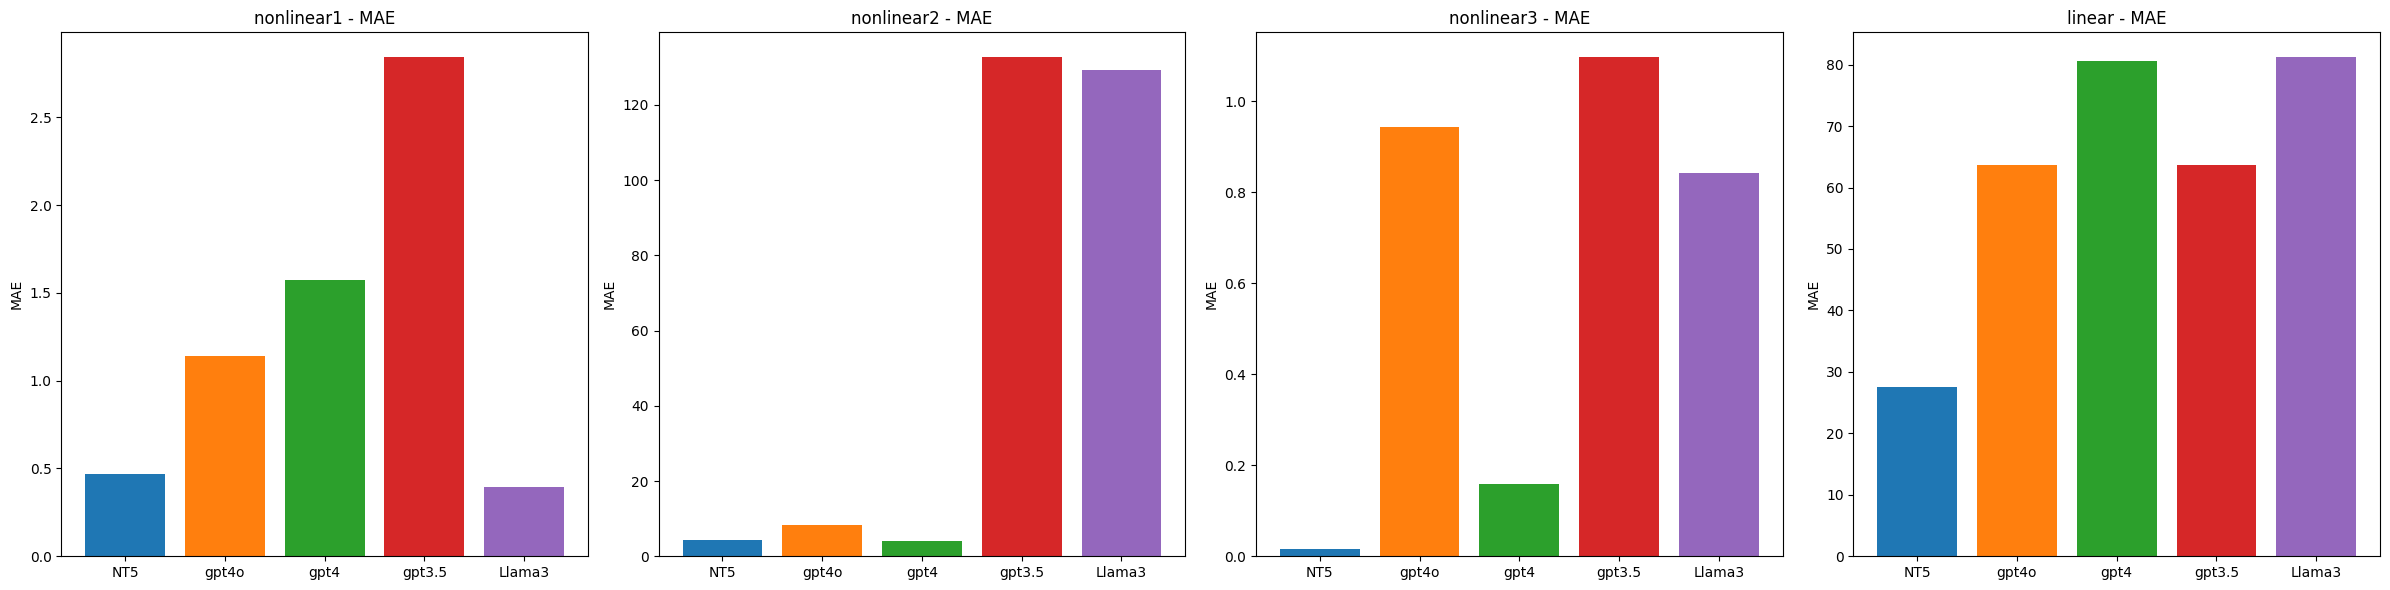

In [1]:
import matplotlib.pyplot as plt

# Recreate the data due to reset
plot_data = {
    'nonlinear1': {'MAE': [0.4702, 1.139878757745116, 1.5714132929339186, 2.8415558338369316, 0.394127],
                   'MSE': [0.3555, 1.2993235823585487, 2.4693397372094217, 8.074439556812699, 0.155336]},
    'nonlinear2': {'MAE': [4.4425, 8.32898398951329, 4.1007117469301875, 132.65456034598185, 129.291577],
                   'MSE': [173.8871, 69.37197429756873, 16.81583683141123, 17597.23238058574, 16716.311775]},
    'nonlinear3': {'MAE': [0.0152, 0.9435673357549009, 0.15970348414150592, 1.0968755919776831, 0.842519],
                   'MSE': [0.0005, 0.8903193171036019, 0.025505202846936234, 1.2031360642763929, 0.709838]},
    'linear': {'MAE': [27.5645, 63.70544162428624, 80.54596361027923, 63.70544162428624, 81.189705],
               'MSE': [1710.6181, 4058.3832925453416, 6487.652253908426, 4058.3832925453416, 6591.768227]}
}

metrics = ['MAE']
model_names = ['NT5', 'gpt4o', 'gpt4', 'gpt3.5', 'Llama3']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plotting the results for each metric separately for all models horizontally without MSE
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Plotting
for i, model in enumerate(plot_data.keys()):
    axs[i].bar(model_names, plot_data[model]['MAE'], color=colors)
    axs[i].set_title(f'{model} - MAE')
    axs[i].set_ylabel('MAE')

plt.tight_layout()
plt.show()

